# Library Imports and Settings

In [120]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from scipy.stats import norm
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import scipy
import scipy.stats as stats
from scipy.stats import skew,boxcox_normmax, zscore
from scipy.special import boxcox1p
from scipy.stats import boxcox
from scipy.stats import boxcox_normmax

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [121]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

# Method Definitions 

In [122]:
#######################################################
# For Dataset Loading
######################################################
def load_train():
    data = pd.read_csv("../HPP/train.csv")
    return data

def load_test():
    data = pd.read_csv("../HPP/test.csv")
    return data

def concat_df_on_y_axis(df_1, df_2):
    return pd.concat([df_1, df_2])

def concat_df_on_x_axis(df_1, df_2):
    return pd.concat([df_1, df_2], axis = 1)

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.
    Not: Kategorik değişkenlerin içerisine numerik görünümlü kategorik değişkenler de dahildir.

    Parameters
    ------
        dataframe: dataframe
                Değişken isimleri alınmak istenilen dataframe
        cat_th: int, optional
                numerik fakat kategorik olan değişkenler için sınıf eşik değeri
        car_th: int, optinal
                kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    ------
        cat_cols: list
                Kategorik değişken listesi
        num_cols: list
                Numerik değişken listesi
        cat_but_car: list
                Kategorik görünümlü kardinal değişken listesi

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = toplam değişken sayısı
        num_but_cat cat_cols'un içerisinde.
        Return olan 3 liste toplamı toplam değişken sayısına eşittir: cat_cols + num_cols + cat_but_car = değişken sayısı

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car


######################################################
# For Outliers
######################################################
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

######################################################
# For Missing Values
######################################################
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return missing_df, na_columns
    
    return missing_df

def quick_missing_imp_groupped(data, cat_cols, num_cols, missing_columns_df, num_method = 'median', groupby = 'Neighborhood', target = 'SalePrice'):
    missing_columns = missing_columns_df.T.columns
    missing_columns = [col for col in missing_columns if col not in target]
    missing_cat_cols = [col for col in missing_columns if col not in num_cols]
    missing_num_cols = [col for col in missing_columns if col not in cat_cols]

    print("# BEFORE")
    print(missing_columns_df)  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    data[missing_cat_cols] = data.groupby(groupby)[missing_cat_cols].transform(lambda x:x.fillna(x.mode()[0]))

    if num_method == "mean":
        data[missing_num_cols] = data.groupby(groupby)[missing_num_cols].transform(lambda x: x.fillna(x.mean()))
        
    elif num_method == "median":
        data[missing_num_cols] = data.groupby(groupby)[missing_num_cols].transform(lambda x: x.fillna(x.median()))
    
    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[missing_columns].isnull().sum(), "\n\n")

    return data

'''
def quick_missing_imp_groupped(data, cat_cols, num_cols, num_method = "median", groupby = "Neighborhood", cat_length = 20):
    cat_col_variables_with_na = [col for col in cat_cols if data[col].isnull().sum() > 0]
    num_col_variables_with_na = [col for col in num_cols if data[col].isnull().sum() > 0]

    #temp_target = data[target] can given as parameter to get rid of target

    print("# BEFORE")
    #print(data[cat_col_variables_with_na].sum())
    #print(data[num_col_variables_with_na].sum())

    if groupby != "":
        #data[cat_cols] = data.groupby(groupby)[cat_cols].transform(lambda x:x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x)
        data[cat_cols] = data.groupby(groupby)[cat_cols].transform(lambda x:x.fillna(x.mode()[0]))
        if num_method == "mean":
            #data[num_cols] = data.groupby(groupby)[num_cols].transform(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x)
            data[num_cols] = data.groupby(groupby)[num_cols].transform(lambda x: x.fillna(x.mean()))
        elif num_method == "median":
            #data[num_cols] = data.groupby(groupby)[num_cols].transform(lambda x: x.fillna(x.median()) if x.dtype != "O" else x)
            data[num_cols] = data.groupby(groupby)[num_cols].transform(lambda x: x.fillna(x.median()))
    else:
        quick_missing_imp(data, num_method, cat_length)

    #data[target] = temp_target can given as parameter to get rid of target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[cat_col_variables_with_na].isnull().sum(), "\n\n")
    print(data[num_col_variables_with_na].isnull().sum(), "\n\n")

    return data

def quick_missing_imp(data, num_method="median", cat_length=20):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    #temp_target = data[target] can given as parameter to get rid of target

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    #data[target] = temp_target can given as parameter to get rid of target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data
'''

######################################################
# For Encoders
######################################################
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def one_hot_encoder_na_dummy(dataframe, categorical_cols, drop_first=True, dummy_na=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first, dummy_na = dummy_na)
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_analyser(dataframe, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe)}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

######################################################
# For EDA
######################################################
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        #import seaborn as sns
        #import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

    print("#####################################")

def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    #print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

# Preprocessing

## Dataset Reading

In [123]:
df_train = load_train()
df_test = load_test()
df = concat_df_on_y_axis(df_train, df_test)
#df = df.drop['SalePrice']
df.shape

(2919, 81)

In [124]:
df_copy = df.copy()
check_df(df_copy)

##################### Shape #####################
(2919, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2  

In [125]:
df_copy.drop(['Id'], axis = 1, inplace = True)
cat_cols_eda, num_cols_eda, cat_but_car_eda = grab_col_names(df)
#num_cols_eda = [col for col in num_cols_eda if col not in 'SalePrice']

Observations: 2919
Variables: 81
cat_cols: 52
num_cols: 28
cat_but_car: 1
num_but_cat: 10


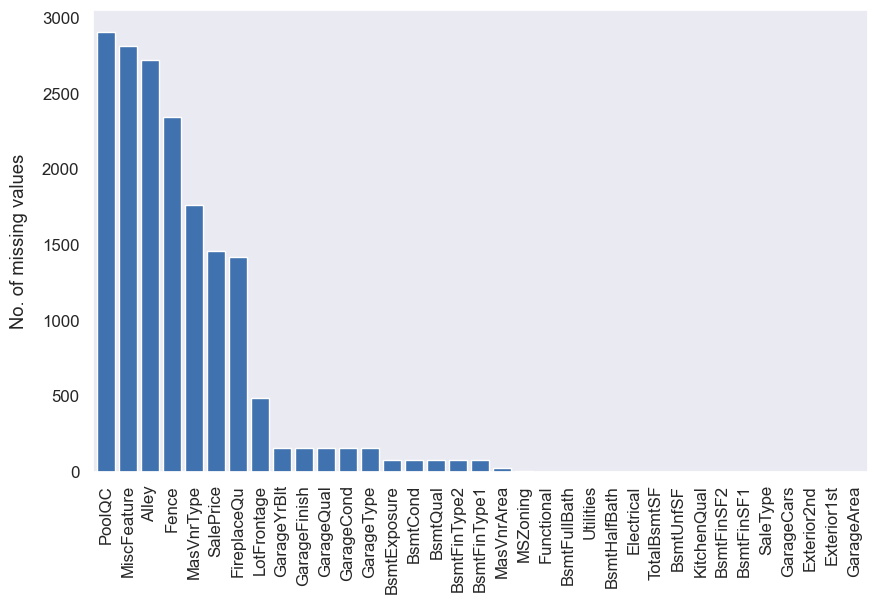

In [126]:
nans = df.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

          MSZoning  Ratio
MSZoning                 
RL            1151 78.836
RM             218 14.932
FV              65  4.452
RH              16  1.096
C (all)         10  0.685


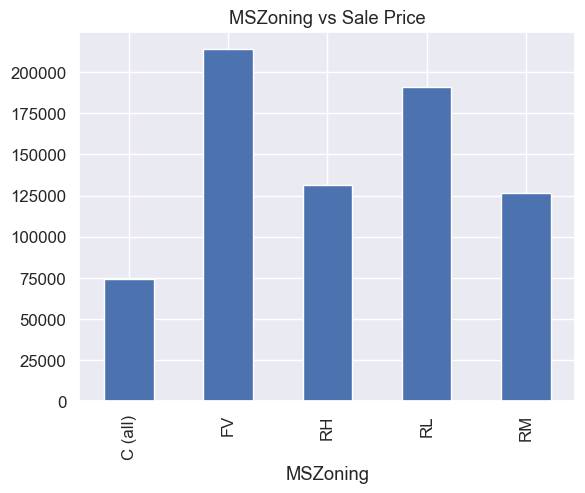

        Street  Ratio
Street               
Pave      1454 99.589
Grvl         6  0.411


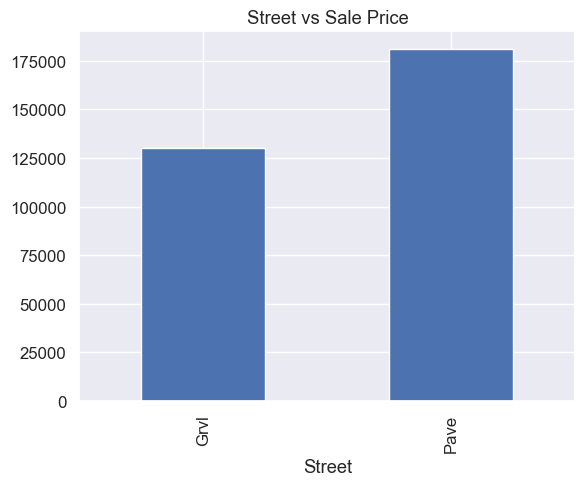

       Alley  Ratio
Alley              
Grvl      50  3.425
Pave      41  2.808


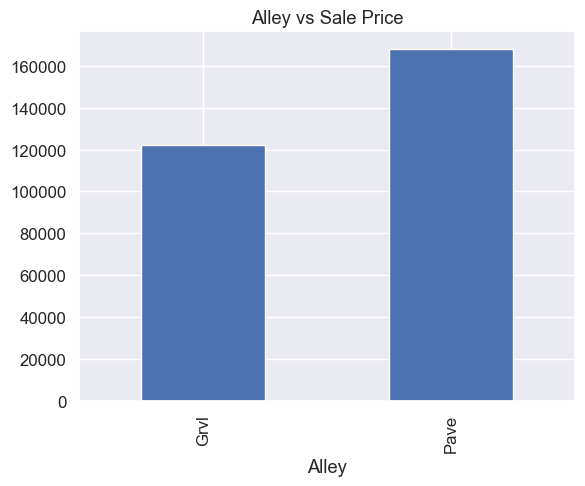

          LotShape  Ratio
LotShape                 
Reg            925 63.356
IR1            484 33.151
IR2             41  2.808
IR3             10  0.685


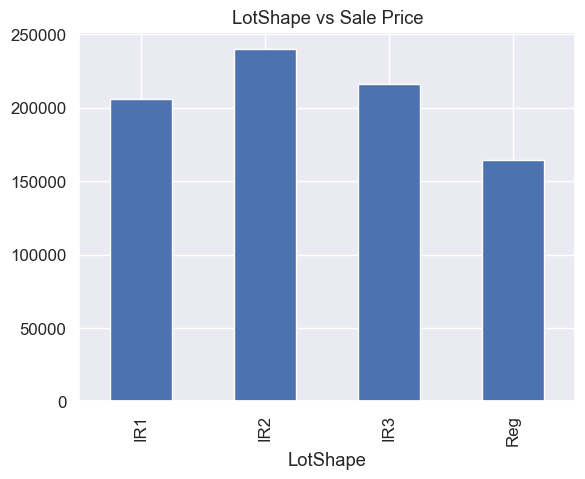

             LandContour  Ratio
LandContour                    
Lvl                 1311 89.795
Bnk                   63  4.315
HLS                   50  3.425
Low                   36  2.466


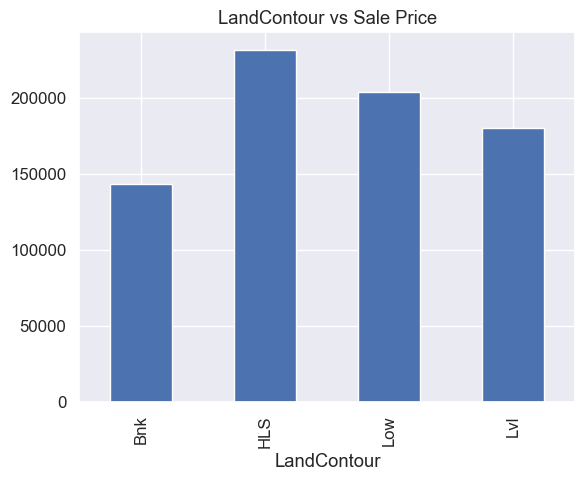

           Utilities  Ratio
Utilities                  
AllPub          1459 99.932
NoSeWa             1  0.068


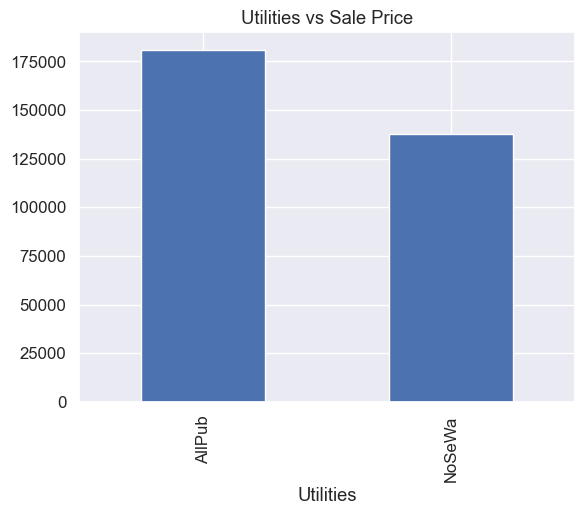

           LotConfig  Ratio
LotConfig                  
Inside          1052 72.055
Corner           263 18.014
CulDSac           94  6.438
FR2               47  3.219
FR3                4  0.274


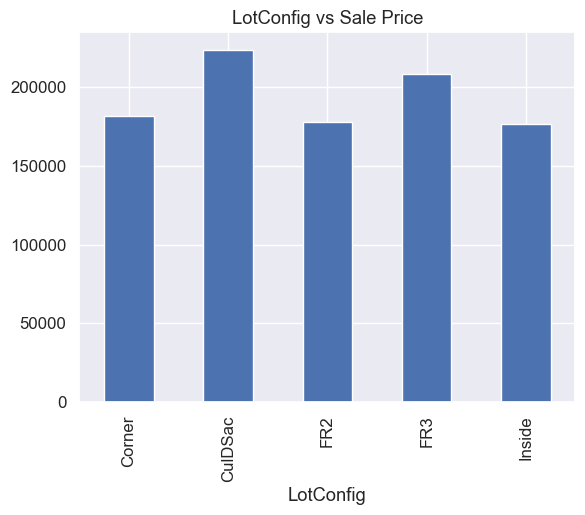

           LandSlope  Ratio
LandSlope                  
Gtl             1382 94.658
Mod               65  4.452
Sev               13  0.890


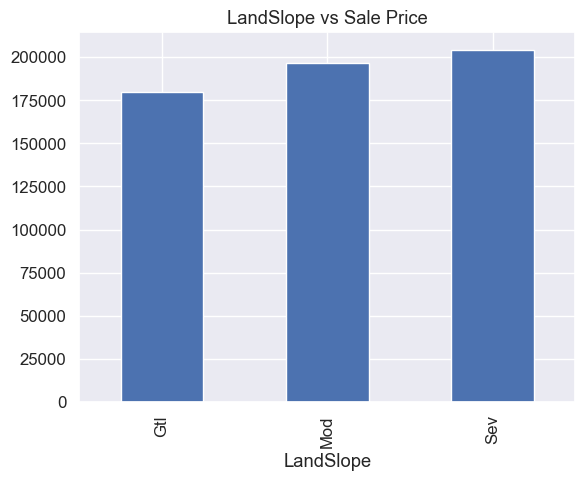

            Condition1  Ratio
Condition1                   
Norm              1260 86.301
Feedr               81  5.548
Artery              48  3.288
RRAn                26  1.781
PosN                19  1.301
RRAe                11  0.753
PosA                 8  0.548
RRNn                 5  0.342
RRNe                 2  0.137


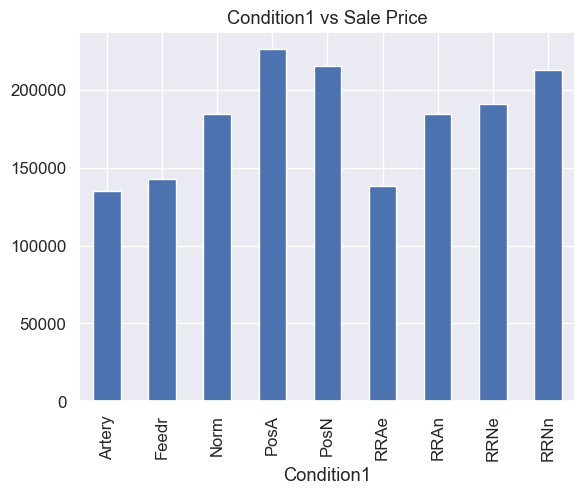

            Condition2  Ratio
Condition2                   
Norm              1445 98.973
Feedr                6  0.411
Artery               2  0.137
RRNn                 2  0.137
PosN                 2  0.137
PosA                 1  0.068
RRAn                 1  0.068
RRAe                 1  0.068


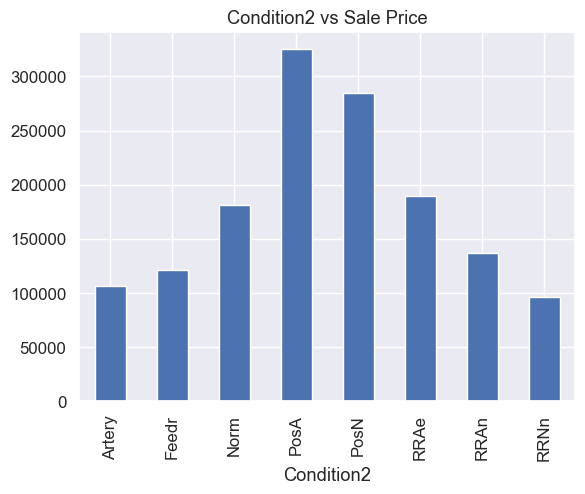

          BldgType  Ratio
BldgType                 
1Fam          1220 83.562
TwnhsE         114  7.808
Duplex          52  3.562
Twnhs           43  2.945
2fmCon          31  2.123


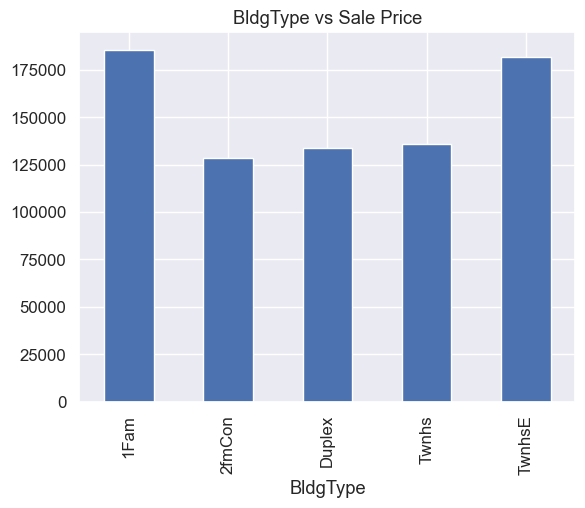

            HouseStyle  Ratio
HouseStyle                   
1Story             726 49.726
2Story             445 30.479
1.5Fin             154 10.548
SLvl                65  4.452
SFoyer              37  2.534
1.5Unf              14  0.959
2.5Unf              11  0.753
2.5Fin               8  0.548


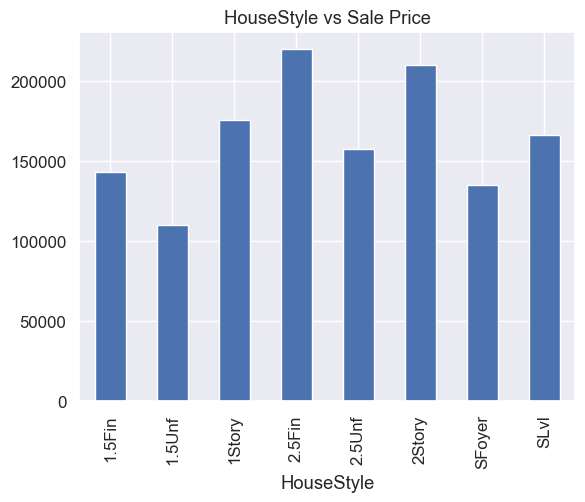

           RoofStyle  Ratio
RoofStyle                  
Gable           1141 78.151
Hip              286 19.589
Flat              13  0.890
Gambrel           11  0.753
Mansard            7  0.479
Shed               2  0.137


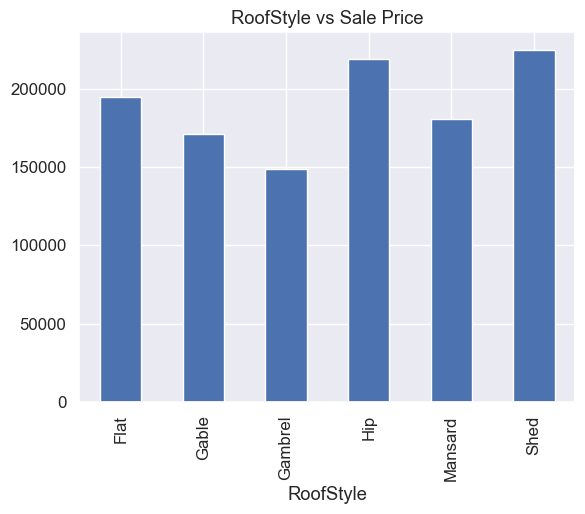

          RoofMatl  Ratio
RoofMatl                 
CompShg       1434 98.219
Tar&Grv         11  0.753
WdShngl          6  0.411
WdShake          5  0.342
Metal            1  0.068
Membran          1  0.068
Roll             1  0.068
ClyTile          1  0.068


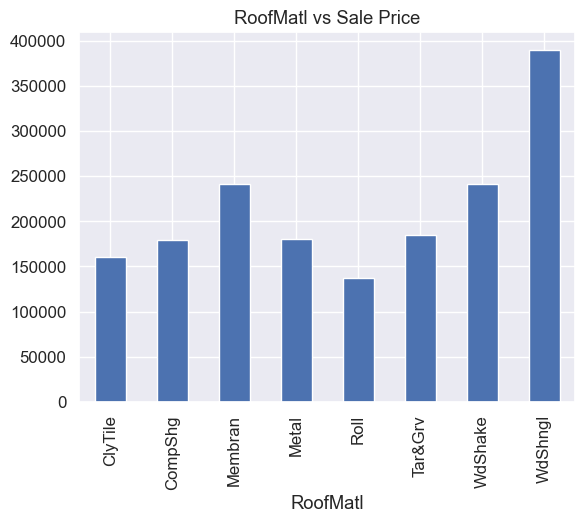

             Exterior1st  Ratio
Exterior1st                    
VinylSd              515 35.274
HdBoard              222 15.205
MetalSd              220 15.068
Wd Sdng              206 14.110
Plywood              108  7.397
CemntBd               61  4.178
BrkFace               50  3.425
WdShing               26  1.781
Stucco                25  1.712
AsbShng               20  1.370
BrkComm                2  0.137
Stone                  2  0.137
AsphShn                1  0.068
ImStucc                1  0.068
CBlock                 1  0.068


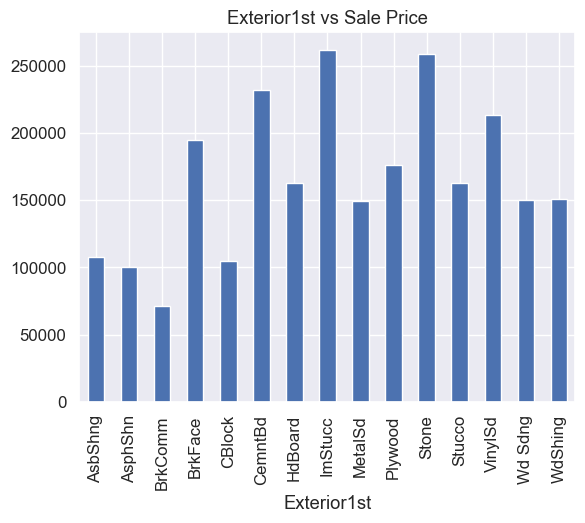

             Exterior2nd  Ratio
Exterior2nd                    
VinylSd              504 34.521
MetalSd              214 14.658
HdBoard              207 14.178
Wd Sdng              197 13.493
Plywood              142  9.726
CmentBd               60  4.110
Wd Shng               38  2.603
Stucco                26  1.781
BrkFace               25  1.712
AsbShng               20  1.370
ImStucc               10  0.685
Brk Cmn                7  0.479
Stone                  5  0.342
AsphShn                3  0.205
Other                  1  0.068
CBlock                 1  0.068


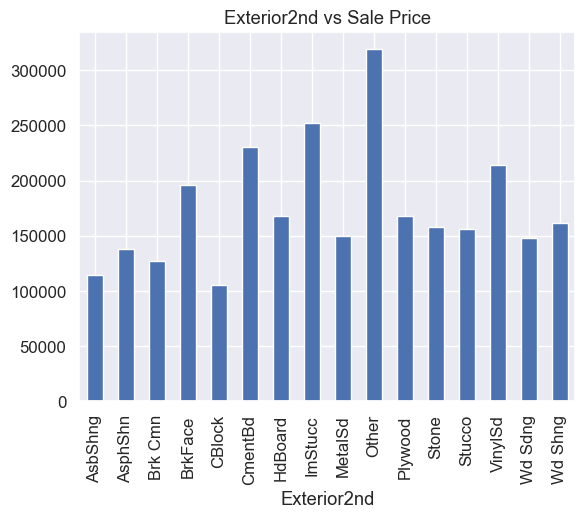

            MasVnrType  Ratio
MasVnrType                   
BrkFace            445 30.479
Stone              128  8.767
BrkCmn              15  1.027


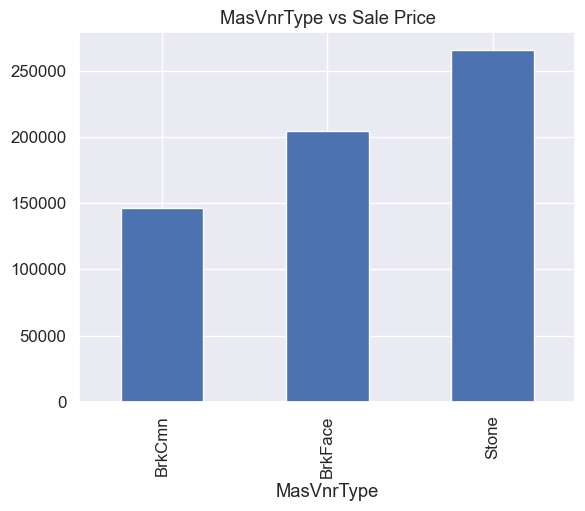

           ExterQual  Ratio
ExterQual                  
TA               906 62.055
Gd               488 33.425
Ex                52  3.562
Fa                14  0.959


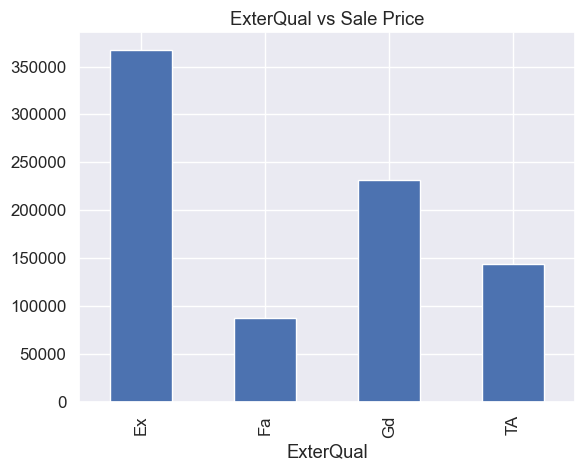

           ExterCond  Ratio
ExterCond                  
TA              1282 87.808
Gd               146 10.000
Fa                28  1.918
Ex                 3  0.205
Po                 1  0.068


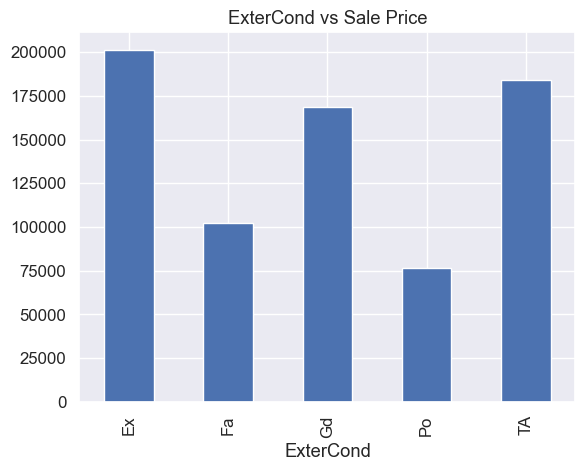

            Foundation  Ratio
Foundation                   
PConc              647 44.315
CBlock             634 43.425
BrkTil             146 10.000
Slab                24  1.644
Stone                6  0.411
Wood                 3  0.205


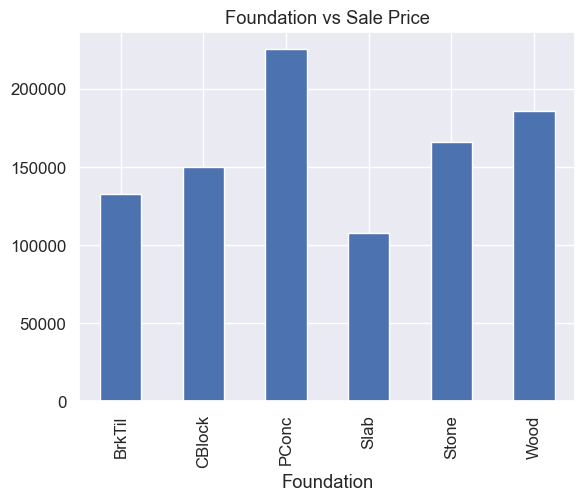

          BsmtQual  Ratio
BsmtQual                 
TA             649 44.452
Gd             618 42.329
Ex             121  8.288
Fa              35  2.397


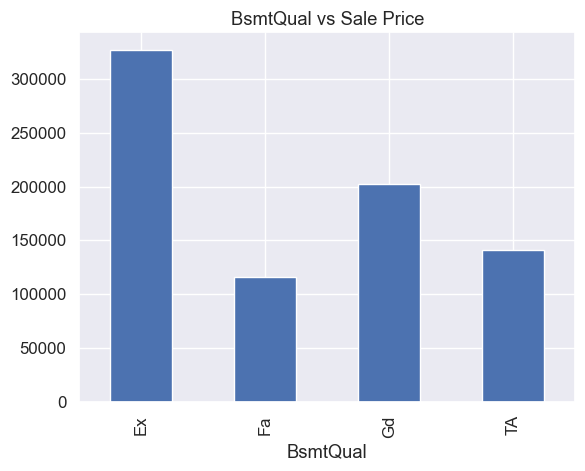

          BsmtCond  Ratio
BsmtCond                 
TA            1311 89.795
Gd              65  4.452
Fa              45  3.082
Po               2  0.137


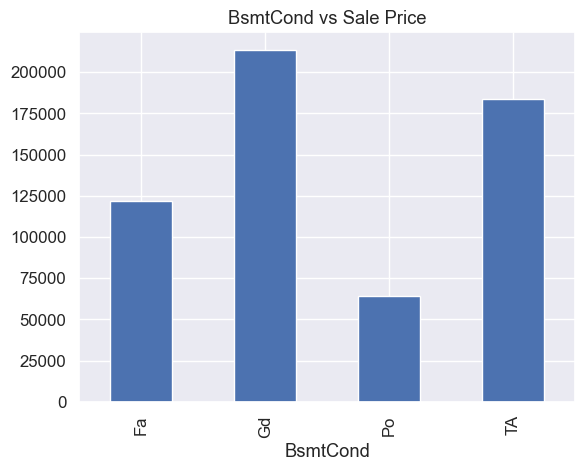

              BsmtExposure  Ratio
BsmtExposure                     
No                     953 65.274
Av                     221 15.137
Gd                     134  9.178
Mn                     114  7.808


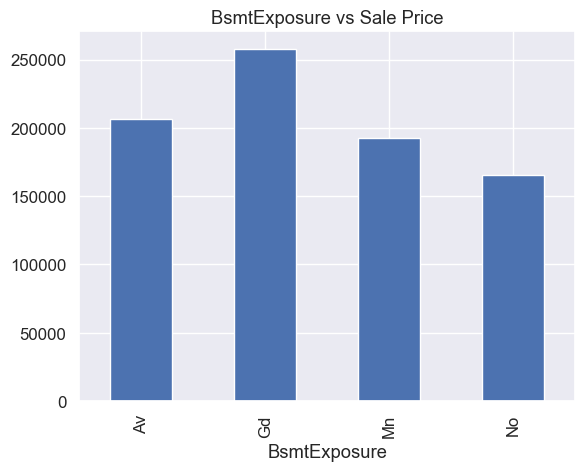

              BsmtFinType1  Ratio
BsmtFinType1                     
Unf                    430 29.452
GLQ                    418 28.630
ALQ                    220 15.068
BLQ                    148 10.137
Rec                    133  9.110
LwQ                     74  5.068


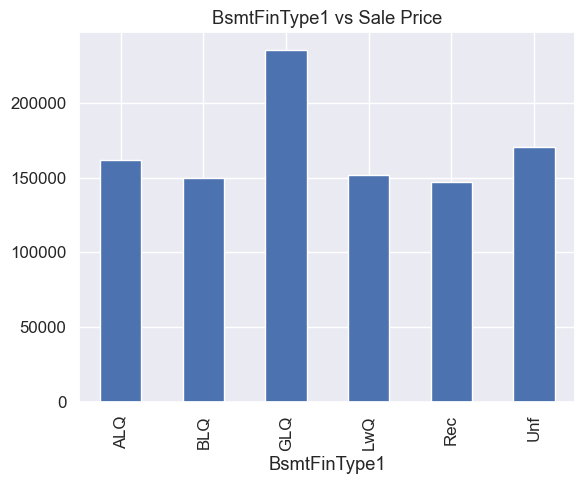

              BsmtFinType2  Ratio
BsmtFinType2                     
Unf                   1256 86.027
Rec                     54  3.699
LwQ                     46  3.151
BLQ                     33  2.260
ALQ                     19  1.301
GLQ                     14  0.959


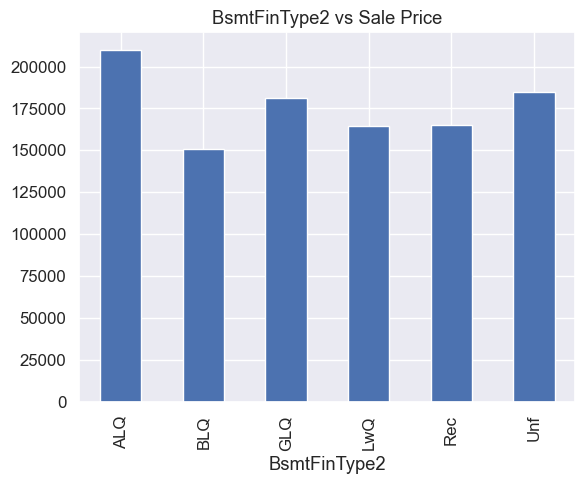

         Heating  Ratio
Heating                
GasA        1428 97.808
GasW          18  1.233
Grav           7  0.479
Wall           4  0.274
OthW           2  0.137
Floor          1  0.068


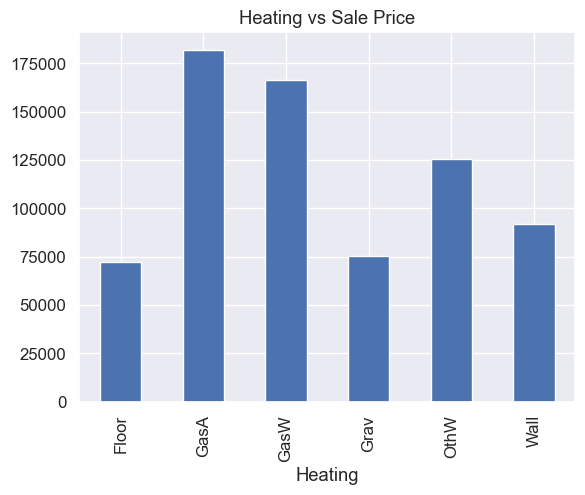

           HeatingQC  Ratio
HeatingQC                  
Ex               741 50.753
TA               428 29.315
Gd               241 16.507
Fa                49  3.356
Po                 1  0.068


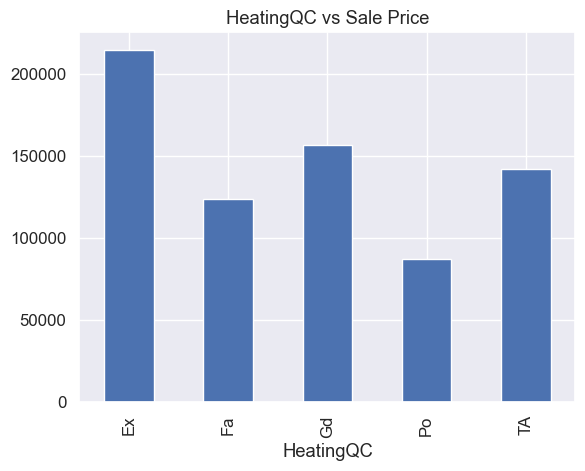

            CentralAir  Ratio
CentralAir                   
Y                 1365 93.493
N                   95  6.507


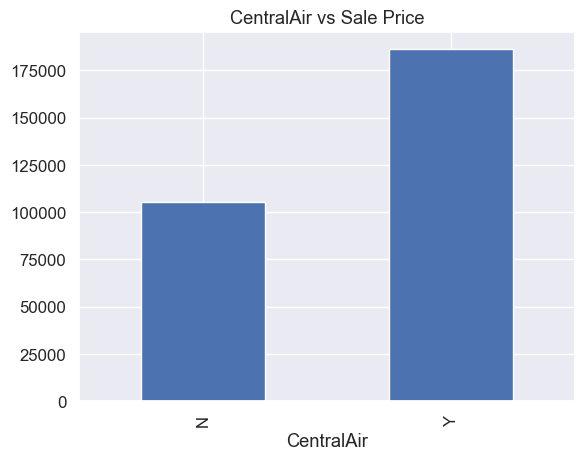

            Electrical  Ratio
Electrical                   
SBrkr             1334 91.370
FuseA               94  6.438
FuseF               27  1.849
FuseP                3  0.205
Mix                  1  0.068


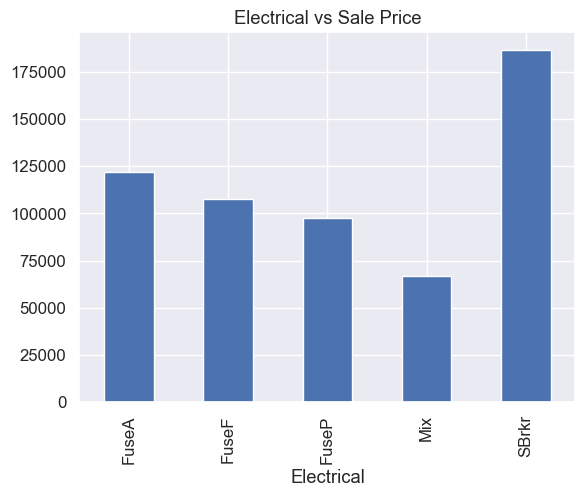

             KitchenQual  Ratio
KitchenQual                    
TA                   735 50.342
Gd                   586 40.137
Ex                   100  6.849
Fa                    39  2.671


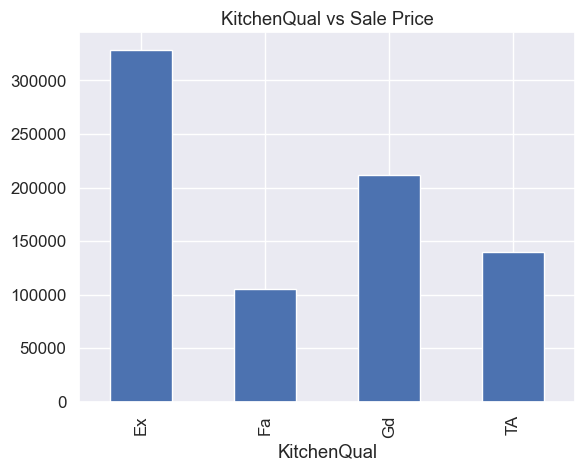

            Functional  Ratio
Functional                   
Typ               1360 93.151
Min2                34  2.329
Min1                31  2.123
Mod                 15  1.027
Maj1                14  0.959
Maj2                 5  0.342
Sev                  1  0.068


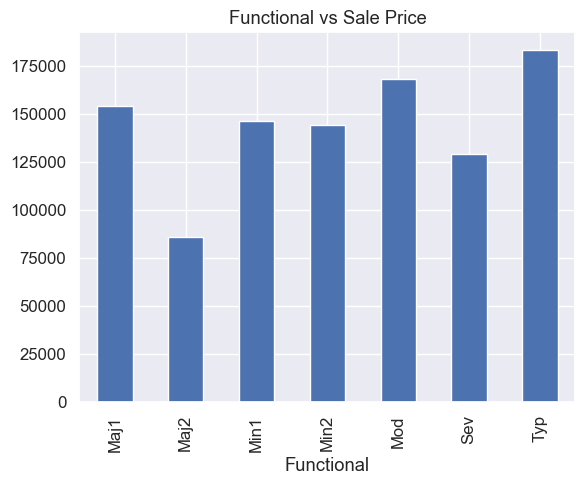

             FireplaceQu  Ratio
FireplaceQu                    
Gd                   380 26.027
TA                   313 21.438
Fa                    33  2.260
Ex                    24  1.644
Po                    20  1.370


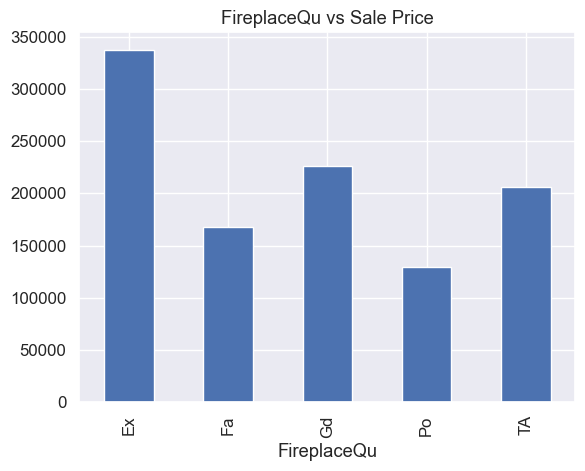

            GarageType  Ratio
GarageType                   
Attchd             870 59.589
Detchd             387 26.507
BuiltIn             88  6.027
Basment             19  1.301
CarPort              9  0.616
2Types               6  0.411


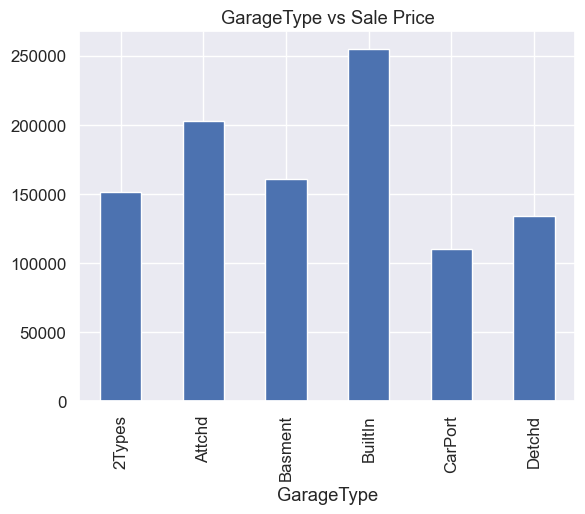

              GarageFinish  Ratio
GarageFinish                     
Unf                    605 41.438
RFn                    422 28.904
Fin                    352 24.110


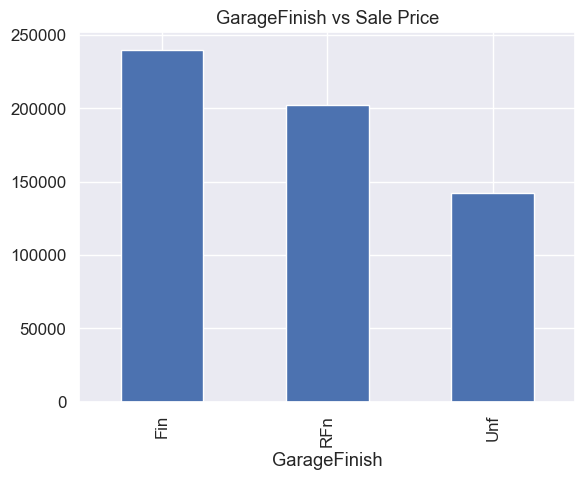

            GarageQual  Ratio
GarageQual                   
TA                1311 89.795
Fa                  48  3.288
Gd                  14  0.959
Ex                   3  0.205
Po                   3  0.205


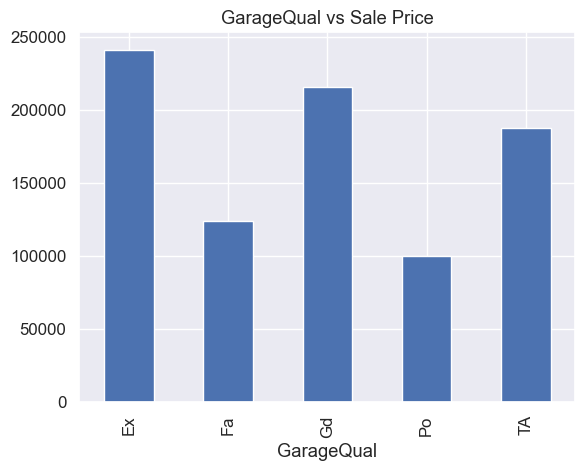

            GarageCond  Ratio
GarageCond                   
TA                1326 90.822
Fa                  35  2.397
Gd                   9  0.616
Po                   7  0.479
Ex                   2  0.137


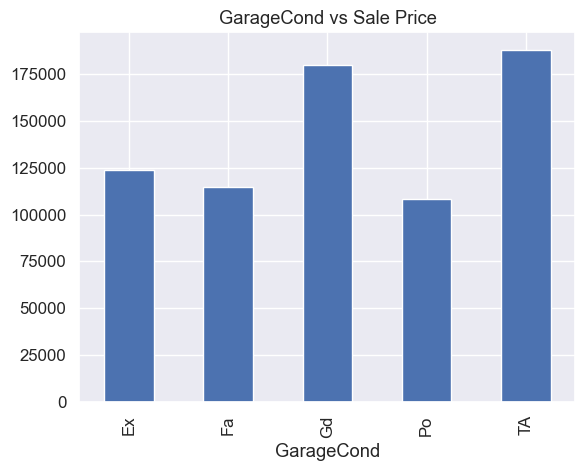

            PavedDrive  Ratio
PavedDrive                   
Y                 1340 91.781
N                   90  6.164
P                   30  2.055


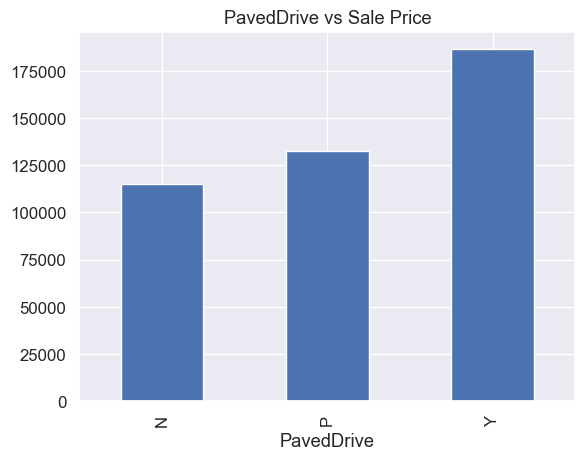

        PoolQC  Ratio
PoolQC               
Gd           3  0.205
Ex           2  0.137
Fa           2  0.137


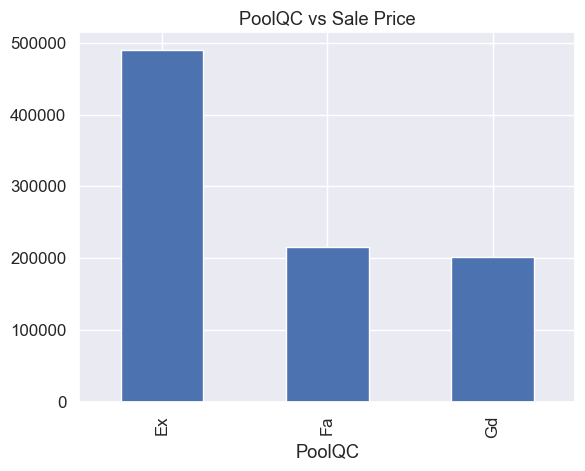

       Fence  Ratio
Fence              
MnPrv    157 10.753
GdPrv     59  4.041
GdWo      54  3.699
MnWw      11  0.753


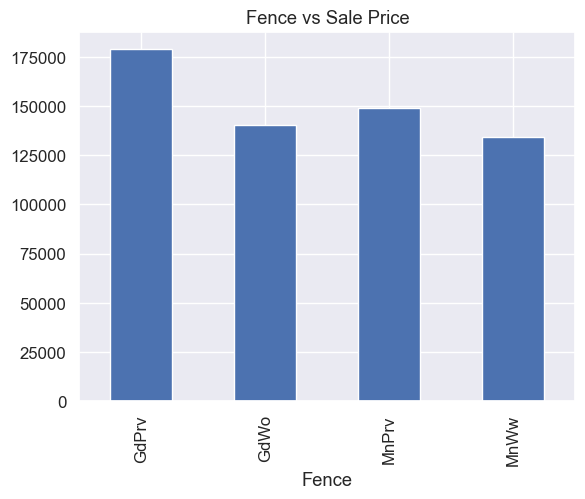

             MiscFeature  Ratio
MiscFeature                    
Shed                  49  3.356
Gar2                   2  0.137
Othr                   2  0.137
TenC                   1  0.068


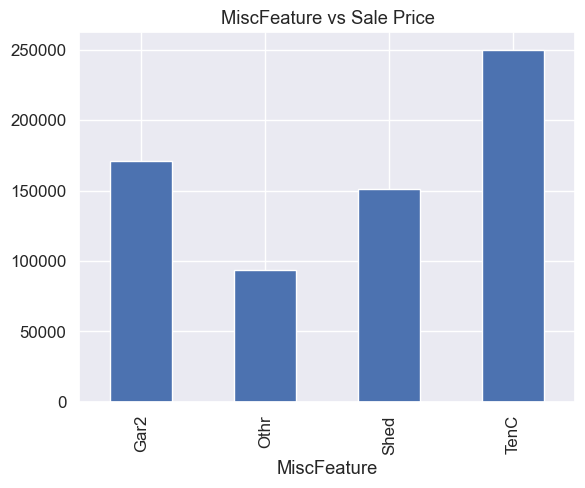

          SaleType  Ratio
SaleType                 
WD            1267 86.781
New            122  8.356
COD             43  2.945
ConLD            9  0.616
ConLI            5  0.342
ConLw            5  0.342
CWD              4  0.274
Oth              3  0.205
Con              2  0.137


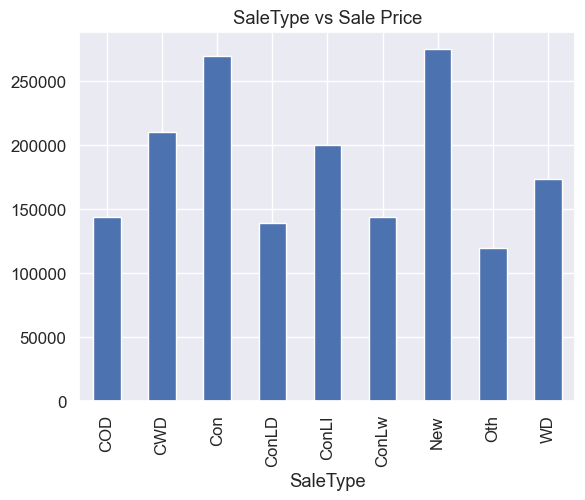

               SaleCondition  Ratio
SaleCondition                      
Normal                  1198 82.055
Partial                  125  8.562
Abnorml                  101  6.918
Family                    20  1.370
Alloca                    12  0.822
AdjLand                    4  0.274


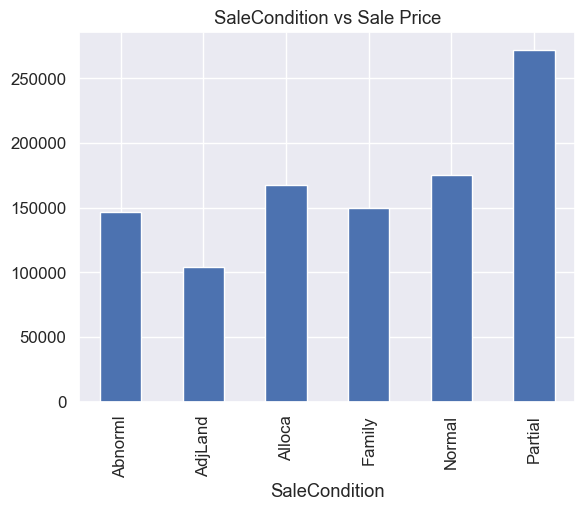

             OverallCond  Ratio
OverallCond                    
5                    821 56.233
6                    252 17.260
7                    205 14.041
8                     72  4.932
4                     57  3.904
3                     25  1.712
9                     22  1.507
2                      5  0.342
1                      1  0.068


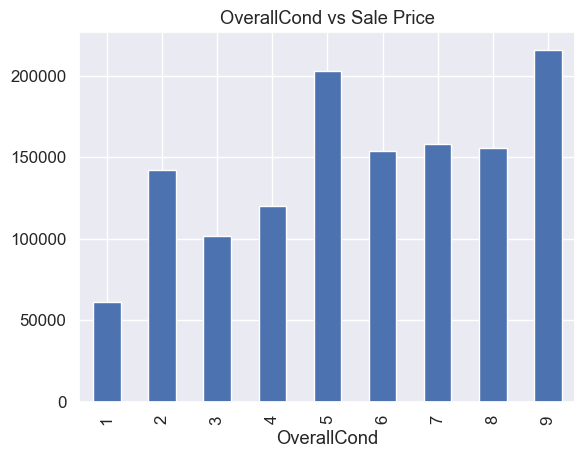

              BsmtFullBath  Ratio
BsmtFullBath                     
0                      856 58.630
1                      588 40.274
2                       15  1.027
3                        1  0.068


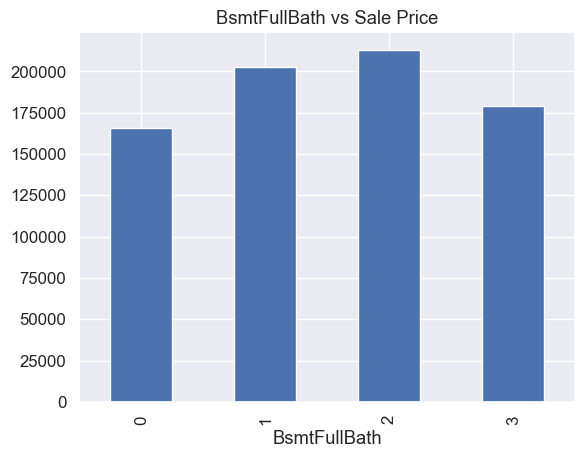

              BsmtHalfBath  Ratio
BsmtHalfBath                     
0                     1378 94.384
1                       80  5.479
2                        2  0.137


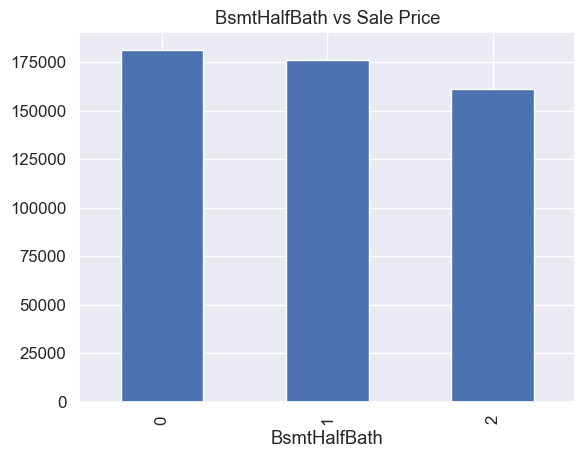

          FullBath  Ratio
FullBath                 
2              768 52.603
1              650 44.521
3               33  2.260
0                9  0.616


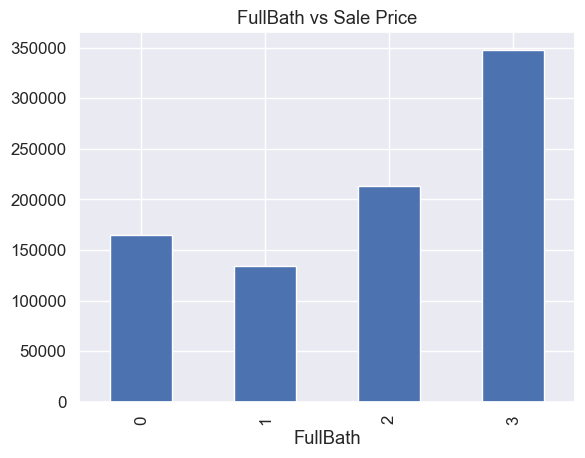

          HalfBath  Ratio
HalfBath                 
0              913 62.534
1              535 36.644
2               12  0.822


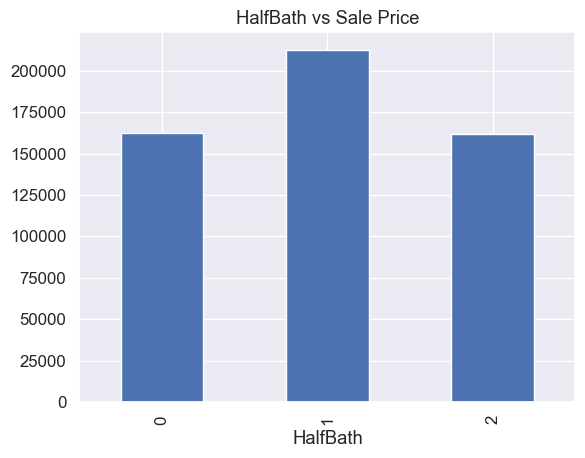

              BedroomAbvGr  Ratio
BedroomAbvGr                     
3                      804 55.068
2                      358 24.521
4                      213 14.589
1                       50  3.425
5                       21  1.438
6                        7  0.479
0                        6  0.411
8                        1  0.068


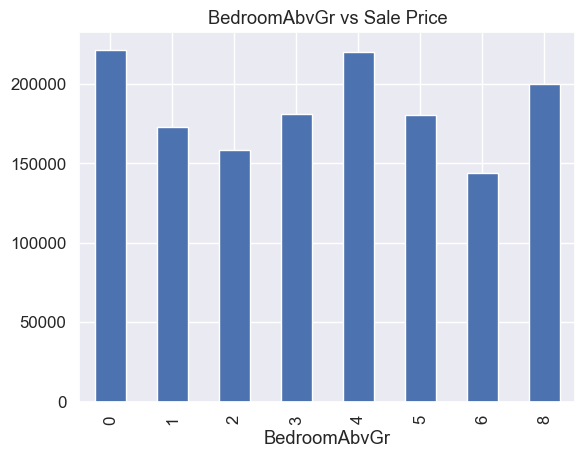

              KitchenAbvGr  Ratio
KitchenAbvGr                     
1                     1392 95.342
2                       65  4.452
3                        2  0.137
0                        1  0.068


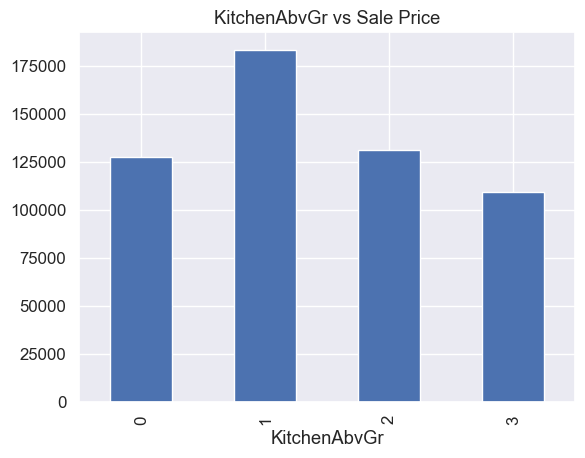

            Fireplaces  Ratio
Fireplaces                   
0                  690 47.260
1                  650 44.521
2                  115  7.877
3                    5  0.342


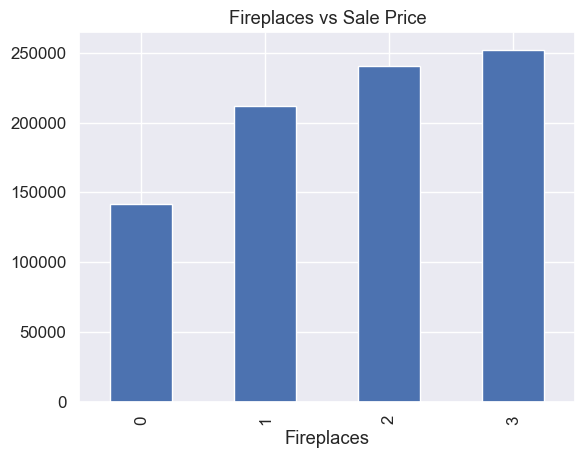

            GarageCars  Ratio
GarageCars                   
2                  824 56.438
1                  369 25.274
3                  181 12.397
0                   81  5.548
4                    5  0.342


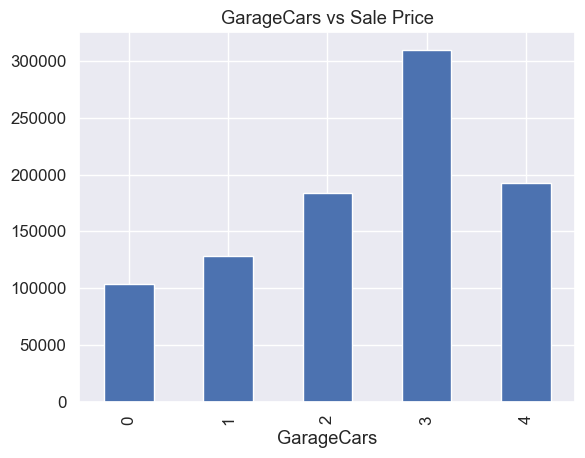

        YrSold  Ratio
YrSold               
2009       338 23.151
2007       329 22.534
2006       314 21.507
2008       304 20.822
2010       175 11.986


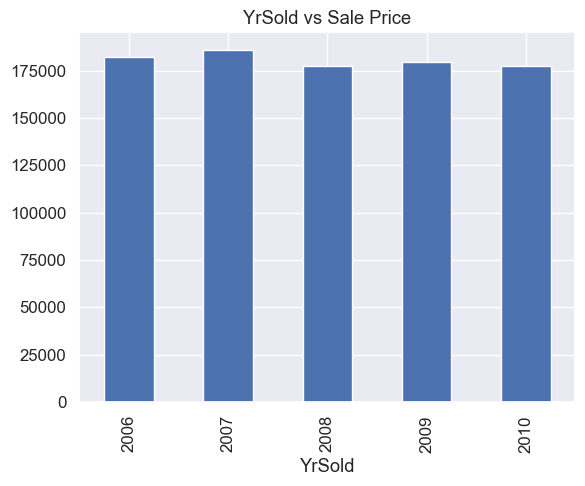

In [127]:
for feature in cat_cols_eda:
    cat_summary(df_train, feature)
    df_train.groupby(feature)['SalePrice'].mean().plot.bar()
    plt.title(feature + ' vs Sale Price')
    plt.show()

count   1460.000
mean     730.500
std      421.610
min        1.000
5%        73.950
10%      146.900
20%      292.800
30%      438.700
40%      584.600
50%      730.500
60%      876.400
70%     1022.300
80%     1168.200
90%     1314.100
95%     1387.050
99%     1445.410
max     1460.000
Name: Id, dtype: float64


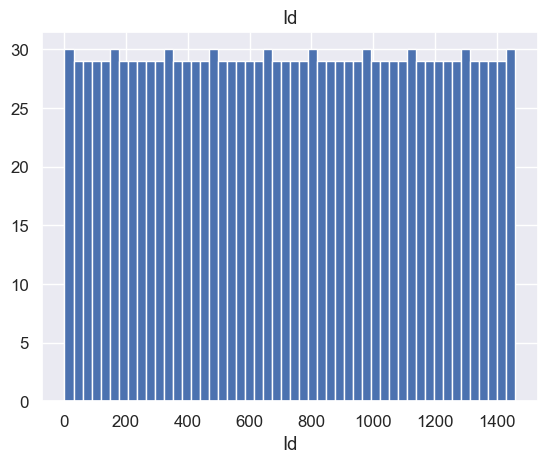

#####################################
count   1460.000
mean      56.897
std       42.301
min       20.000
5%        20.000
10%       20.000
20%       20.000
30%       20.000
40%       30.000
50%       50.000
60%       60.000
70%       60.000
80%       80.000
90%      120.000
95%      160.000
99%      190.000
max      190.000
Name: MSSubClass, dtype: float64


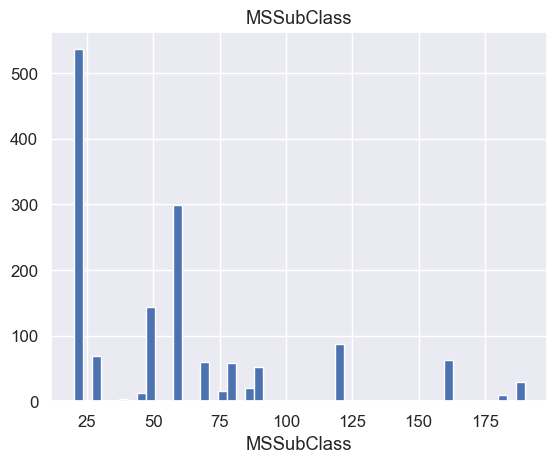

#####################################
count   1201.000
mean      70.050
std       24.285
min       21.000
5%        34.000
10%       44.000
20%       53.000
30%       60.000
40%       63.000
50%       69.000
60%       74.000
70%       79.000
80%       85.000
90%       96.000
95%      107.000
99%      141.000
max      313.000
Name: LotFrontage, dtype: float64


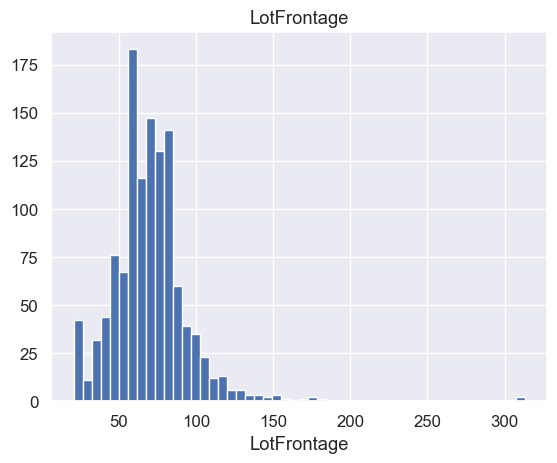

#####################################
count     1460.000
mean     10516.828
std       9981.265
min       1300.000
5%        3311.700
10%       5000.000
20%       7078.400
30%       8063.700
40%       8793.400
50%       9478.500
60%      10198.200
70%      11066.500
80%      12205.800
90%      14381.700
95%      17401.150
99%      37567.640
max     215245.000
Name: LotArea, dtype: float64


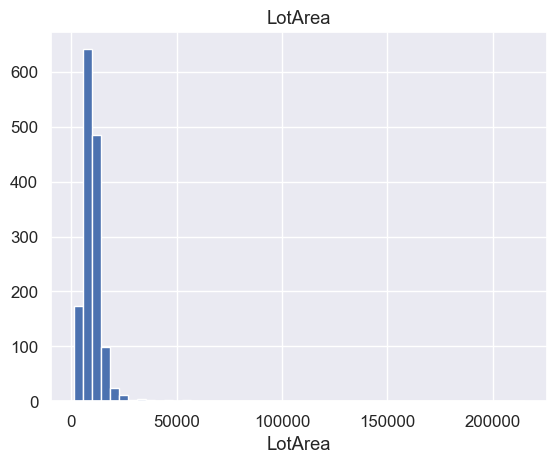

#####################################
count   1460.000
mean       6.099
std        1.383
min        1.000
5%         4.000
10%        5.000
20%        5.000
30%        5.000
40%        6.000
50%        6.000
60%        6.000
70%        7.000
80%        7.000
90%        8.000
95%        8.000
99%       10.000
max       10.000
Name: OverallQual, dtype: float64


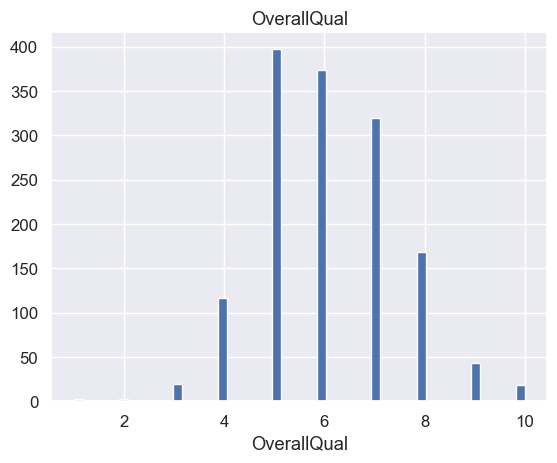

#####################################
count   1460.000
mean    1971.268
std       30.203
min     1872.000
5%      1916.000
10%     1924.900
20%     1947.800
30%     1958.000
40%     1965.000
50%     1973.000
60%     1984.000
70%     1997.300
80%     2003.000
90%     2006.000
95%     2007.000
99%     2009.000
max     2010.000
Name: YearBuilt, dtype: float64


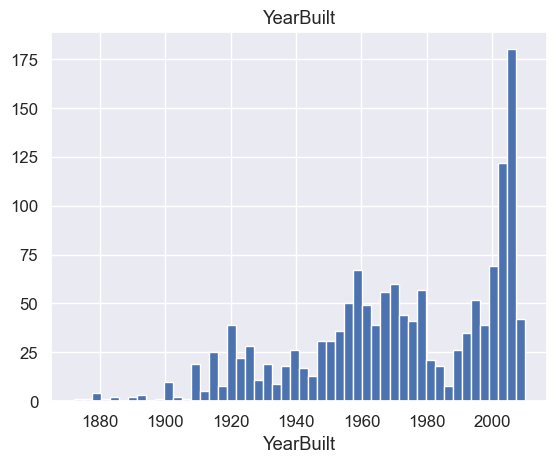

#####################################
count   1460.000
mean    1984.866
std       20.645
min     1950.000
5%      1950.000
10%     1950.000
20%     1961.800
30%     1971.000
40%     1980.000
50%     1994.000
60%     1998.000
70%     2002.000
80%     2005.000
90%     2006.000
95%     2007.000
99%     2009.000
max     2010.000
Name: YearRemodAdd, dtype: float64


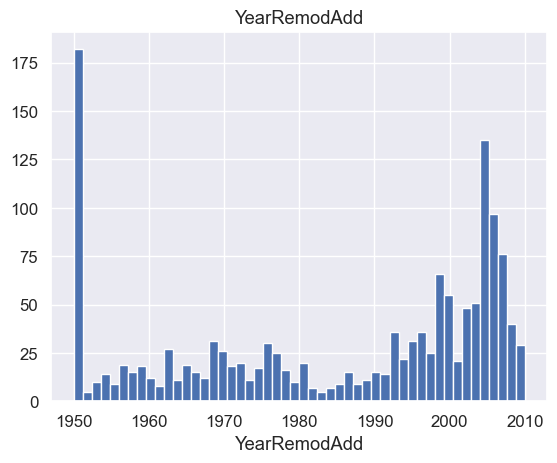

#####################################
count   1452.000
mean     103.685
std      181.066
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%       16.000
70%      117.000
80%      206.000
90%      335.000
95%      456.000
99%      791.920
max     1600.000
Name: MasVnrArea, dtype: float64


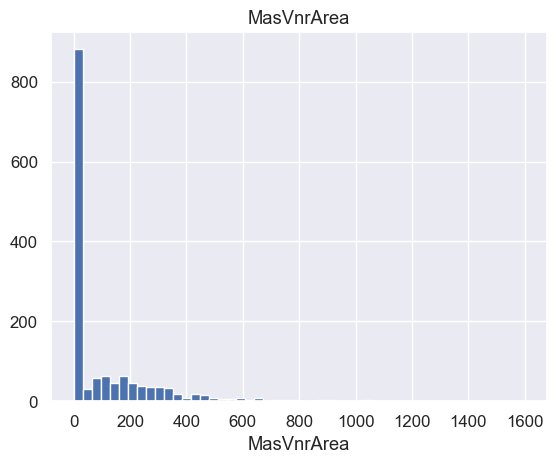

#####################################
count   1460.000
mean     443.640
std      456.098
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%      218.600
50%      383.500
60%      525.600
70%      655.000
80%      806.400
90%     1065.500
95%     1274.000
99%     1572.410
max     5644.000
Name: BsmtFinSF1, dtype: float64


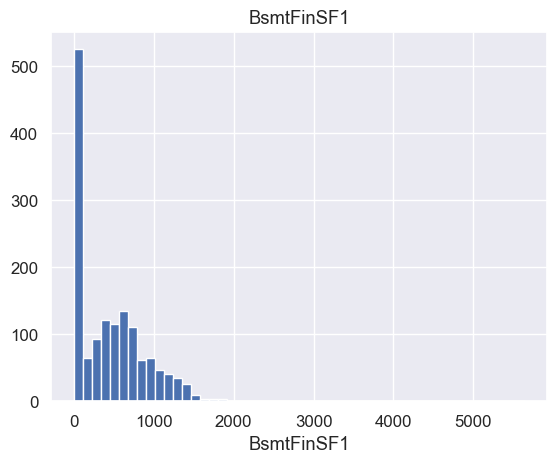

#####################################
count   1460.000
mean      46.549
std      161.319
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      117.200
95%      396.200
99%      830.380
max     1474.000
Name: BsmtFinSF2, dtype: float64


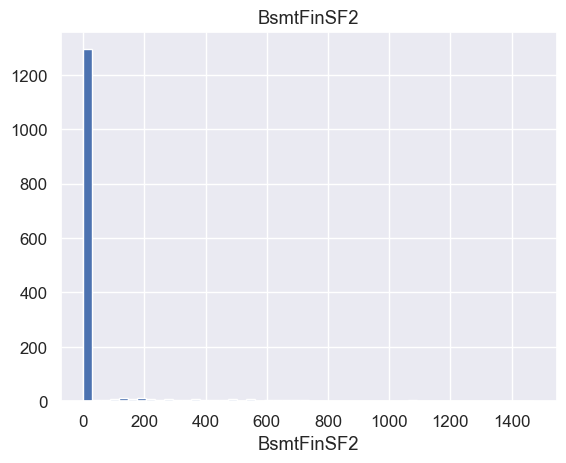

#####################################
count   1460.000
mean     567.240
std      441.867
min        0.000
5%         0.000
10%       74.900
20%      172.000
30%      280.000
40%      374.600
50%      477.500
60%      604.400
70%      736.000
80%      896.000
90%     1232.000
95%     1468.000
99%     1797.050
max     2336.000
Name: BsmtUnfSF, dtype: float64


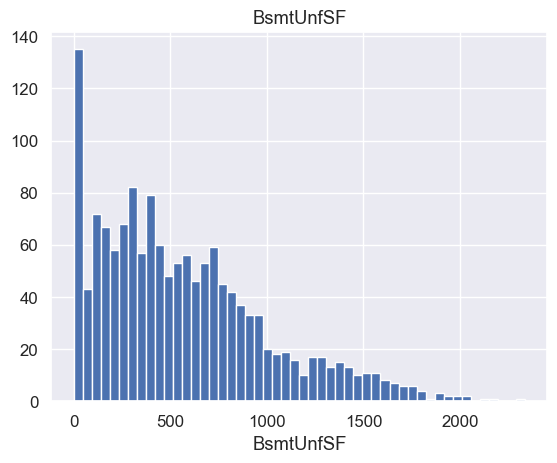

#####################################
count   1460.000
mean    1057.429
std      438.705
min        0.000
5%       519.300
10%      636.900
20%      755.800
30%      840.000
40%      910.000
50%      991.500
60%     1088.000
70%     1216.000
80%     1391.200
90%     1602.200
95%     1753.000
99%     2155.050
max     6110.000
Name: TotalBsmtSF, dtype: float64


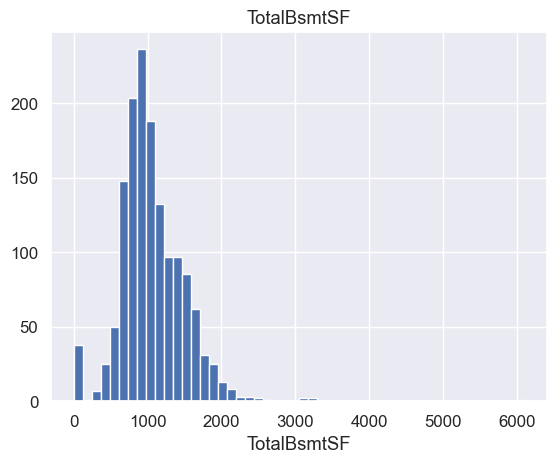

#####################################
count   1460.000
mean    1162.627
std      386.588
min      334.000
5%       672.950
10%      756.900
20%      848.000
30%      915.700
40%     1000.200
50%     1087.000
60%     1182.000
70%     1314.000
80%     1482.400
90%     1680.000
95%     1831.250
99%     2219.460
max     4692.000
Name: 1stFlrSF, dtype: float64


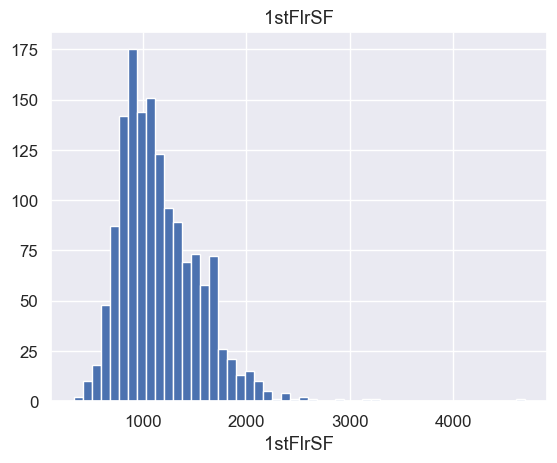

#####################################
count   1460.000
mean     346.992
std      436.528
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      455.400
70%      672.000
80%      796.200
90%      954.200
95%     1141.050
99%     1418.920
max     2065.000
Name: 2ndFlrSF, dtype: float64


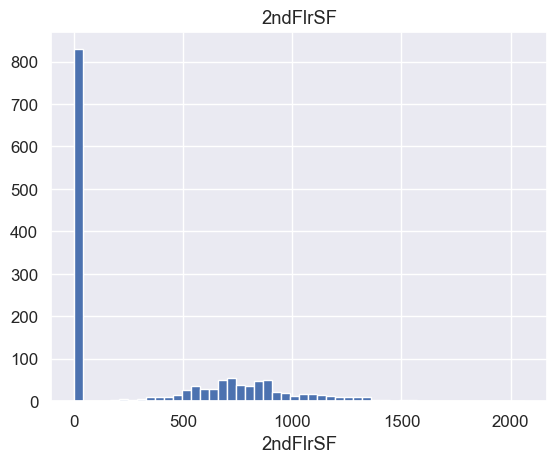

#####################################
count   1460.000
mean       5.845
std       48.623
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      360.000
max      572.000
Name: LowQualFinSF, dtype: float64


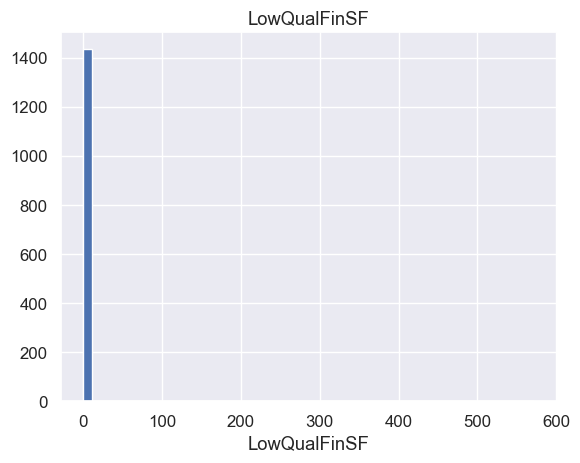

#####################################
count   1460.000
mean    1515.464
std      525.480
min      334.000
5%       848.000
10%      912.000
20%     1066.600
30%     1208.000
40%     1339.000
50%     1464.000
60%     1578.000
70%     1709.300
80%     1869.000
90%     2158.300
95%     2466.100
99%     3123.480
max     5642.000
Name: GrLivArea, dtype: float64


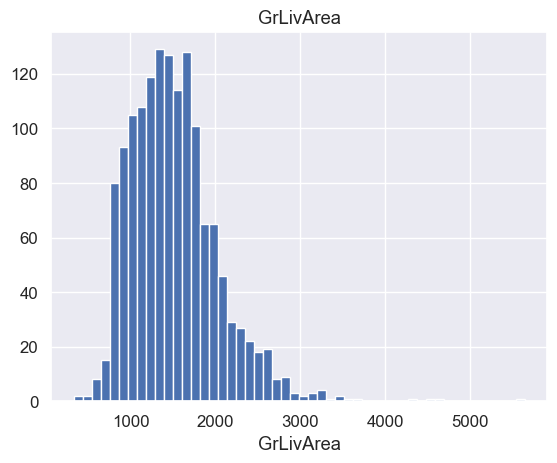

#####################################
count   1460.000
mean       6.518
std        1.625
min        2.000
5%         4.000
10%        5.000
20%        5.000
30%        6.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%        9.000
95%       10.000
99%       11.000
max       14.000
Name: TotRmsAbvGrd, dtype: float64


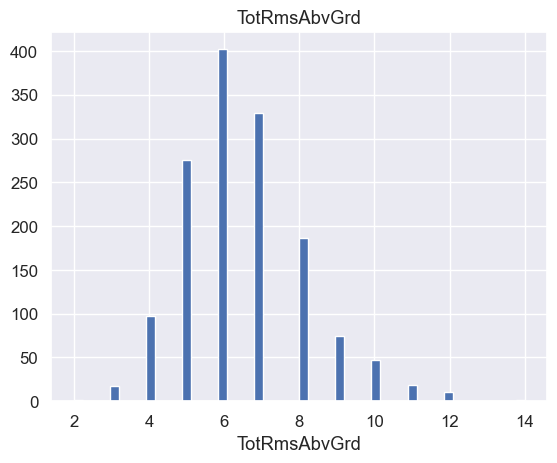

#####################################
count   1379.000
mean    1978.506
std       24.690
min     1900.000
5%      1930.000
10%     1945.000
20%     1957.000
30%     1965.000
40%     1973.000
50%     1980.000
60%     1993.000
70%     1999.000
80%     2004.000
90%     2006.000
95%     2007.000
99%     2009.000
max     2010.000
Name: GarageYrBlt, dtype: float64


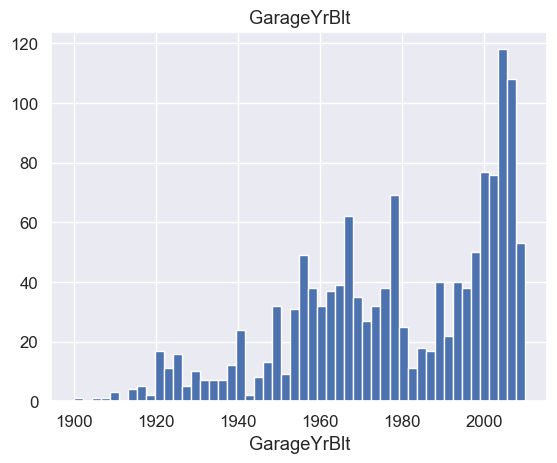

#####################################
count   1460.000
mean     472.980
std      213.805
min        0.000
5%         0.000
10%      240.000
20%      295.600
30%      384.000
40%      440.000
50%      480.000
60%      516.000
70%      560.000
80%      620.200
90%      757.100
95%      850.100
99%     1002.790
max     1418.000
Name: GarageArea, dtype: float64


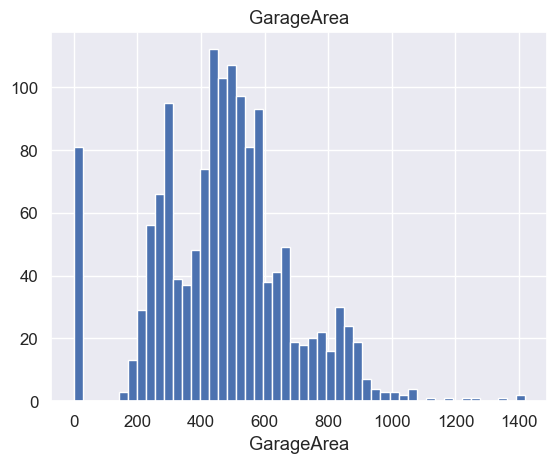

#####################################
count   1460.000
mean      94.245
std      125.339
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      100.000
70%      144.000
80%      192.000
90%      262.000
95%      335.000
99%      505.460
max      857.000
Name: WoodDeckSF, dtype: float64


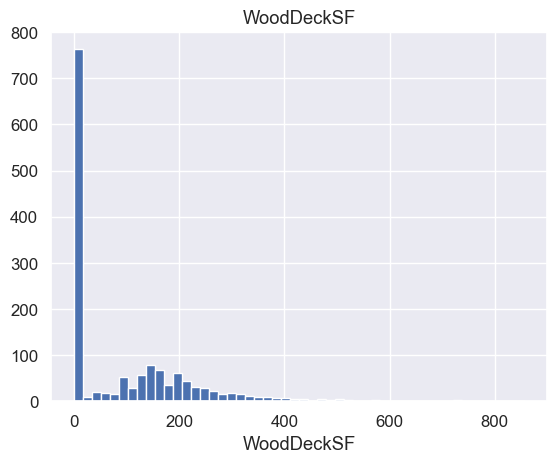

#####################################
count   1460.000
mean      46.660
std       66.256
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%       25.000
60%       40.000
70%       57.000
80%       83.200
90%      130.000
95%      175.050
99%      285.820
max      547.000
Name: OpenPorchSF, dtype: float64


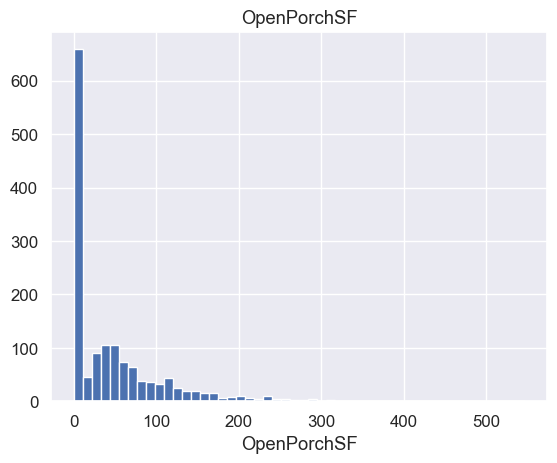

#####################################
count   1460.000
mean      21.954
std       61.119
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      112.000
95%      180.150
99%      261.050
max      552.000
Name: EnclosedPorch, dtype: float64


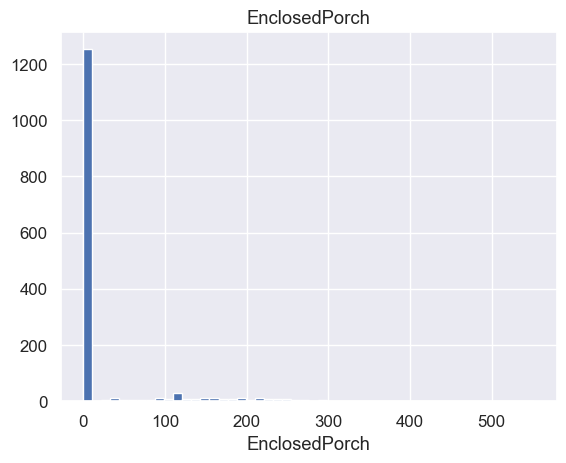

#####################################
count   1460.000
mean       3.410
std       29.317
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      168.000
max      508.000
Name: 3SsnPorch, dtype: float64


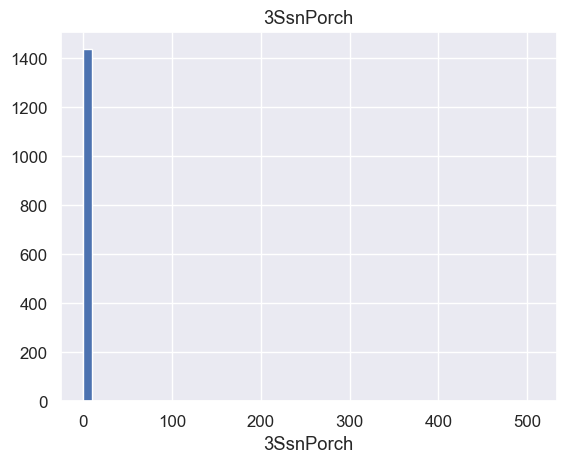

#####################################
count   1460.000
mean      15.061
std       55.757
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%      160.000
99%      268.050
max      480.000
Name: ScreenPorch, dtype: float64


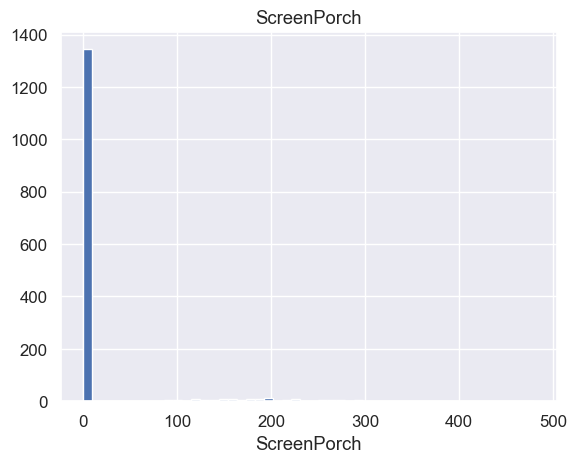

#####################################
count   1460.000
mean       2.759
std       40.177
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%        0.000
max      738.000
Name: PoolArea, dtype: float64


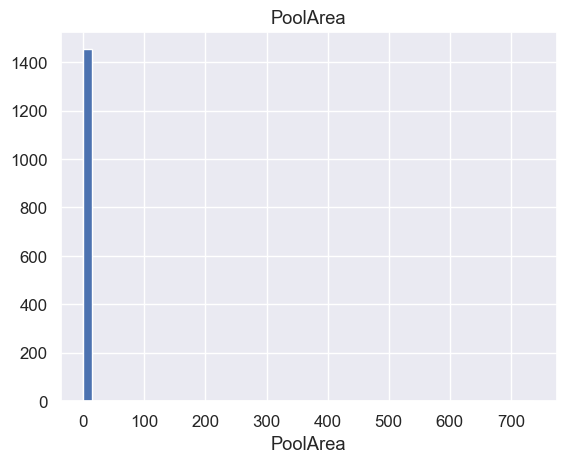

#####################################
count    1460.000
mean       43.489
std       496.123
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%       700.000
max     15500.000
Name: MiscVal, dtype: float64


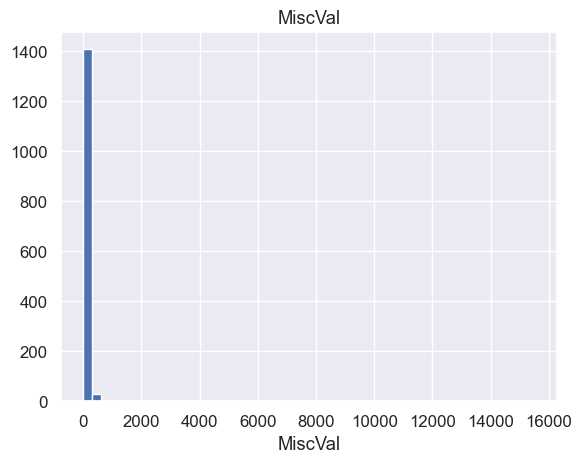

#####################################
count   1460.000
mean       6.322
std        2.704
min        1.000
5%         2.000
10%        3.000
20%        4.000
30%        5.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%       10.000
95%       11.000
99%       12.000
max       12.000
Name: MoSold, dtype: float64


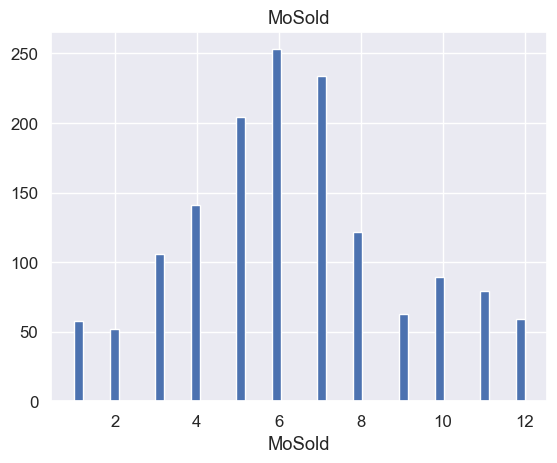

#####################################
count     1460.000
mean    180921.196
std      79442.503
min      34900.000
5%       88000.000
10%     106475.000
20%     124000.000
30%     135500.000
40%     147000.000
50%     163000.000
60%     179280.000
70%     198620.000
80%     230000.000
90%     278000.000
95%     326100.000
99%     442567.010
max     755000.000
Name: SalePrice, dtype: float64


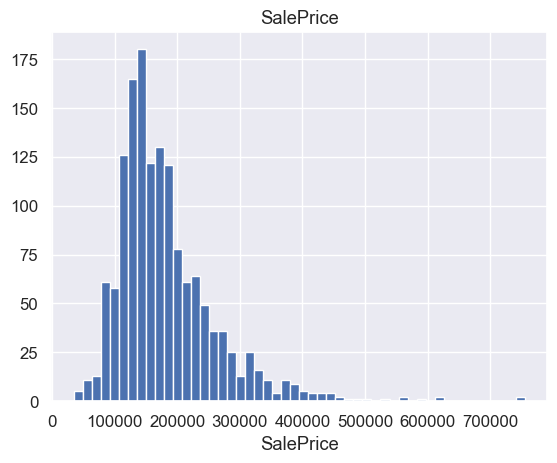

#####################################


In [128]:
for col in num_cols_eda:
    num_summary(df_train, col, True)

C:\Users\BORA\AppData\Local\Temp\ipykernel_19320\2468316399.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y1, kde=False, fit=stats.norm)
C:\Users\BORA\AppData\Local\Temp\ipykernel_19320\2468316399.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y1, kde=False, fit=stats.lognorm)


<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

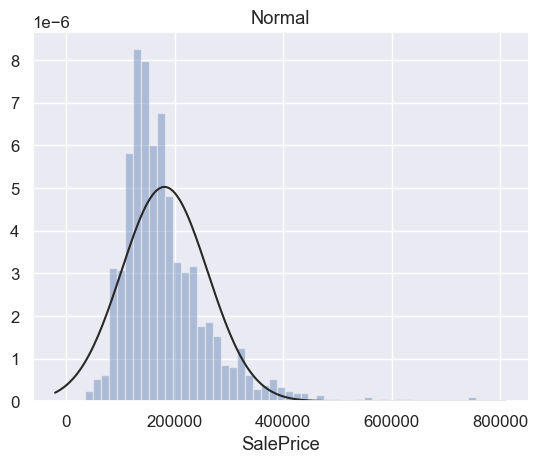

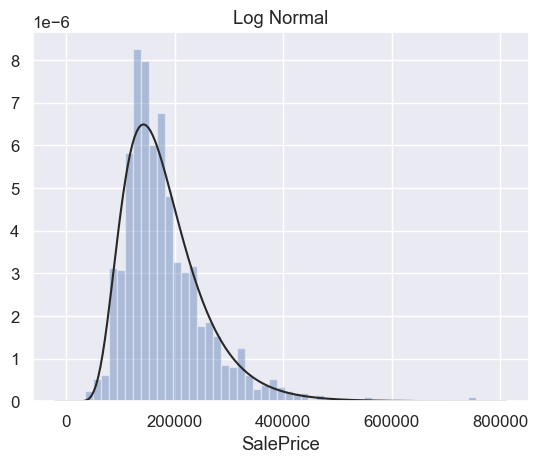

In [129]:
y1 = df_train['SalePrice']
plt.figure(2); plt.title('Normal')
sns.distplot(y1, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y1, kde=False, fit=stats.lognorm)

In [130]:
#Log Transform
y = np.log(df_copy["SalePrice"])

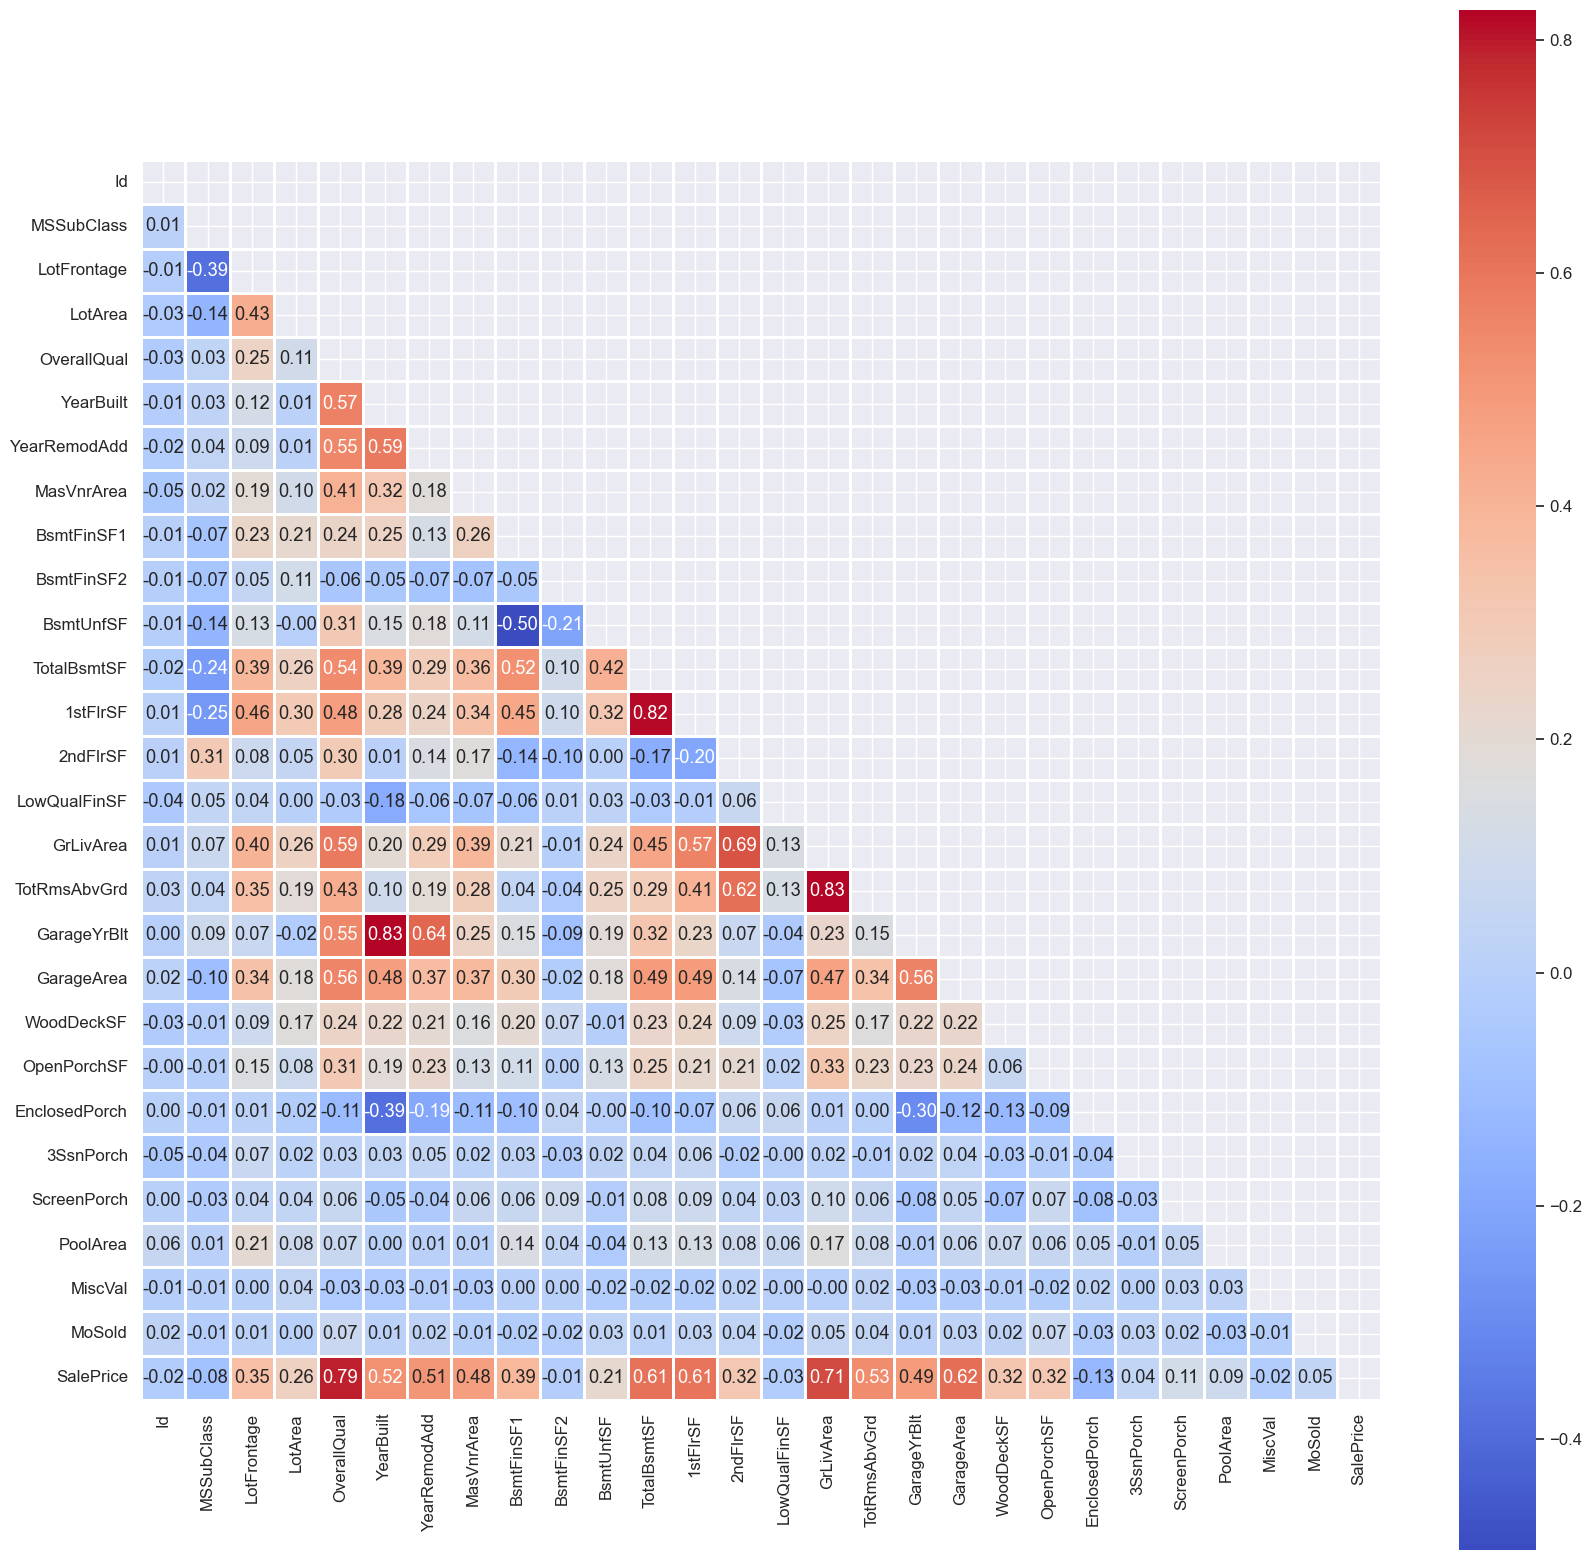

In [131]:
sns.set(font_scale=1.1)
corr_train = df_train[num_cols_eda].corr()
mask = np.triu(corr_train.corr())
plt.figure(figsize=(20, 20))
sns.heatmap(corr_train, annot=True, fmt='.2f', cmap='coolwarm', square=True, mask=mask, linewidth=1, cbar=True)
plt.show()

## Grabbing Columns (NUM - CAT)

In [132]:
cols_with_na_meaning = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                            'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']

In [133]:
for col in cols_with_na_meaning:
    df_copy[col].fillna("None",inplace=True)

In [134]:
encoding = {
    'None': 0,
    'Po': 1, 'No': 1, 'Unf': 1, 'Sal': 1, 'MnWw': 1,
    'Fa': 2, 'Mn': 2, 'LwQ': 2, 'Sev': 2, 'RFn': 2, 'GdWo': 2,
    'TA': 3, 'Av': 3, 'Rec': 3, 'Maj2': 3, 'Fin': 3, 'MnPrv': 3,
    'Gd': 4, 'BLQ': 4, 'Maj1': 4, 'GdPrv': 4,
    'Ex': 5, 'ALQ': 5, 'Mod': 5,
    'GLQ': 6, 'Min2': 6,
    'Min1': 7,
    'Typ': 8,
}

# Kodlamayı uygulayacağımız sütunlar listesi
columns_to_encode = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                     'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']

# Kodlamayı uygulama
for column in columns_to_encode:
    df_copy[column] = df_copy[column].map(encoding)

In [135]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_copy)

Observations: 2919
Variables: 80
cat_cols: 52
num_cols: 27
cat_but_car: 1
num_but_cat: 26


In [136]:
print(cat_cols)
print('-----------------------')

print(num_cols)
print('-----------------------')

print(cat_but_car)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'YrSold']
-----------------------
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'Ope

In [137]:
known_num_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars', 'OverallCond', 'YrSold']

In [138]:
for col in known_num_cols:
    if num_cols.__contains__(col) == False:
        num_cols.append(col)
        cat_cols.remove(col)

for col in columns_to_encode:
    if num_cols.__contains__(col) == False:
        num_cols.append(col)
        cat_cols.remove(col)

In [139]:
check_df(df_copy)

##################### Shape #####################
(2919, 80)
##################### Types #####################
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual          int64
ExterCond          int64
Foundation        object
BsmtQual           int64
BsmtCond           int64
BsmtExposure       int64
BsmtFinType1       int64
BsmtFinSF1       float64
BsmtFinType2       int64
BsmtFinSF2    

In [140]:
num_cols_without_target = [col for col in num_cols if col not in 'SalePrice']

In [141]:
df_copy[cat_cols] = df_copy[cat_cols].applymap(lambda x: x.replace(' ', '') if isinstance(x, str) else x)

C:\Users\BORA\AppData\Local\Temp\ipykernel_19320\17960946.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_copy[cat_cols] = df_copy[cat_cols].applymap(lambda x: x.replace(' ', '') if isinstance(x, str) else x)


## Suppressing Outliers of Numeric Columns

In [142]:
print(len(num_cols))

print(len(cat_cols))

print('*------------------------*')

for col in num_cols_without_target:
    print(col, check_outlier(df_copy, col))

for col in num_cols_without_target:
    replace_with_thresholds(df_copy, col)

print('------------------------')

for col in num_cols_without_target:
    print(col, check_outlier(df_copy, col))

print('*------------------------*')

53
26
*------------------------*
MSSubClass False
LotFrontage True
LotArea True
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea True
BsmtFinSF1 True
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
TotRmsAbvGrd False
GarageYrBlt True
GarageArea False
WoodDeckSF True
OpenPorchSF True
EnclosedPorch True
3SsnPorch True
ScreenPorch True
PoolArea True


C:\Users\BORA\AppData\Local\Temp\ipykernel_19320\4248212869.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-17759.35' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


MiscVal True
MoSold False
BsmtFullBath True
BsmtHalfBath False
FullBath True
HalfBath False
BedroomAbvGr True
KitchenAbvGr True
Fireplaces False
GarageCars False
OverallCond False
YrSold False
ExterQual False
ExterCond True
BsmtQual False
BsmtCond True
BsmtExposure False
BsmtFinType1 False
BsmtFinType2 False
HeatingQC False
KitchenQual False
Functional True
FireplaceQu False
GarageFinish False
GarageQual False
GarageCond False
PoolQC True
Fence False
------------------------

C:\Users\BORA\AppData\Local\Temp\ipykernel_19320\4248212869.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1864.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\BORA\AppData\Local\Temp\ipykernel_19320\4248212869.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1080.3999999999996' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
C:\Users\BORA\AppData\Local\Temp\ipykernel_19320\4248212869.py:117: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-1696.7999999999997' has dtype incompatible with int64, please explicitly cast to a compatibl


MSSubClass False
LotFrontage False
LotArea False
OverallQual False
YearBuilt False
YearRemodAdd False
MasVnrArea False
BsmtFinSF1 False
BsmtFinSF2 False
BsmtUnfSF False
TotalBsmtSF False
1stFlrSF False
2ndFlrSF False
LowQualFinSF False
GrLivArea False
TotRmsAbvGrd False
GarageYrBlt False
GarageArea False
WoodDeckSF False
OpenPorchSF False
EnclosedPorch False
3SsnPorch False
ScreenPorch False
PoolArea False
MiscVal False
MoSold False
BsmtFullBath False
BsmtHalfBath False
FullBath False
HalfBath False
BedroomAbvGr False
KitchenAbvGr False
Fireplaces False
GarageCars False
OverallCond False
YrSold False
ExterQual False
ExterCond False
BsmtQual False
BsmtCond False
BsmtExposure False
BsmtFinType1 False
BsmtFinType2 False
HeatingQC False
KitchenQual False
Functional False
FireplaceQu False
GarageFinish False
GarageQual False
GarageCond False
PoolQC False
Fence False
*------------------------*


## Dealing with Missing Values and Encoding

In [143]:
missing_df, missing_columns = missing_values_table(df_copy, True)

              n_miss  ratio
SalePrice       1459 49.980
LotFrontage      486 16.650
GarageYrBlt      159  5.450
MasVnrArea        23  0.790
MSZoning           4  0.140
BsmtFullBath       2  0.070
BsmtHalfBath       2  0.070
Functional         2  0.070
Utilities          2  0.070
Exterior2nd        1  0.030
BsmtFinSF1         1  0.030
BsmtFinSF2         1  0.030
BsmtUnfSF          1  0.030
TotalBsmtSF        1  0.030
Exterior1st        1  0.030
KitchenQual        1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
SaleType           1  0.030
Electrical         1  0.030


In [144]:
df_copy = quick_missing_imp_groupped(df_copy, cat_cols = cat_cols, num_cols = num_cols_without_target, missing_columns_df = missing_df)

# BEFORE
              n_miss  ratio
SalePrice       1459 49.980
LotFrontage      486 16.650
GarageYrBlt      159  5.450
MasVnrArea        23  0.790
MSZoning           4  0.140
BsmtFullBath       2  0.070
BsmtHalfBath       2  0.070
Functional         2  0.070
Utilities          2  0.070
Exterior2nd        1  0.030
BsmtFinSF1         1  0.030
BsmtFinSF2         1  0.030
BsmtUnfSF          1  0.030
TotalBsmtSF        1  0.030
Exterior1st        1  0.030
KitchenQual        1  0.030
GarageCars         1  0.030
GarageArea         1  0.030
SaleType           1  0.030
Electrical         1  0.030
# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

LotFrontage     0
GarageYrBlt     0
MasVnrArea      0
MSZoning        0
BsmtFullBath    0
BsmtHalfBath    0
Functional      0
Utilities       0
Exterior2nd     0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
Exterior1st     0
KitchenQual     0
GarageCars  

In [145]:
'''
# değişkenlerin standartlatırılması
scaler = StandardScaler()
df_copy[num_cols] = pd.DataFrame(scaler.fit_transform(df_copy[num_cols]))
df_copy.head()

imputer = KNNImputer(n_neighbors=5)
df_copy[num_cols] = pd.DataFrame(imputer.fit_transform(df_copy[num_cols]))
df_copy.head()

df_copy[num_cols] = pd.DataFrame(scaler.inverse_transform(df_copy[num_cols]))
'''

'\n# değişkenlerin standartlatırılması\nscaler = StandardScaler()\ndf_copy[num_cols] = pd.DataFrame(scaler.fit_transform(df_copy[num_cols]))\ndf_copy.head()\n\nimputer = KNNImputer(n_neighbors=5)\ndf_copy[num_cols] = pd.DataFrame(imputer.fit_transform(df_copy[num_cols]))\ndf_copy.head()\n\ndf_copy[num_cols] = pd.DataFrame(scaler.inverse_transform(df_copy[num_cols]))\n'

In [146]:
rare_analyser(df_copy, cat_cols)

MSZoning : 5
          COUNT  RATIO
MSZoning              
RL         2266  0.776
RM          463  0.159
FV          139  0.048
RH           26  0.009
C(all)       25  0.009


Street : 2
        COUNT  RATIO
Street              
Pave     2907  0.996
Grvl       12  0.004


Alley : 3
       COUNT  RATIO
Alley              
None    2721  0.932
Grvl     120  0.041
Pave      78  0.027


LotShape : 4
          COUNT  RATIO
LotShape              
Reg        1859  0.637
IR1         968  0.332
IR2          76  0.026
IR3          16  0.005


LandContour : 4
             COUNT  RATIO
LandContour              
Lvl           2622  0.898
HLS            120  0.041
Bnk            117  0.040
Low             60  0.021


Utilities : 2
           COUNT  RATIO
Utilities              
AllPub      2918  1.000
NoSeWa         1  0.000


LotConfig : 5
           COUNT  RATIO
LotConfig              
Inside      2133  0.731
Corner       511  0.175
CulDSac      176  0.060
FR2           85  0.029
FR3           14  

In [147]:
df_copy = rare_encoder(df_copy, 0.01)

In [148]:
df_copy["NEW_1st*GrLiv"] = df_copy["1stFlrSF"] * df_copy["GrLivArea"]

df_copy["NEW_Garage*GrLiv"] = (df_copy["GarageArea"] * df_copy["GrLivArea"])

df_copy["TotalQual"] = df_copy[["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
                      "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual", "GarageCond", "Fence", 'BsmtQual', 'BsmtExposure', 
                      'GarageFinish','PoolQC']].sum(axis = 1) # 42


# Total Floor
df_copy["NEW_TotalFlrSF"] = df_copy["1stFlrSF"] + df_copy["2ndFlrSF"] # 32

# Total Finished Basement Area
df_copy["NEW_TotalBsmtFin"] = df_copy.BsmtFinSF1 + df_copy.BsmtFinSF2 # 56

# Porch Area
df_copy["NEW_PorchArea"] = df_copy.OpenPorchSF + df_copy.EnclosedPorch + df_copy.ScreenPorch + df_copy["3SsnPorch"] + df_copy.WoodDeckSF # 93

# Total House Area
df_copy["NEW_TotalHouseArea"] = df_copy.NEW_TotalFlrSF + df_copy.TotalBsmtSF # 156

df_copy["NEW_TotalSqFeet"] = df_copy.GrLivArea + df_copy.TotalBsmtSF # 35


# Lot Ratio
df_copy["NEW_LotRatio"] = df_copy.GrLivArea / df_copy.LotArea # 64

df_copy["NEW_RatioArea"] = df_copy.NEW_TotalHouseArea / df_copy.LotArea # 57

df_copy["NEW_GarageLotRatio"] = df_copy.GarageArea / df_copy.LotArea # 69

# MasVnrArea
df_copy["NEW_MasVnrRatio"] = df_copy.MasVnrArea / df_copy.NEW_TotalHouseArea # 36

# Dif Area
df_copy["NEW_DifArea"] = (df_copy.LotArea - df_copy["1stFlrSF"] - df_copy.GarageArea - df_copy.NEW_PorchArea - df_copy.WoodDeckSF) # 73


df_copy["NEW_OverallGrade"] = df_copy["OverallQual"] * df_copy["OverallCond"] # 61


df_copy["NEW_Restoration"] = np.where(df_copy["YearRemodAdd"] < df_copy["YearBuilt"], 0, df_copy["YearRemodAdd"] - df_copy["YearBuilt"])

df_copy["NEW_HouseAge"] = np.where(df_copy["YrSold"] < df_copy["YearBuilt"], 0, df_copy["YrSold"] - df_copy["YearBuilt"])

df_copy["NEW_RestorationAge"] = np.where(df_copy["YrSold"] < df_copy["YearRemodAdd"], 0, df_copy["YrSold"] - df_copy["YearRemodAdd"])

df_copy["NEW_GarageAge"] = np.abs(df_copy.GarageYrBlt - df_copy.YearBuilt) # 17

df_copy["NEW_GarageRestorationAge"] = np.abs(df_copy.GarageYrBlt - df_copy.YearRemodAdd) # 30

df_copy["NEW_GarageSold"] = np.where(df_copy["YrSold"] < df_copy["GarageYrBlt"], 0, df_copy["YrSold"] - df_copy["GarageYrBlt"])


df_copy["NEW_TotalBaths"] = df_copy["FullBath"] + df_copy["BsmtFullBath"] + 0.5*(df_copy["HalfBath"]+df_copy["BsmtHalfBath"])


df_copy['NEW_HasPool'] = df_copy['PoolArea'].apply(lambda x: 1 if x > 0 else 0)


df_copy['NEW_Has2ndFloor'] = df_copy['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)


df_copy['NEW_HasGarage'] = df_copy['GarageCars'].apply(lambda x: 1 if x > 0 else 0)


df_copy['NEW_HasBsmt'] = df_copy['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)


df_copy['NEW_HasFireplace'] = df_copy['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


df_copy['NEW_HasPorch'] = df_copy['NEW_PorchArea'].apply(lambda x: 1 if x > 0 else 0)

new_num_features = ['NEW_1st*GrLiv', 'NEW_Garage*GrLiv', 'TotalQual', 'NEW_TotalFlrSF', 'NEW_TotalBsmtFin', 'NEW_PorchArea', 'NEW_TotalHouseArea', 'NEW_TotalSqFeet',
                 'NEW_LotRatio', 'NEW_RatioArea', 'NEW_GarageLotRatio', 'NEW_MasVnrRatio', 'NEW_DifArea', 'NEW_OverallGrade', 'NEW_Restoration', 'NEW_HouseAge', 
                 'NEW_RestorationAge',  'NEW_GarageAge',  'NEW_GarageRestorationAge',  'NEW_GarageSold', 'NEW_TotalBaths']

new_cat_features = ['NEW_HasPool', 'NEW_Has2ndFloor', 'NEW_HasGarage',
                 'NEW_HasBsmt', 'NEW_HasFireplace', 'NEW_HasPorch']

#drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

In [149]:
num_cols.extend(new_num_features)
cat_cols.extend(new_cat_features)

## Data Transform & Feature Scaling

### Data Transformation
By looking at the data we can say that "MSSubClass" and "YrSold" are Catagorical Variables, so we transform them into dtype : object

In [150]:
df_copy[["MSSubClass", "YrSold"]] = df_copy[["MSSubClass", "YrSold"]].astype("category") #converting into catagorical value

In [151]:
num_to_cat = ["MSSubClass", "YrSold"]

In [152]:
for col in num_to_cat:
    if cat_cols.__contains__(col) == False:
        cat_cols.append(col)
        num_cols.remove(col)

"MoSold" is a Cyclic Value. We handle this type of data by mapping each cyclical variable onto a circle such that the lowest value for that variable appears right next to the largest value. We compute the x- and y- component of that point using sine and cosin trigonometric functions.

In [153]:
df_copy["MoSoldsin"] = np.sin(2 * np.pi * df_copy["MoSold"] / 12) #Sine Function
df_copy["MoSoldcos"] = np.cos(2 * np.pi * df_copy["MoSold"] / 12) #Cosine Function
df_copy = df_copy.drop("MoSold", axis=1)

In [154]:
num_cols.append('MoSoldsin')
num_cols.append('MoSoldcos')
num_cols.remove('MoSold')

In [155]:
def log_plots(df, col):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df[col], bins=30, edgecolor='black', color='blue')
    plt.title('Original Data Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Step 3: Apply Log Transformation
    #df_copy[col] = np.log(df_copy[col] + 1e-6)

    # Step 4: Visualize Transformed Data Distribution
    plt.subplot(1, 2, 2)
    plt.hist(np.log1p(df[col]), bins=30, edgecolor='black', color='green')
    plt.title('Log-Transformed Data Distribution')
    plt.xlabel('Log('+ col +')')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

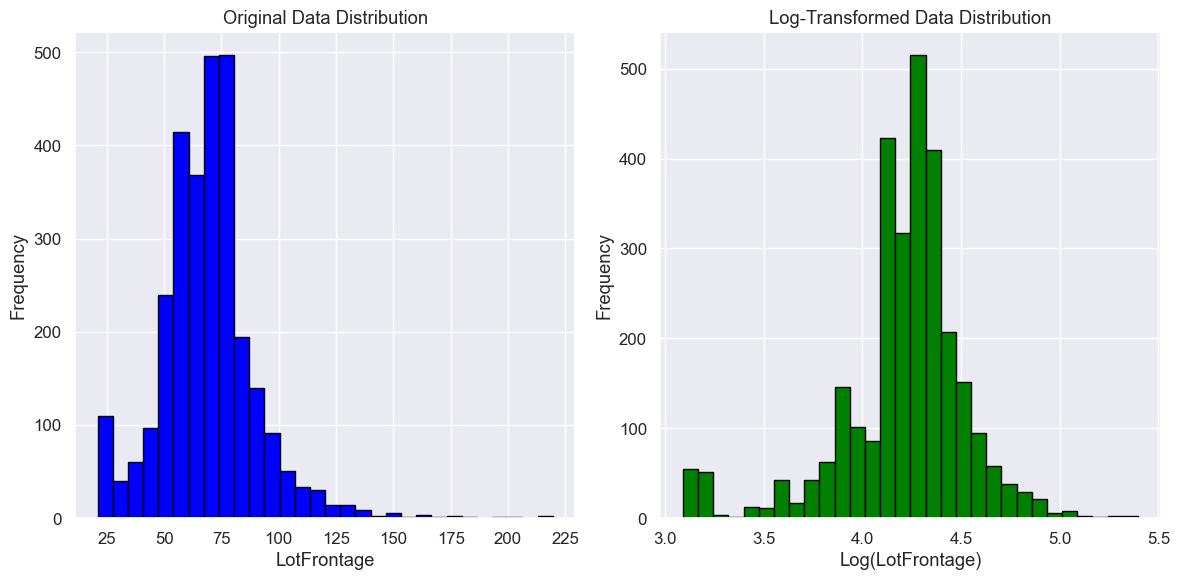

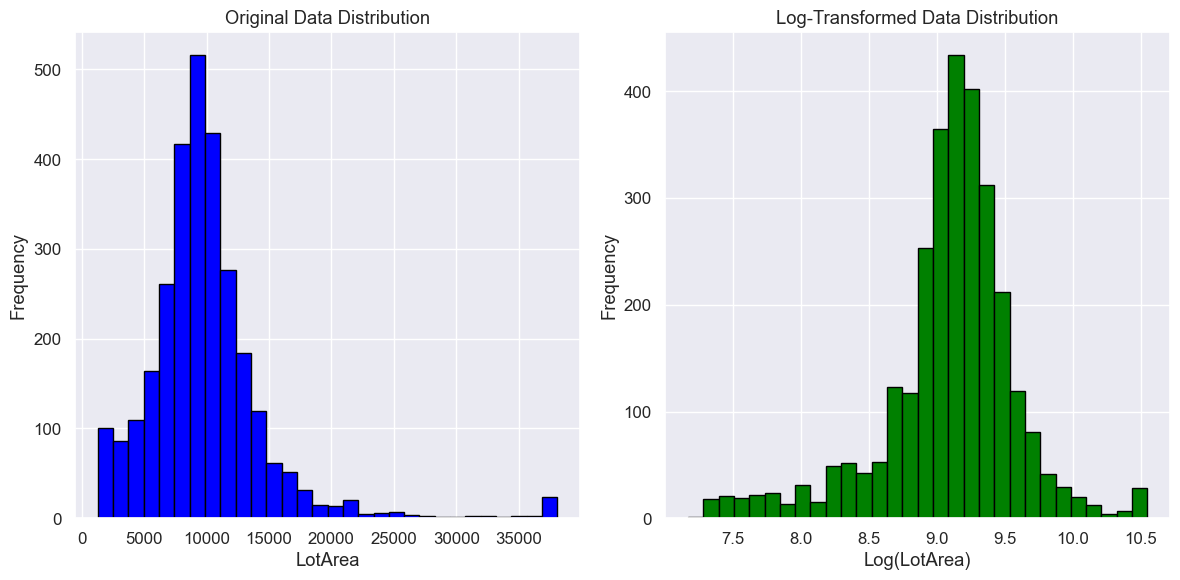

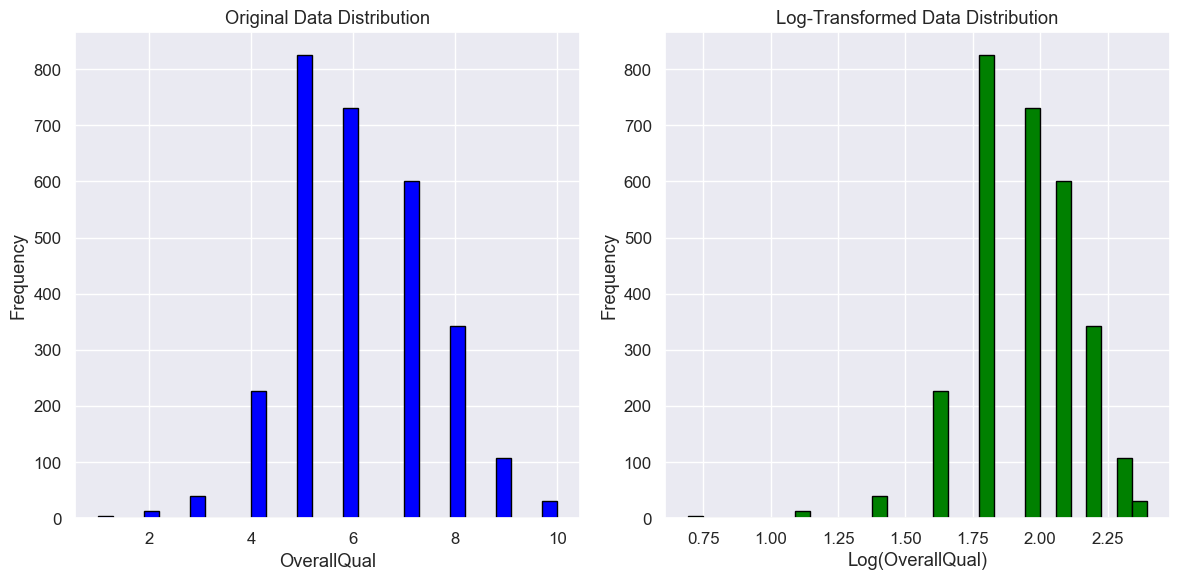

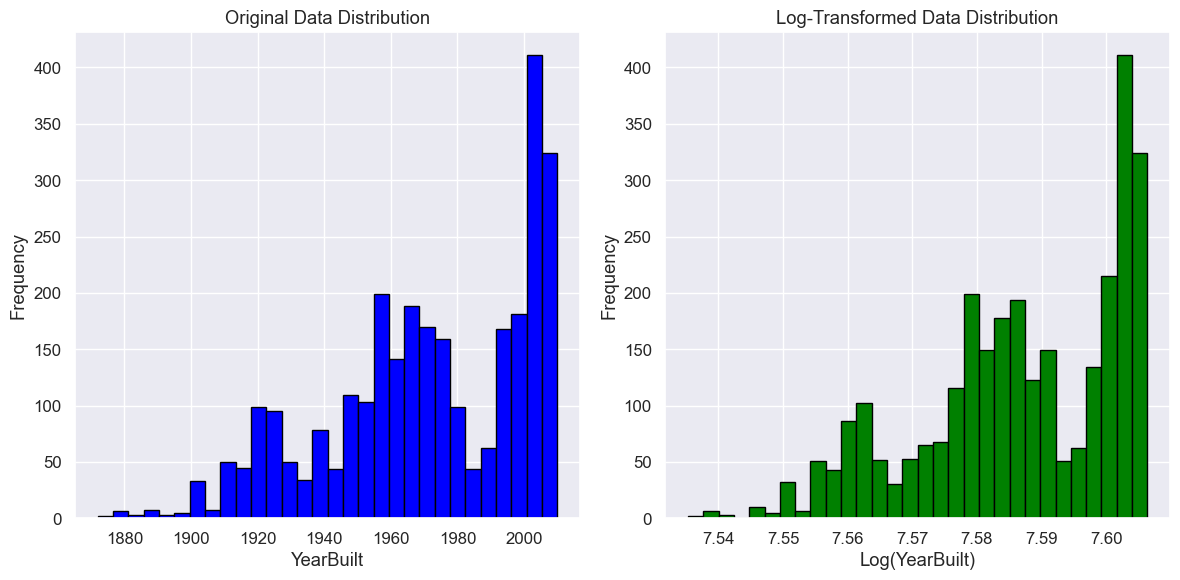

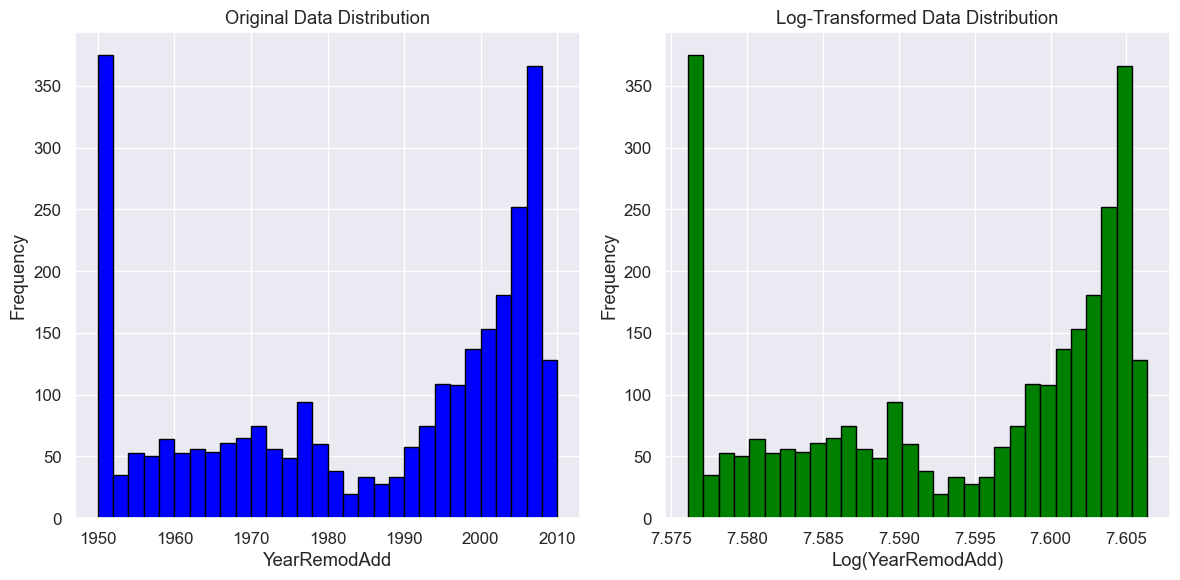

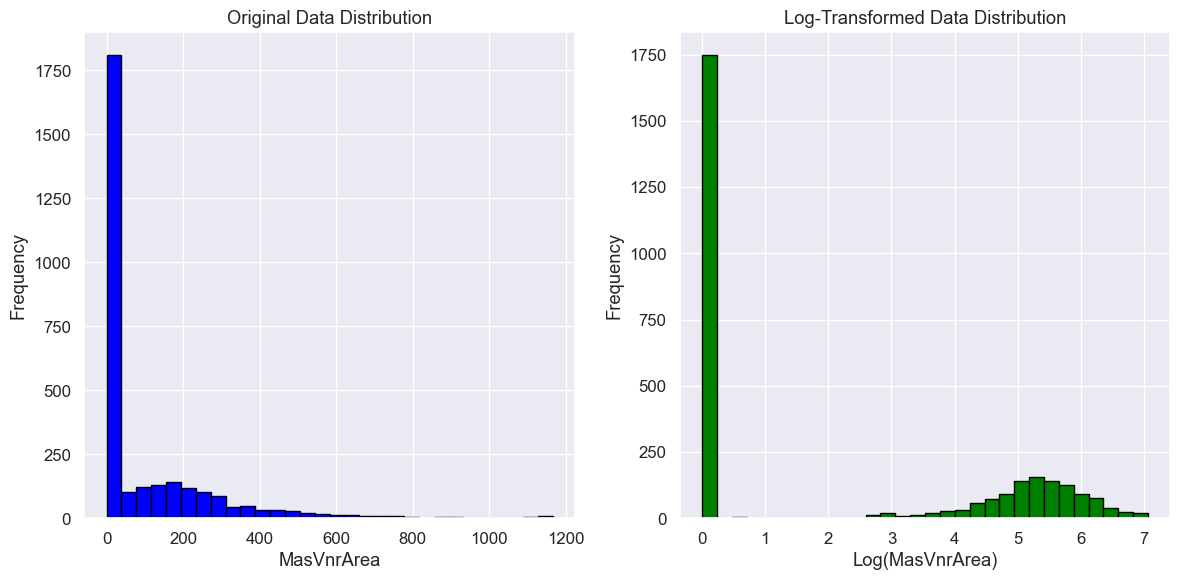

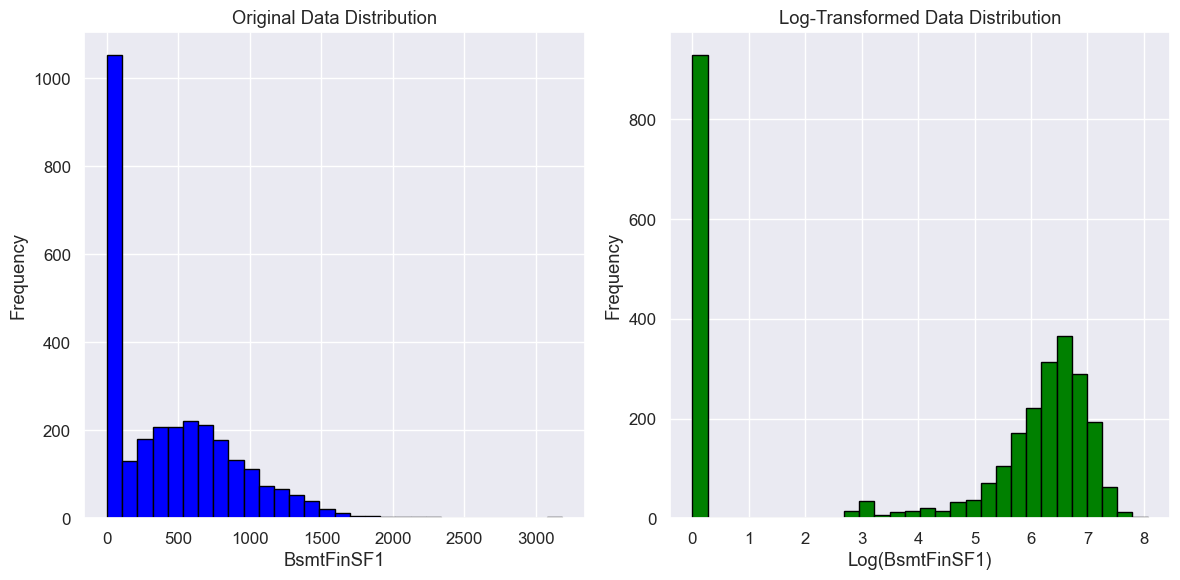

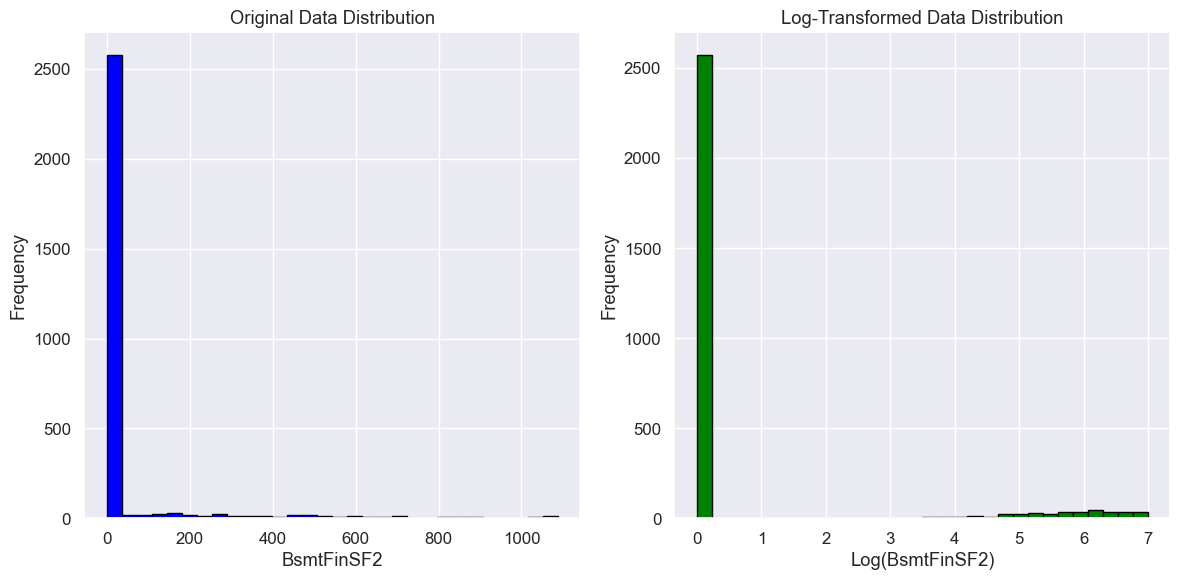

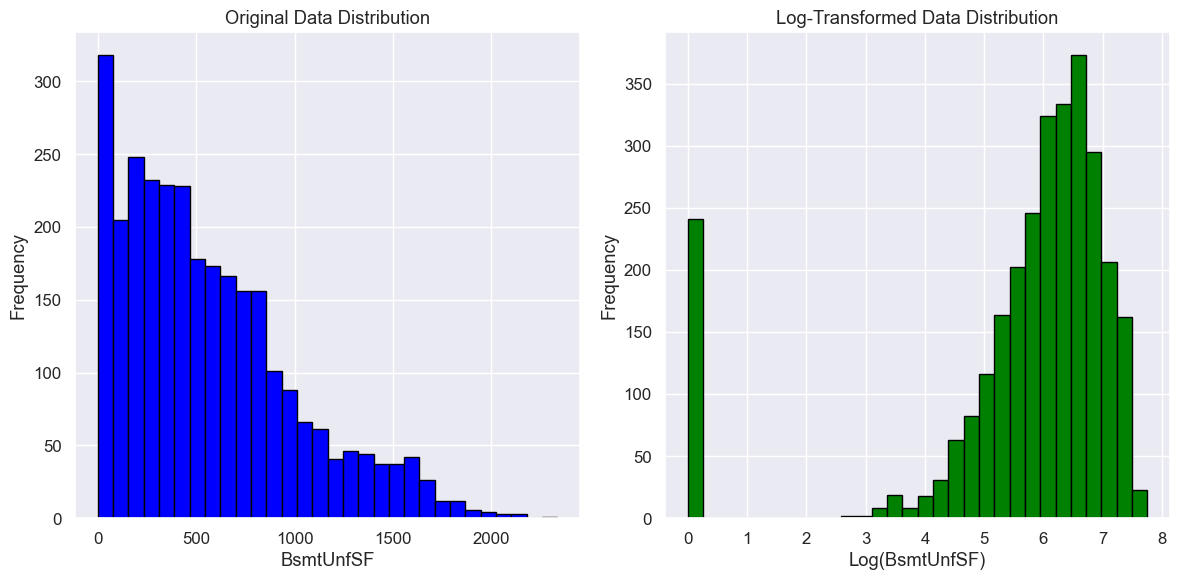

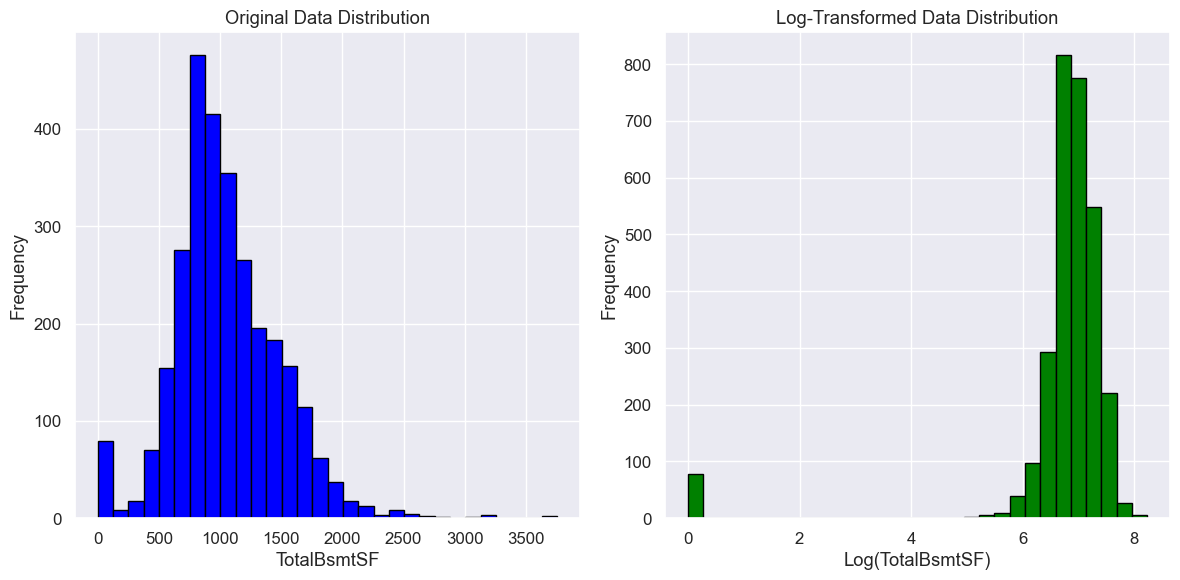

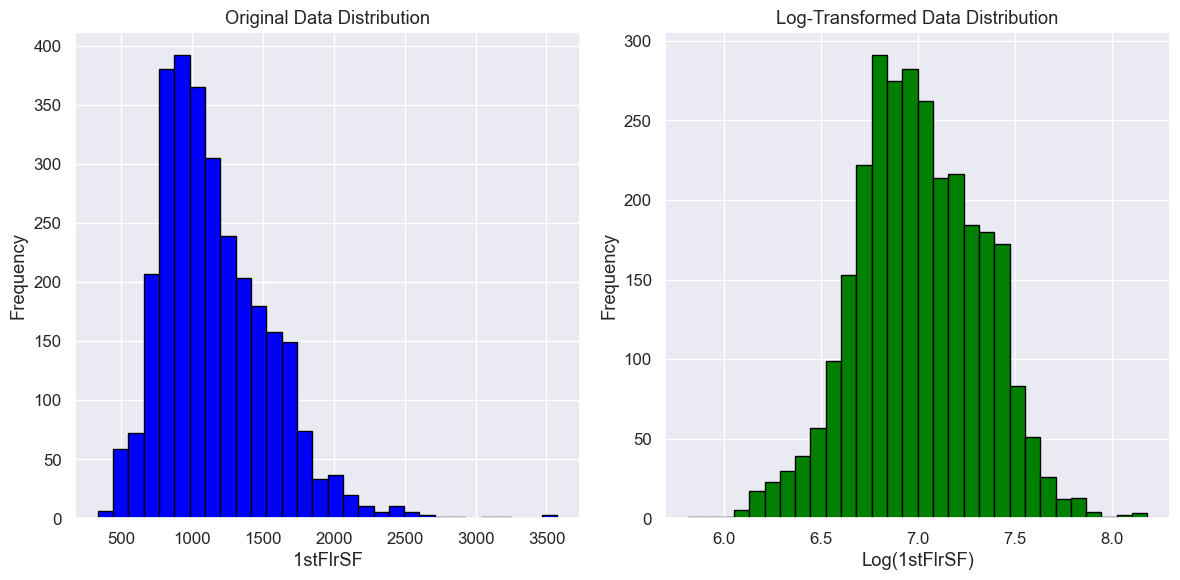

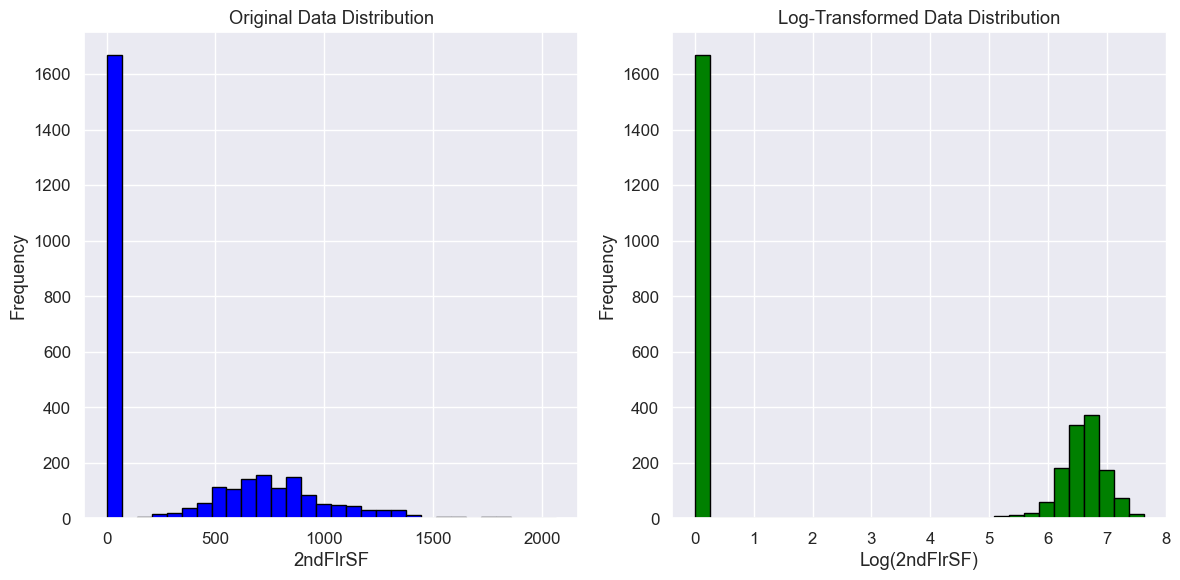

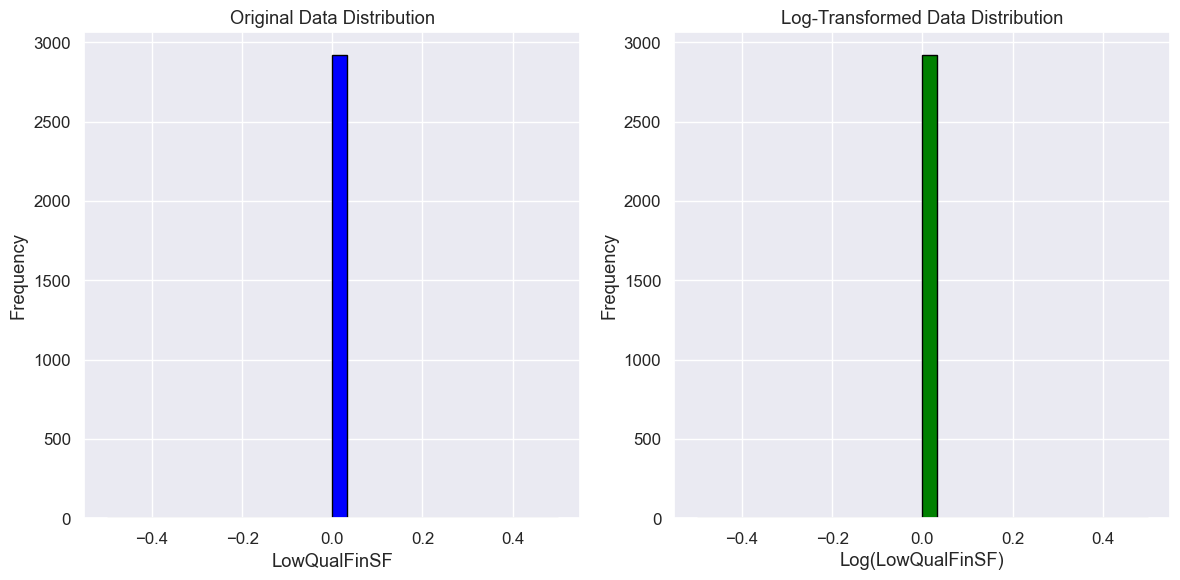

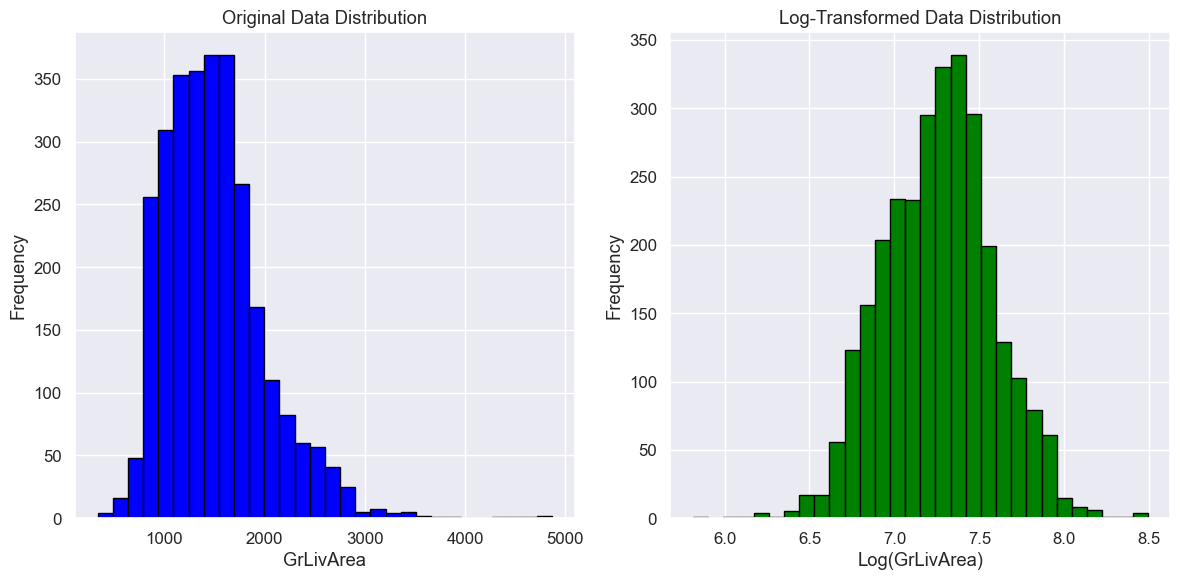

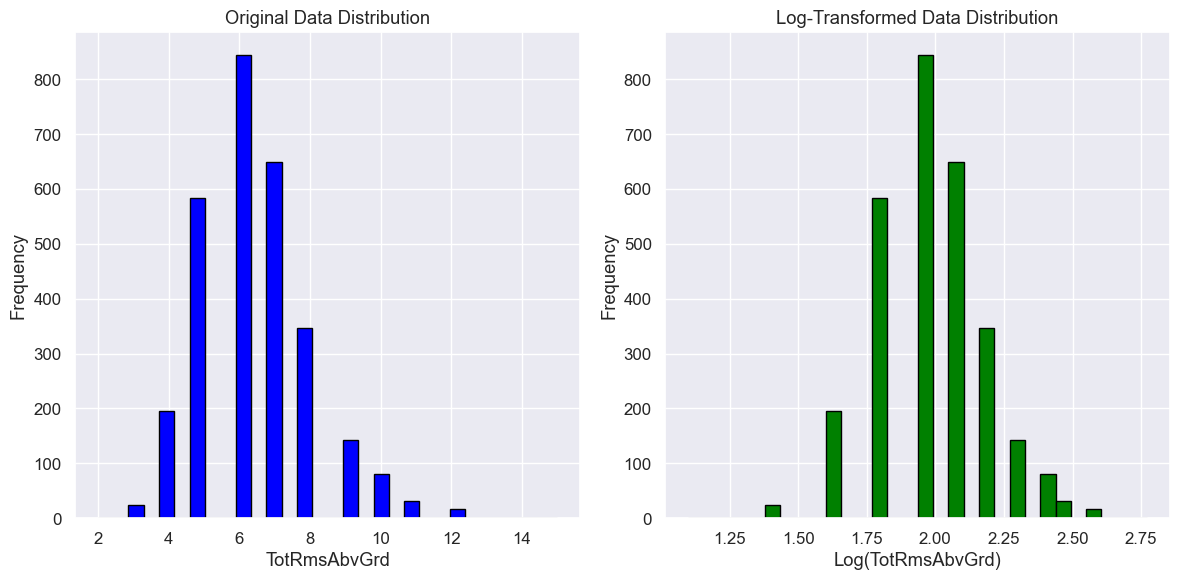

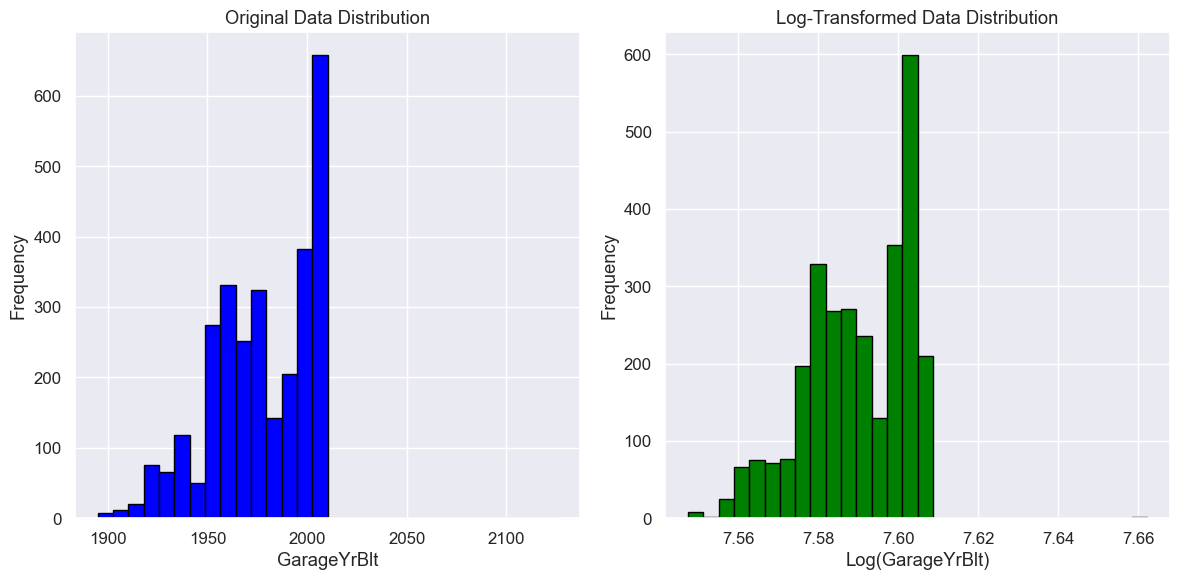

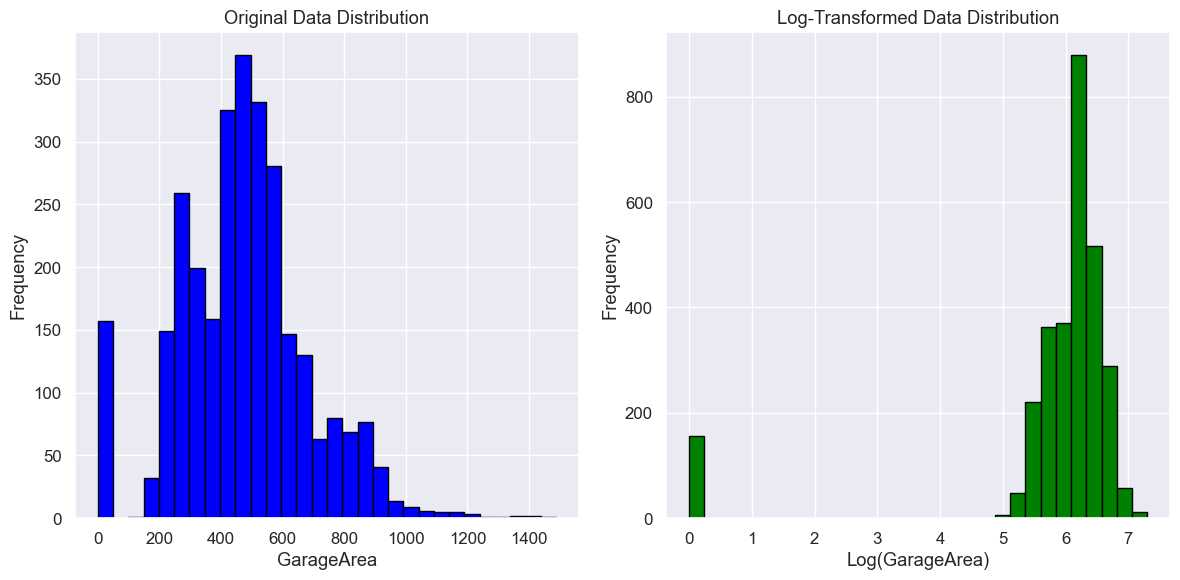

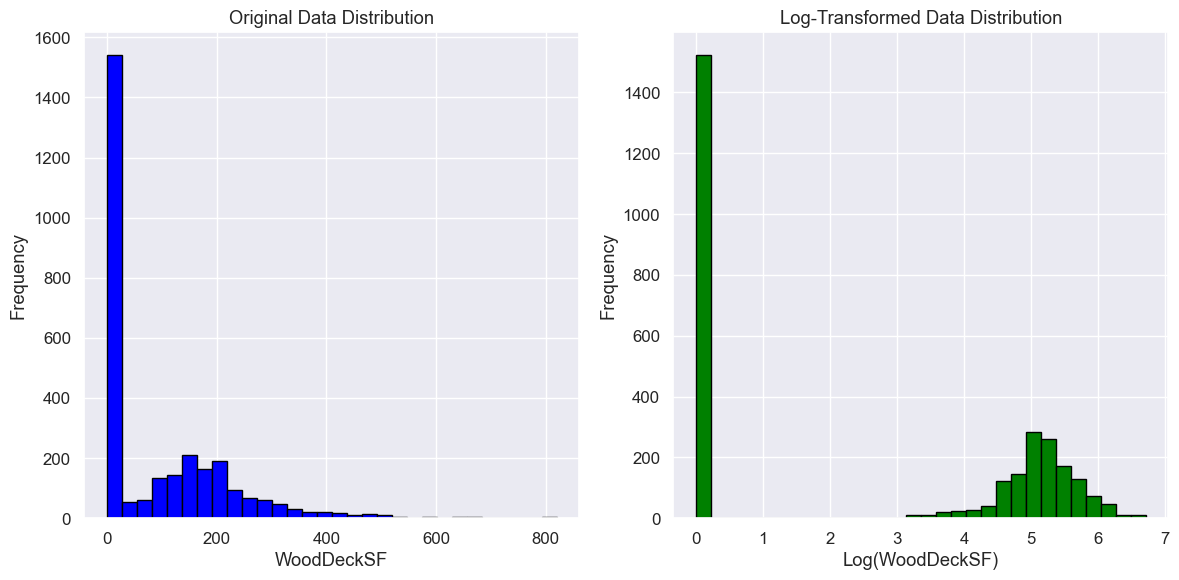

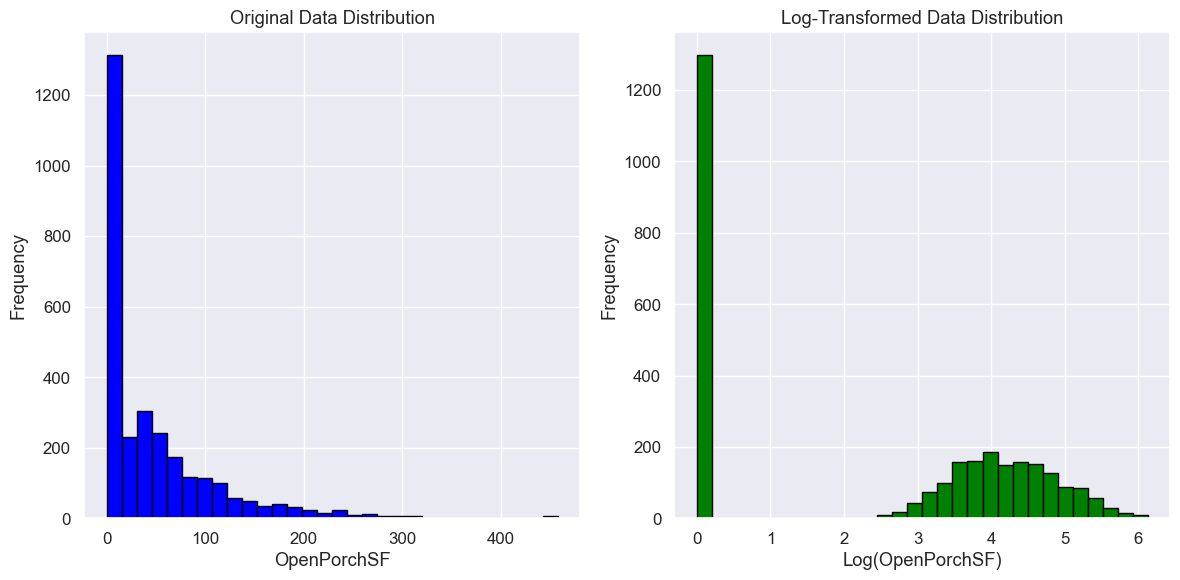

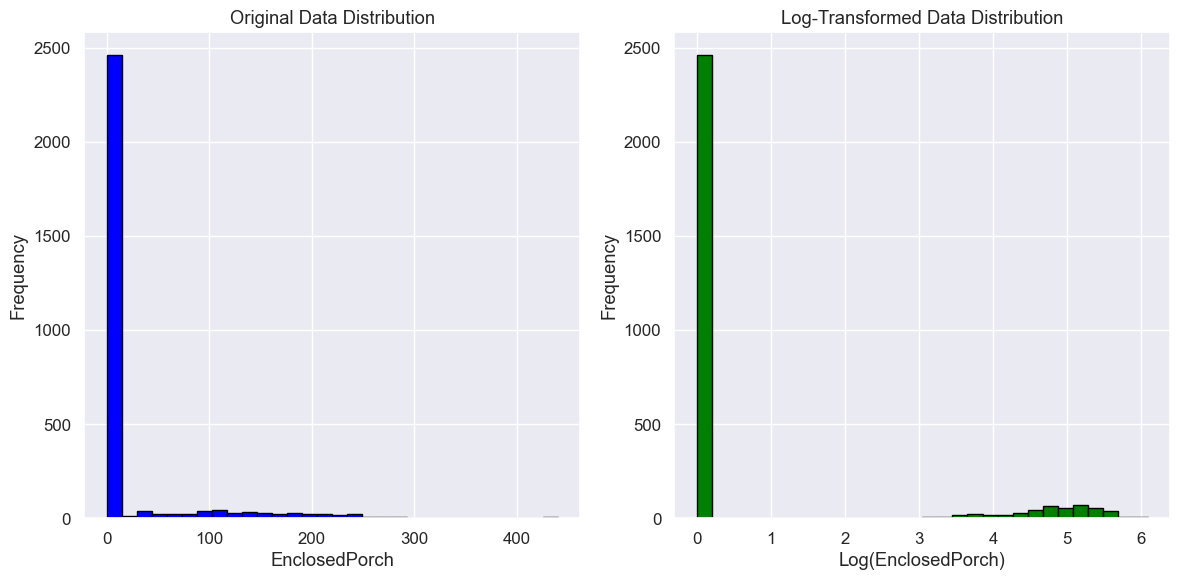

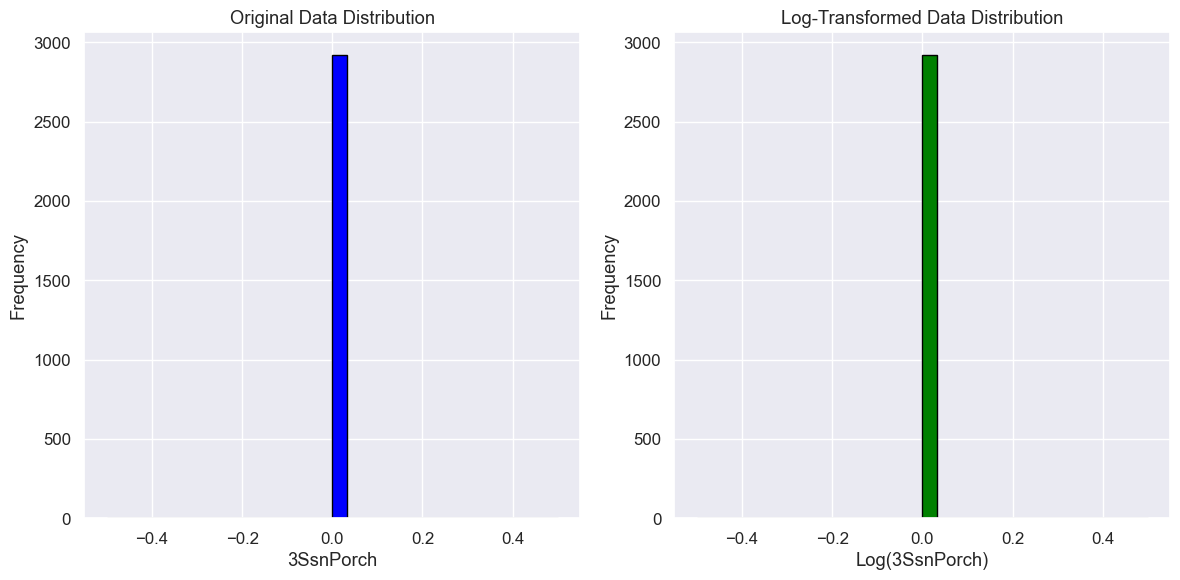

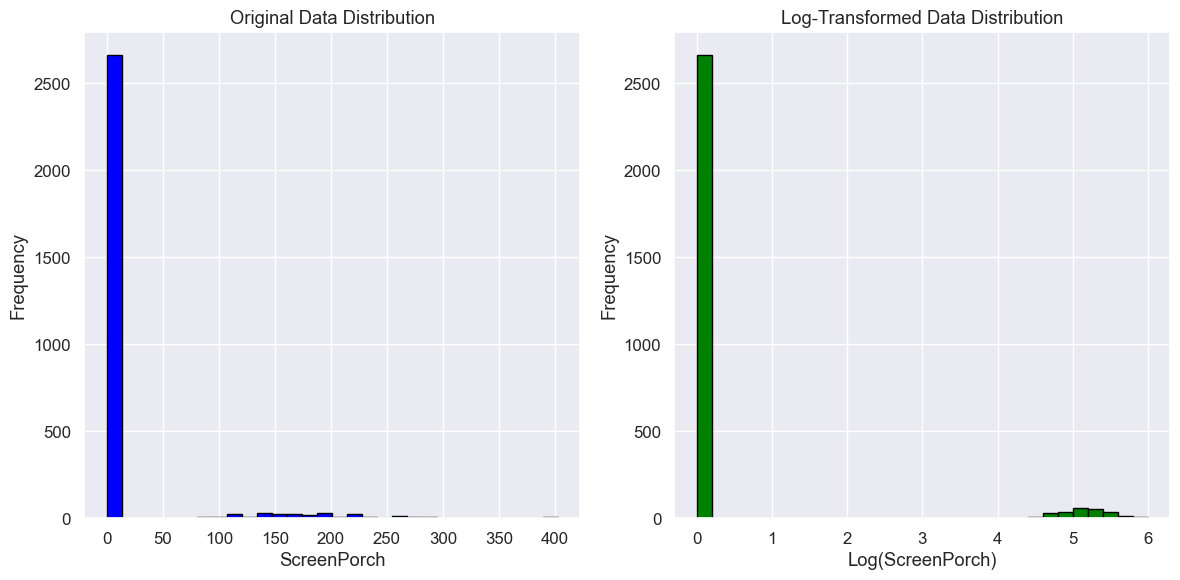

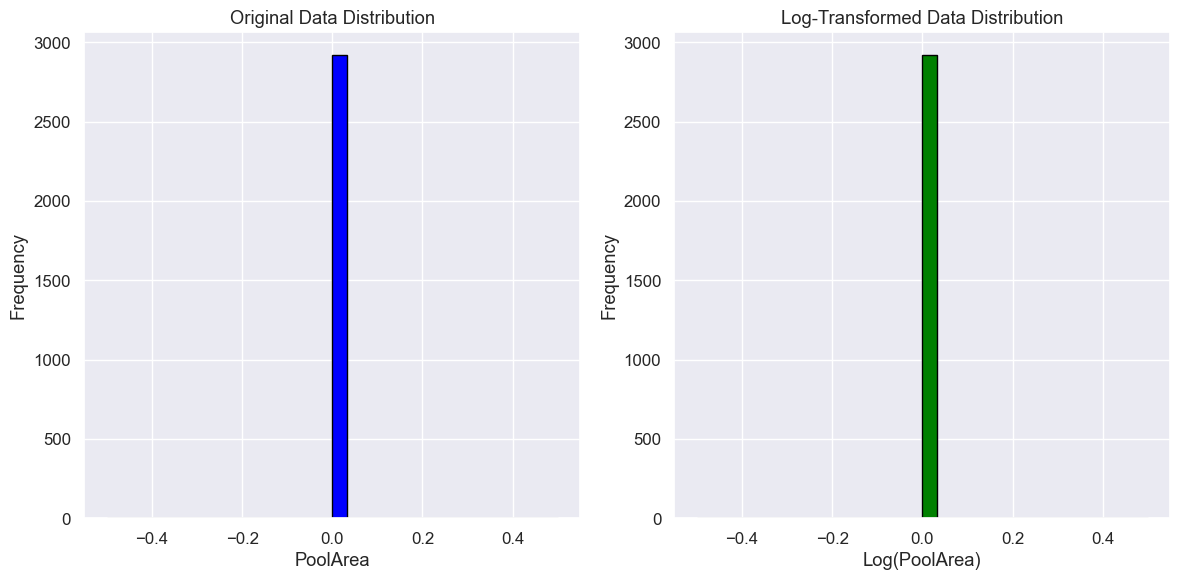

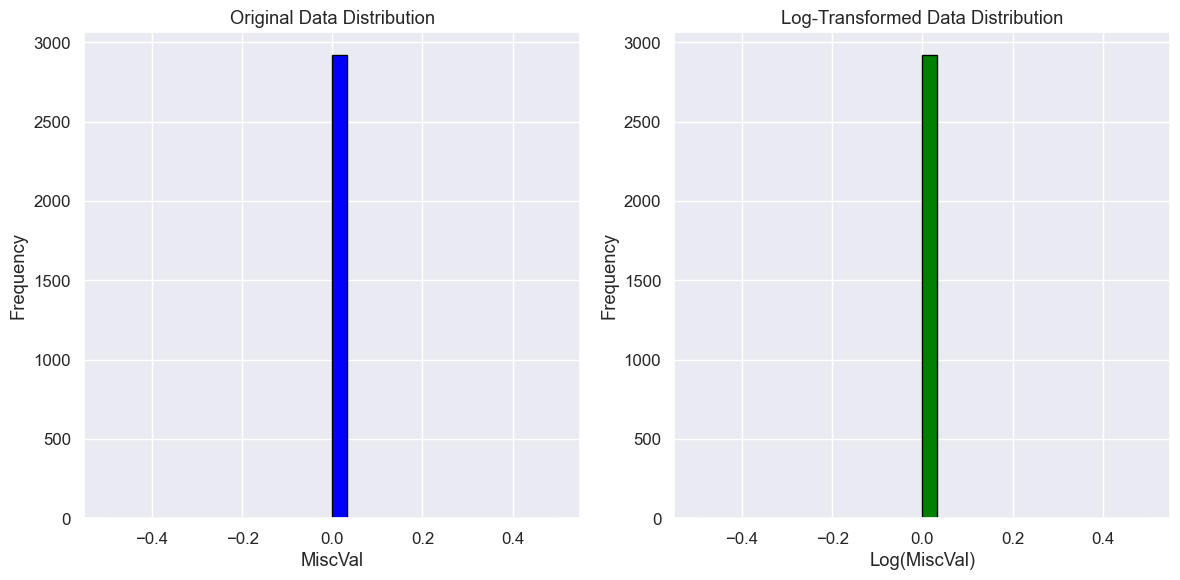

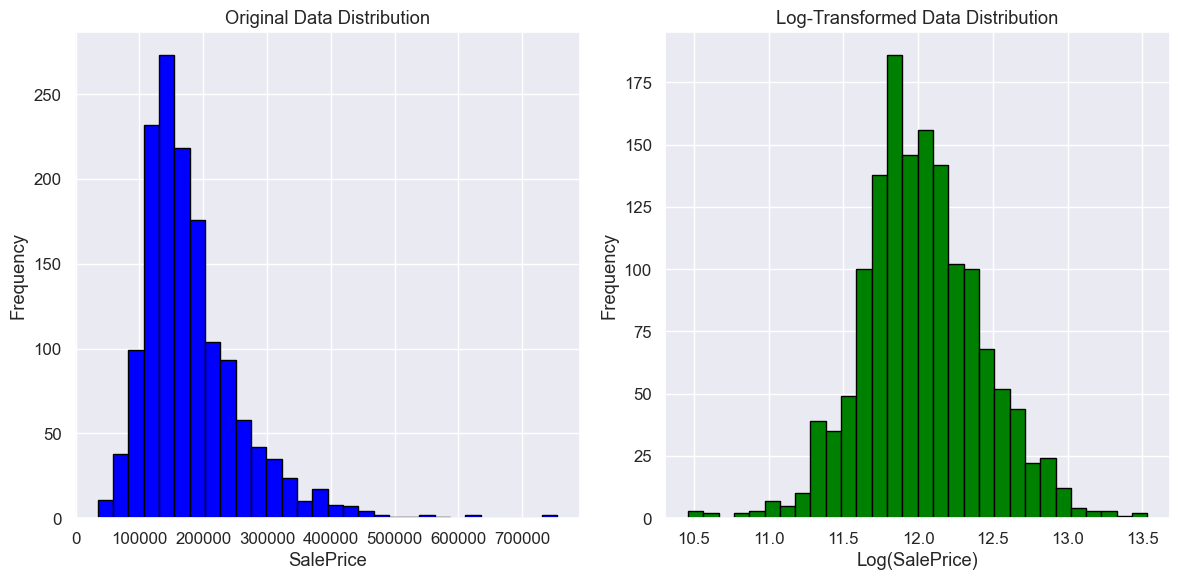

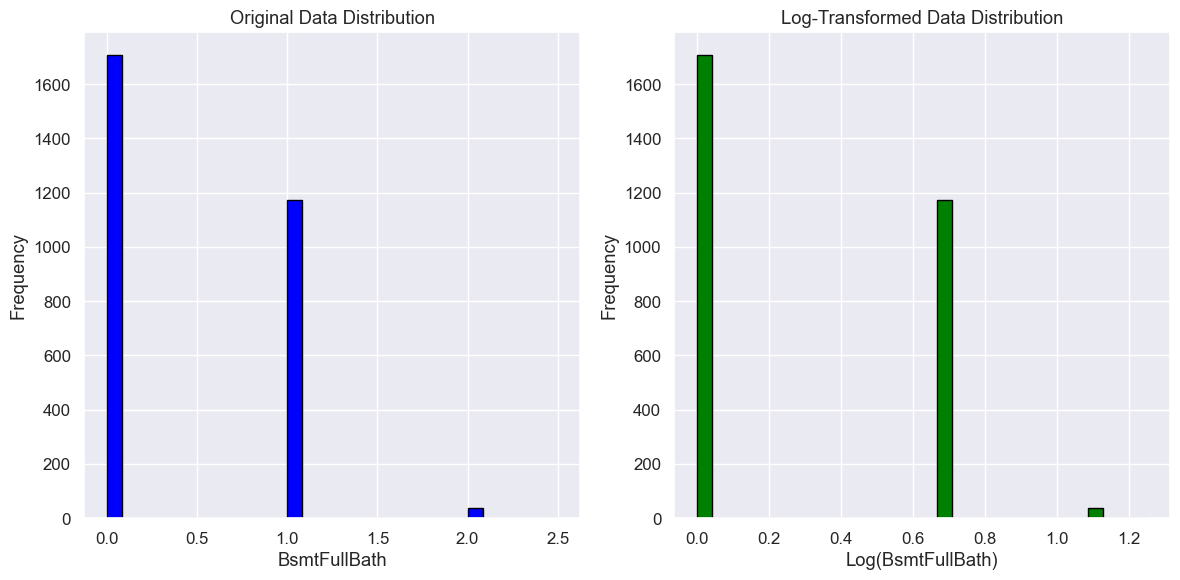

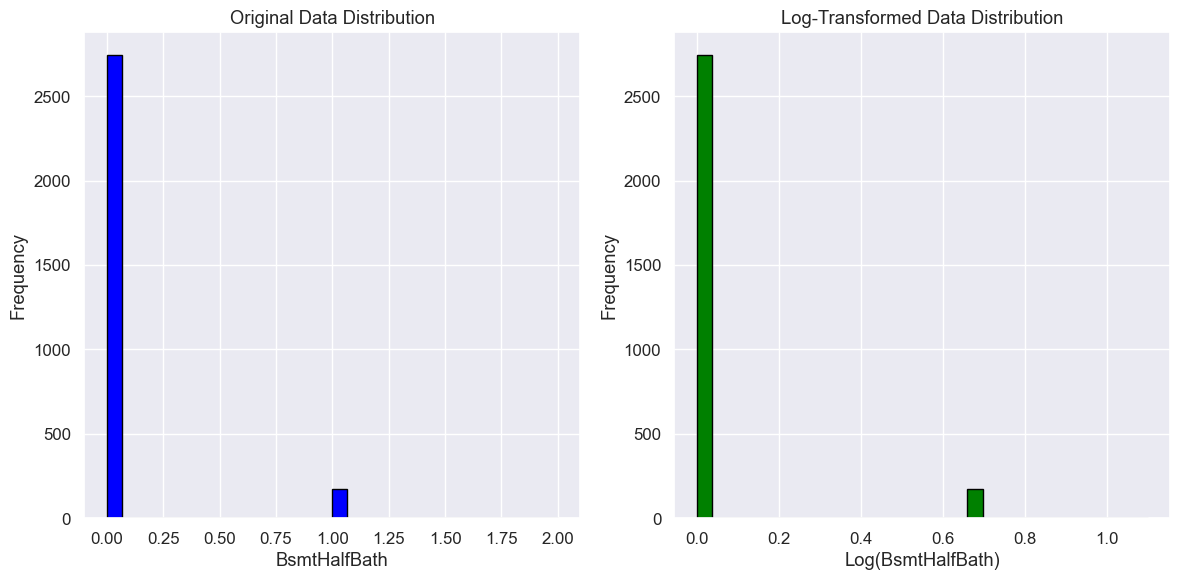

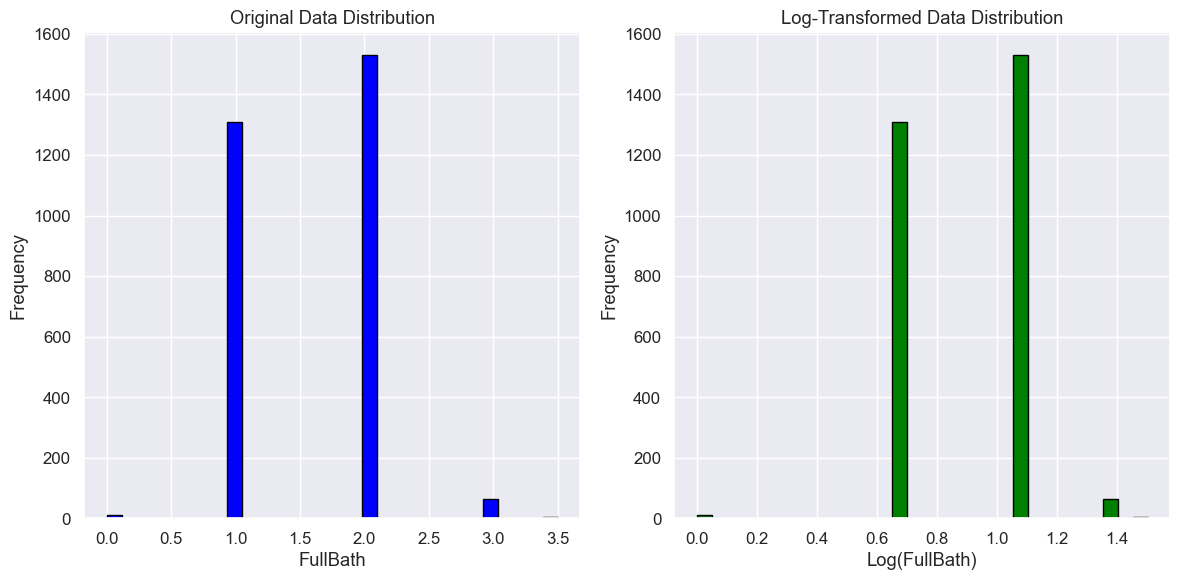

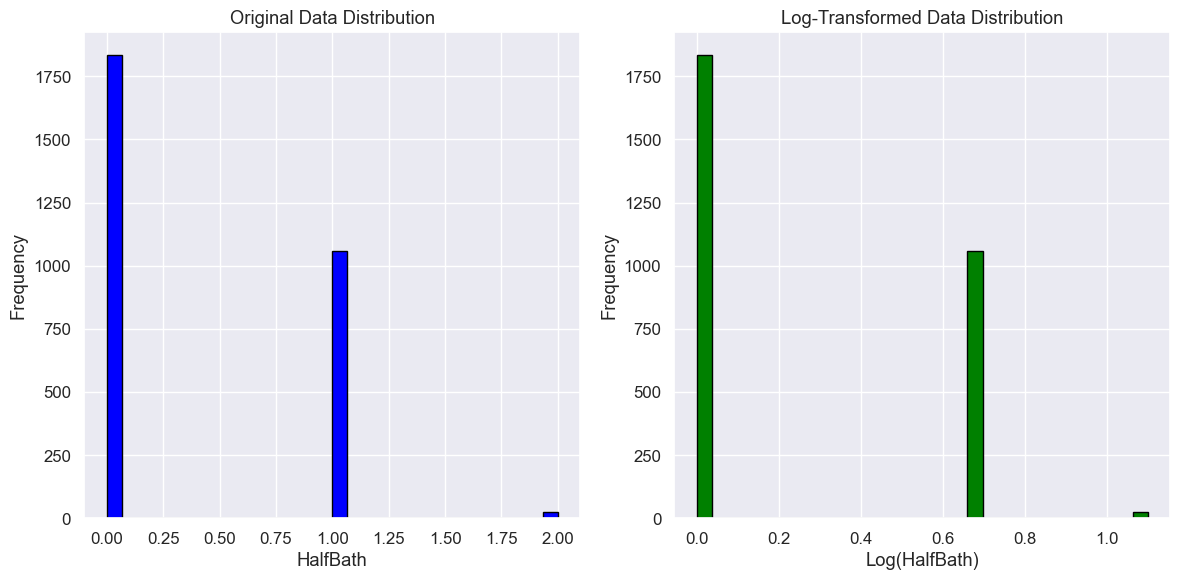

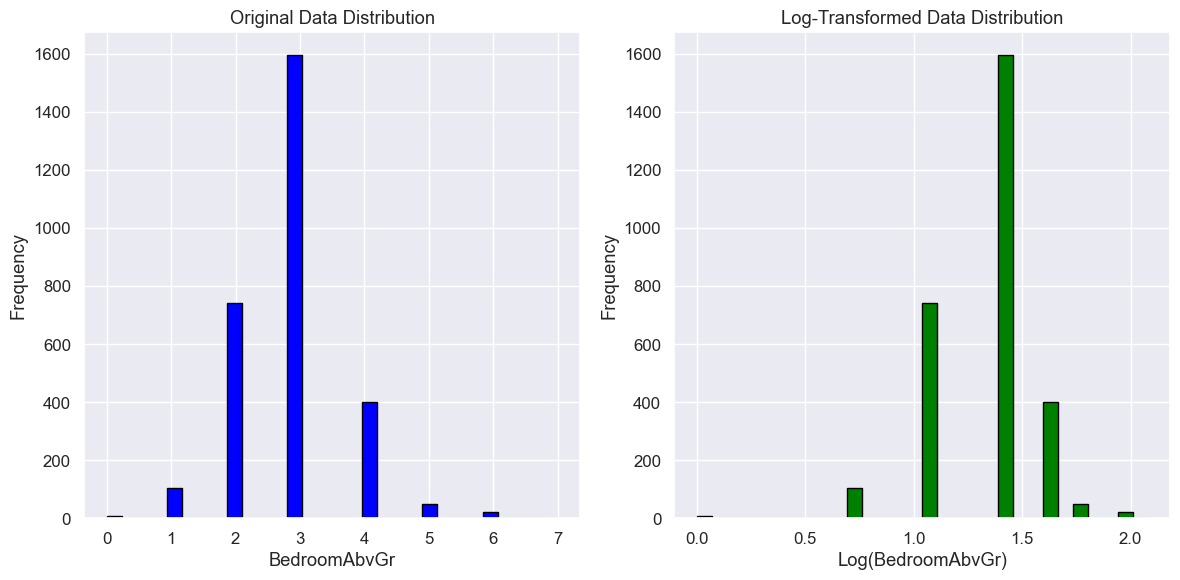

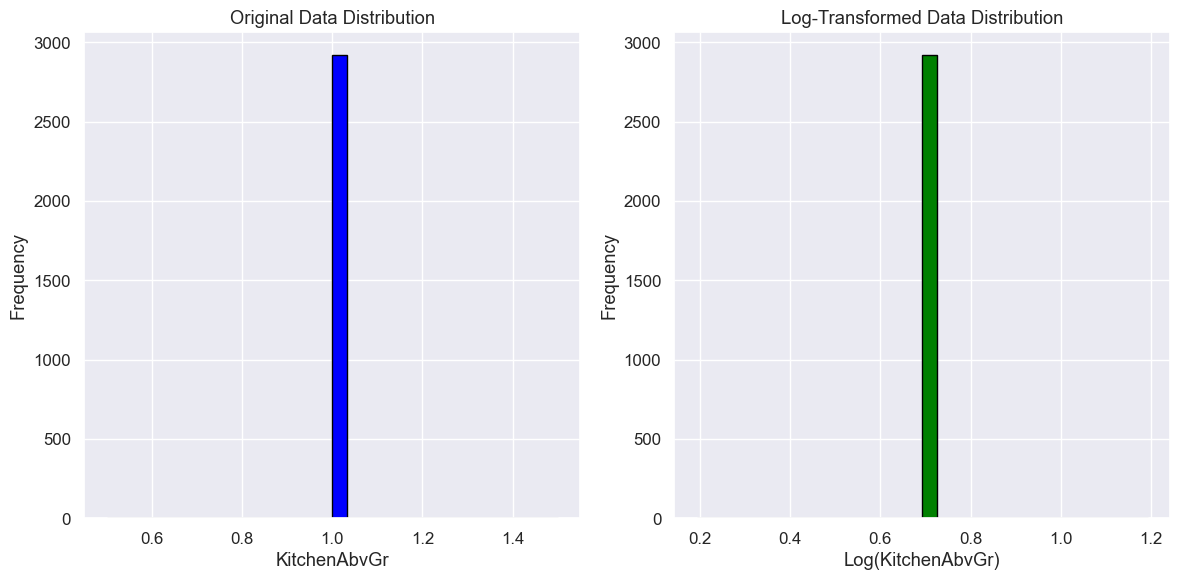

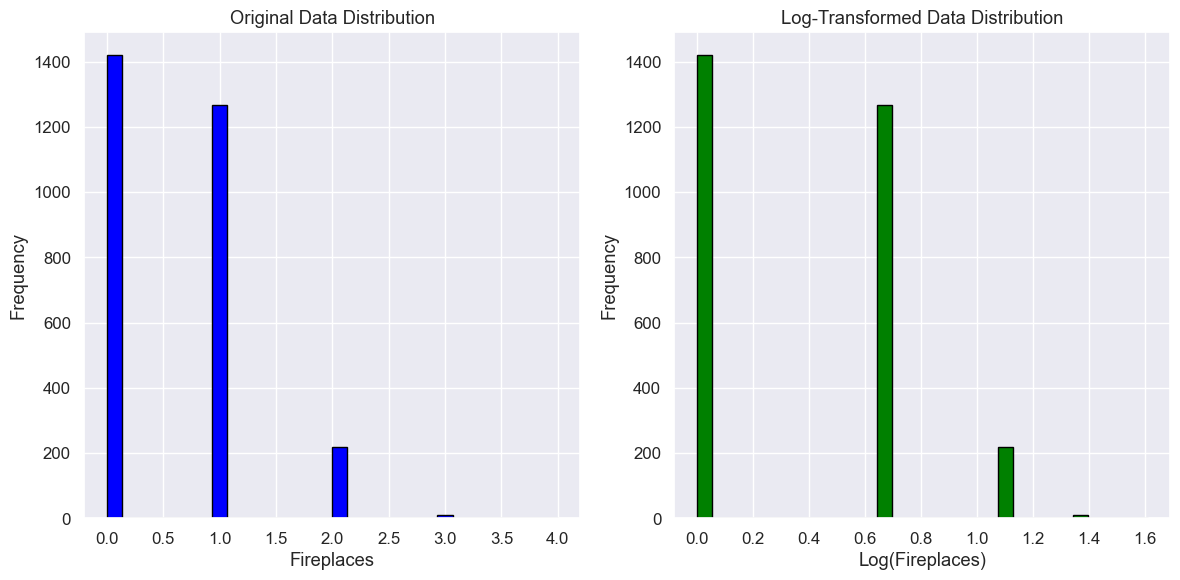

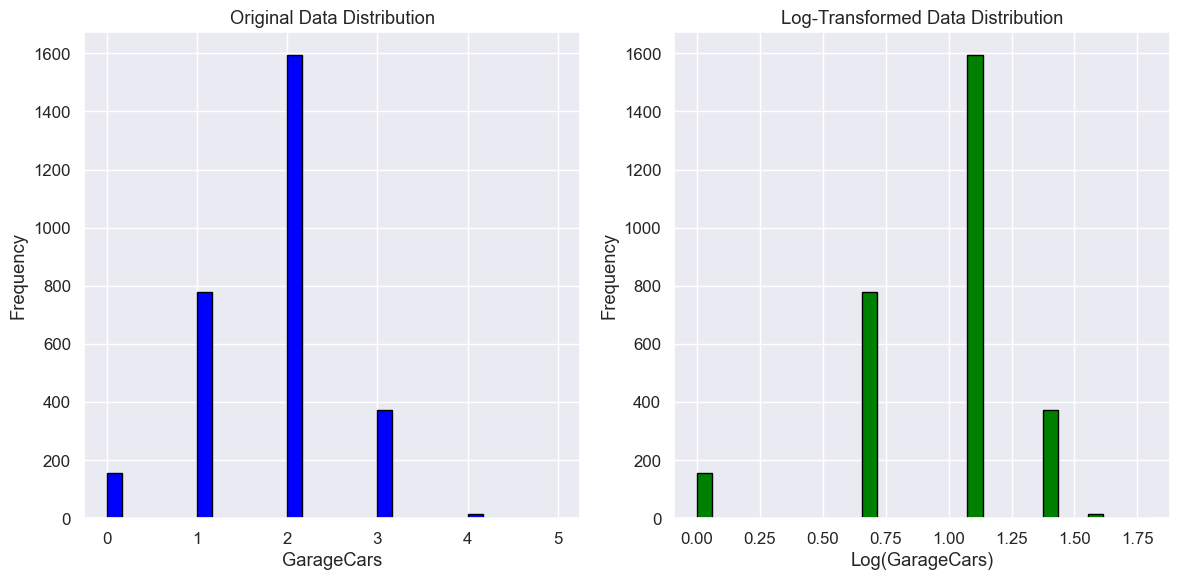

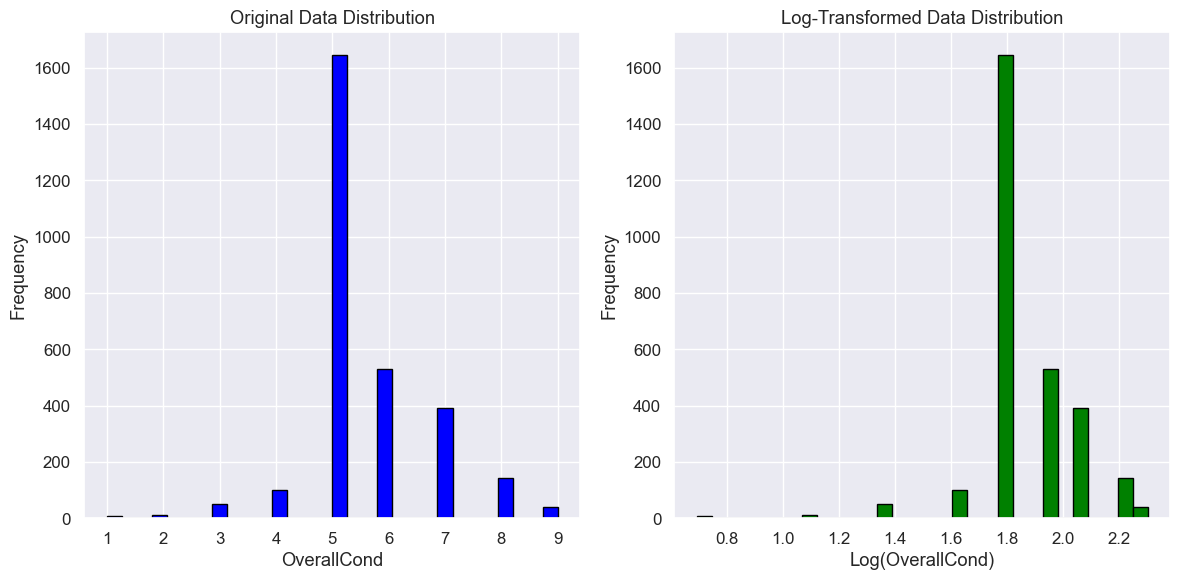

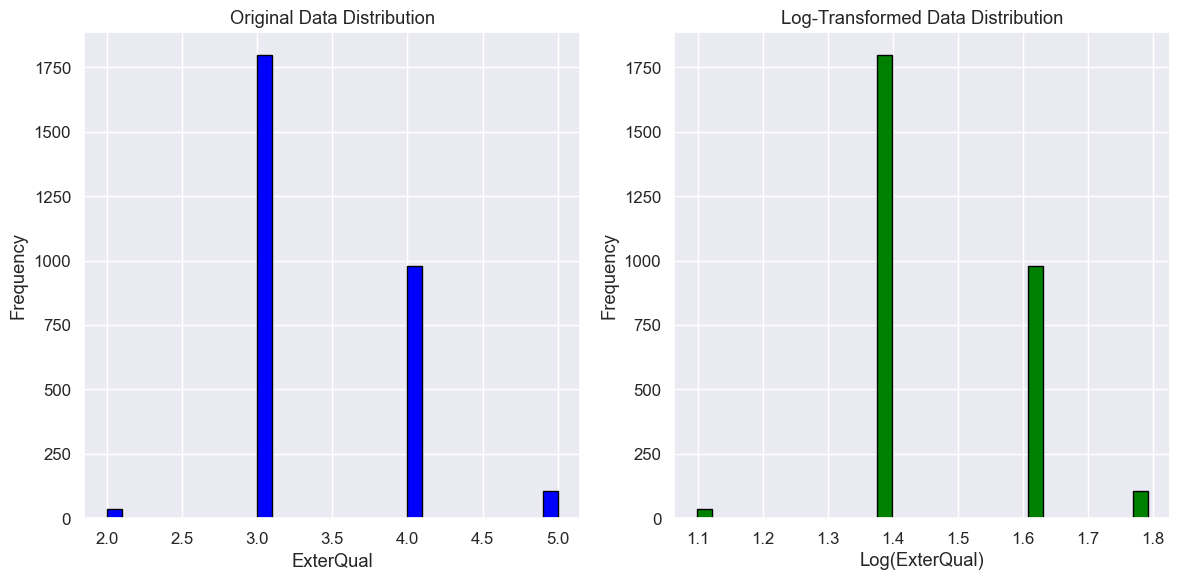

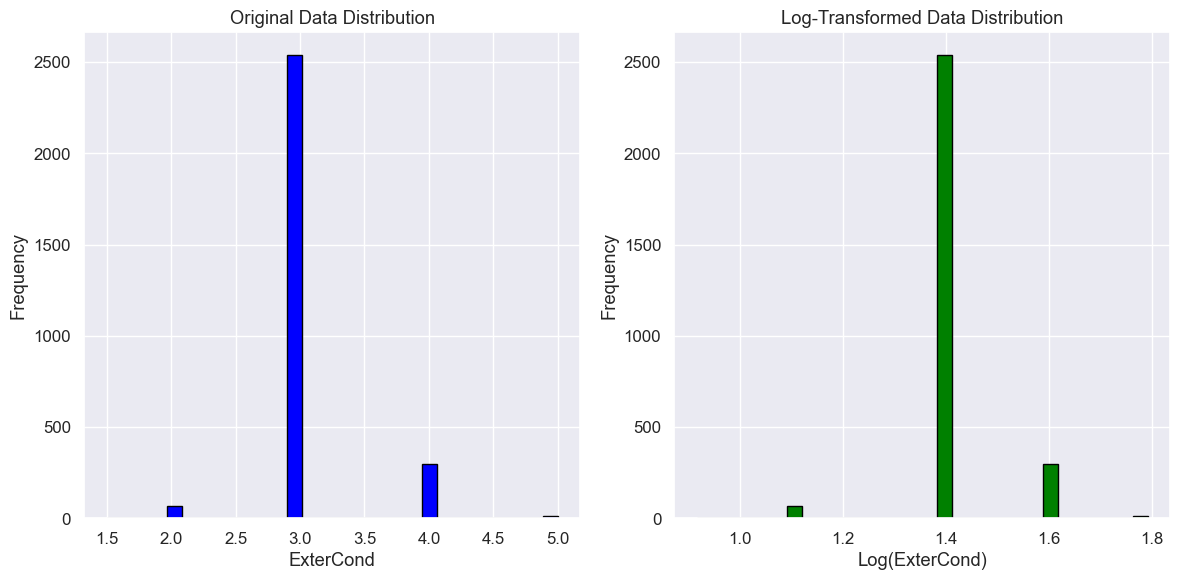

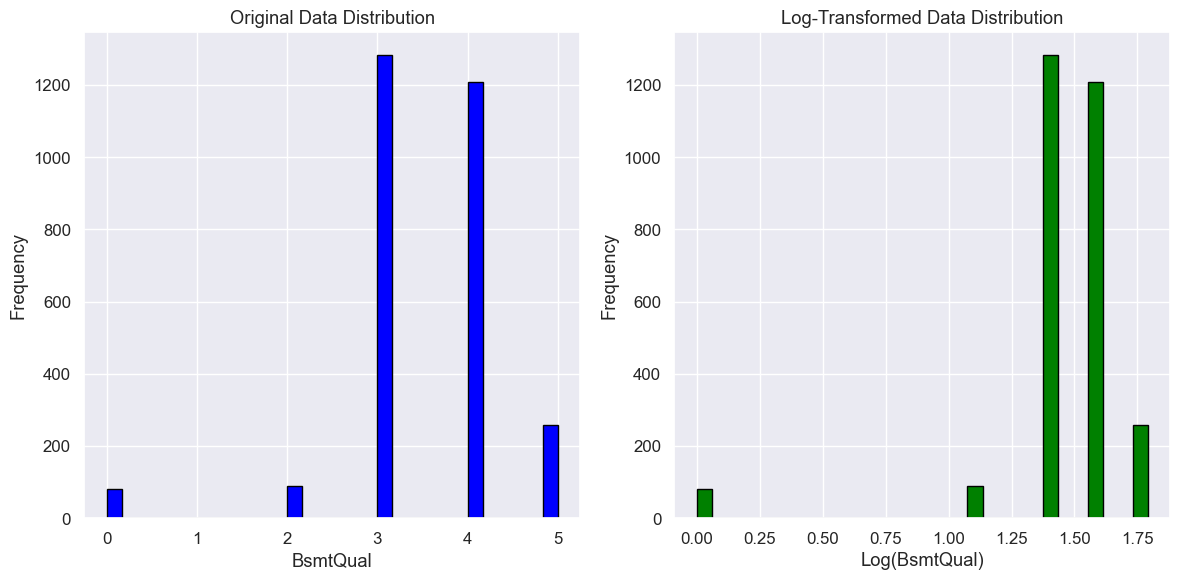

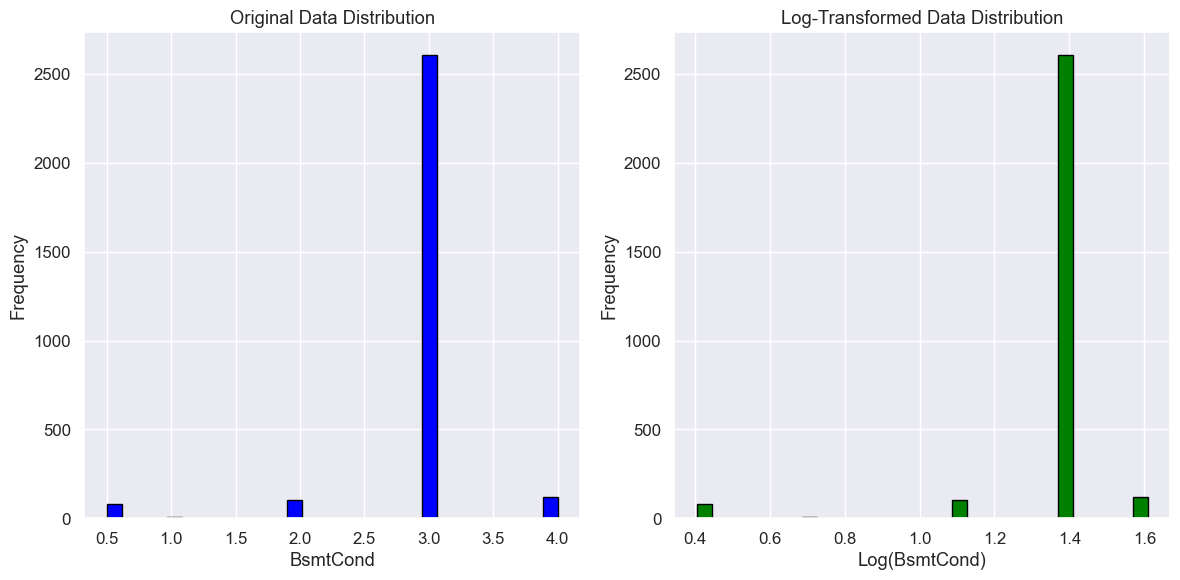

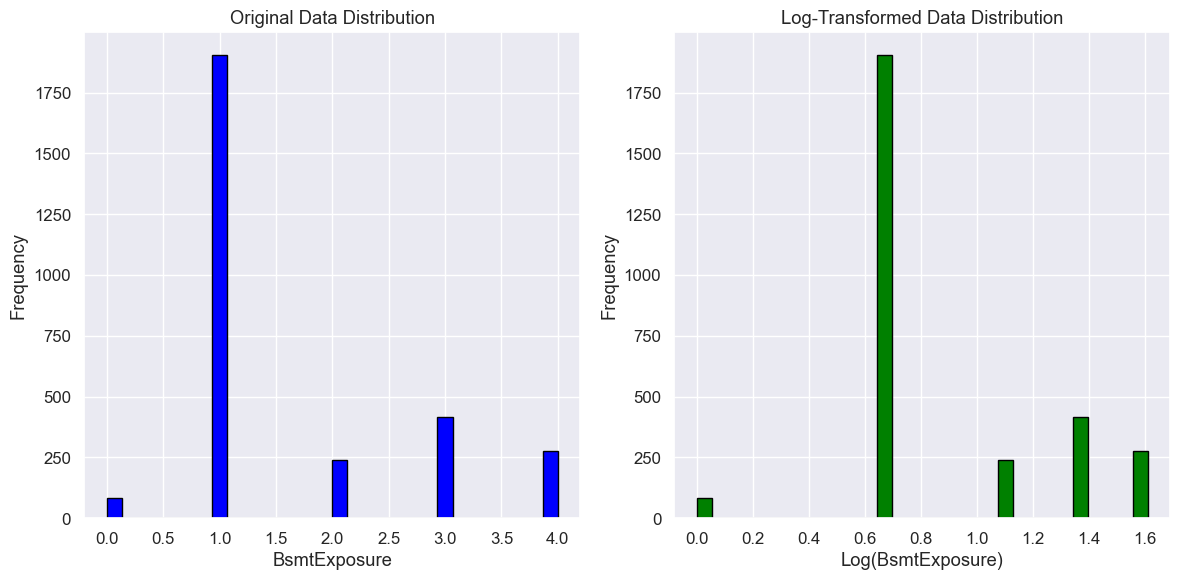

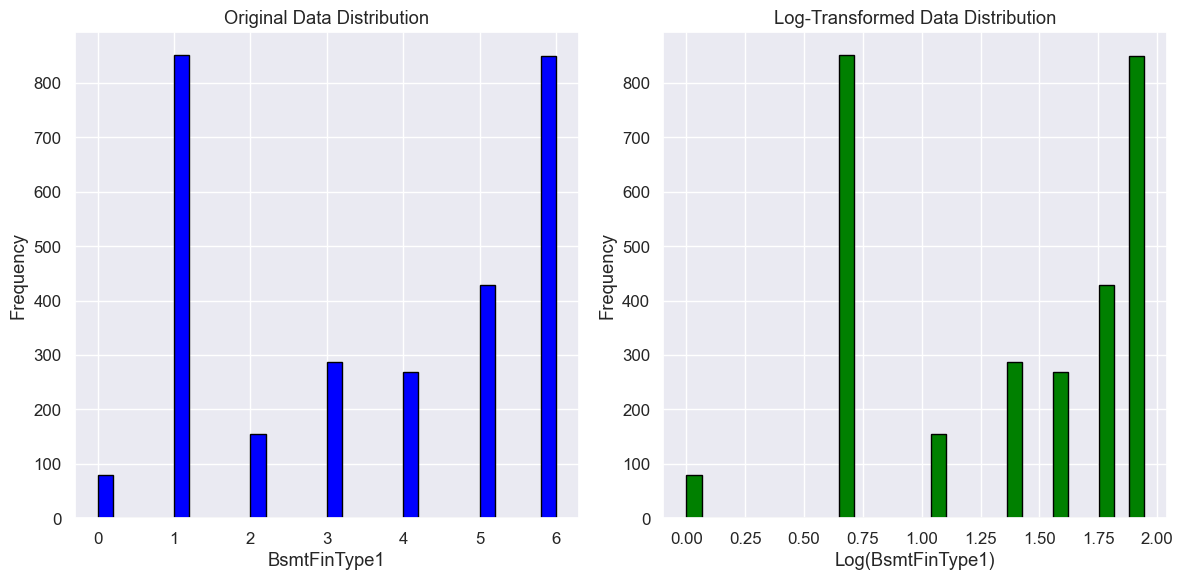

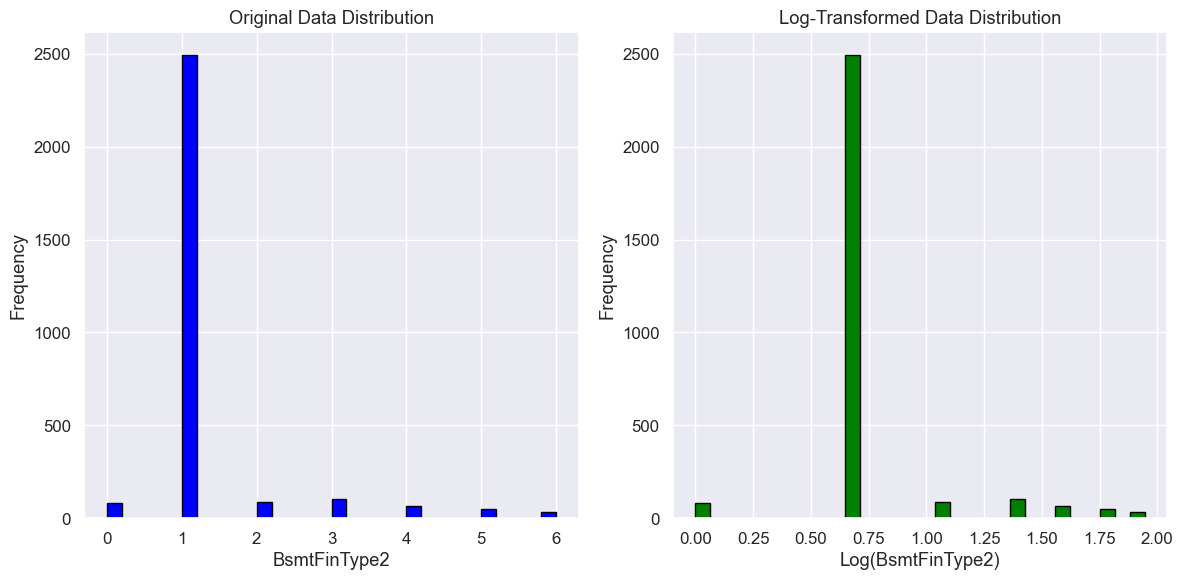

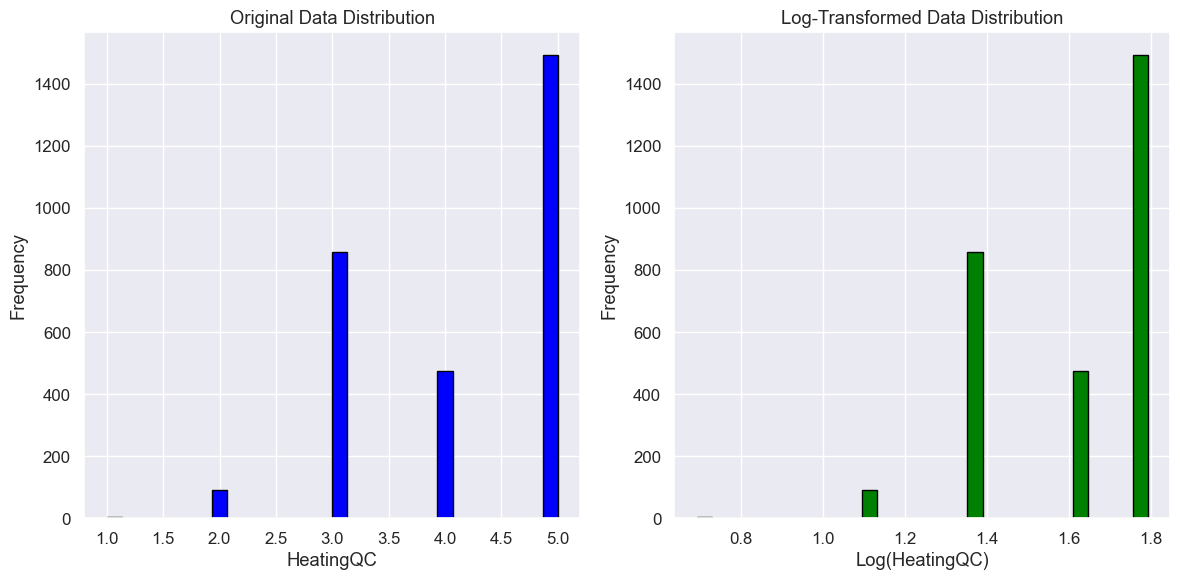

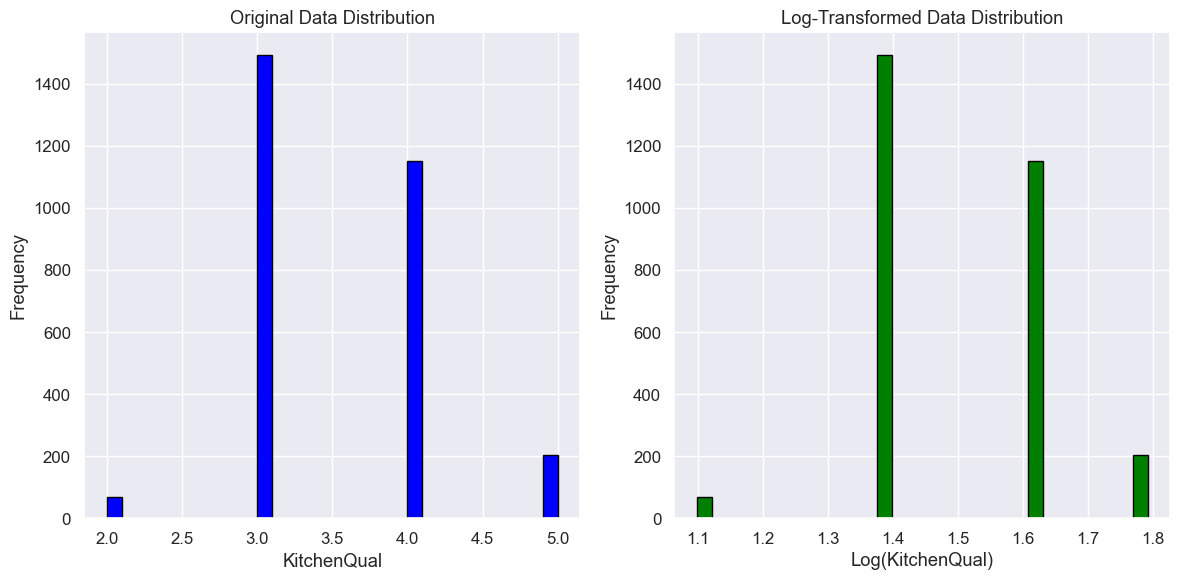

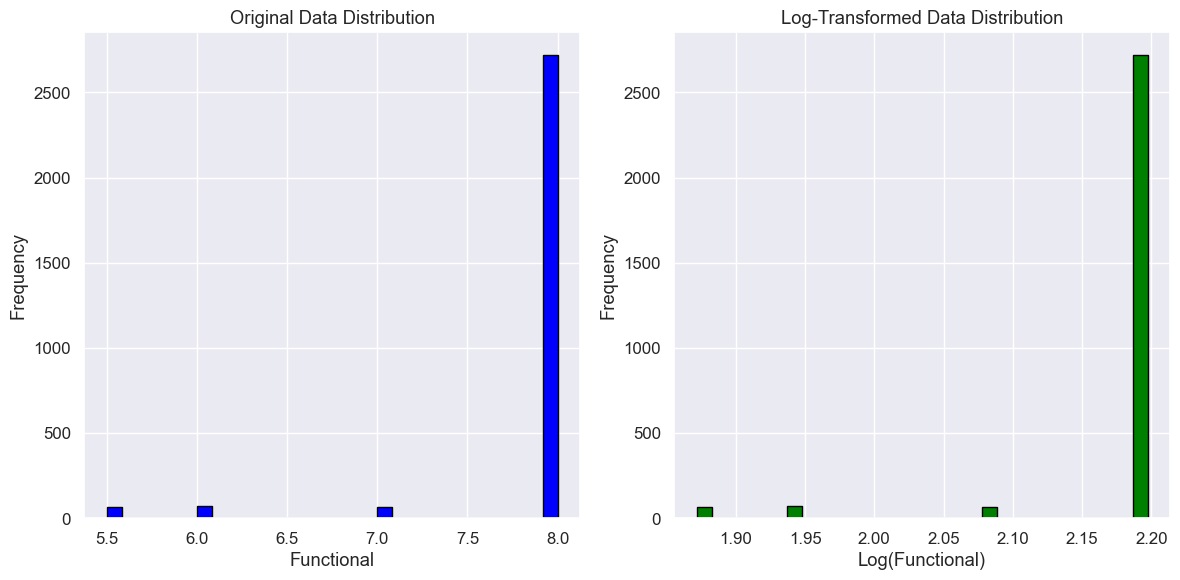

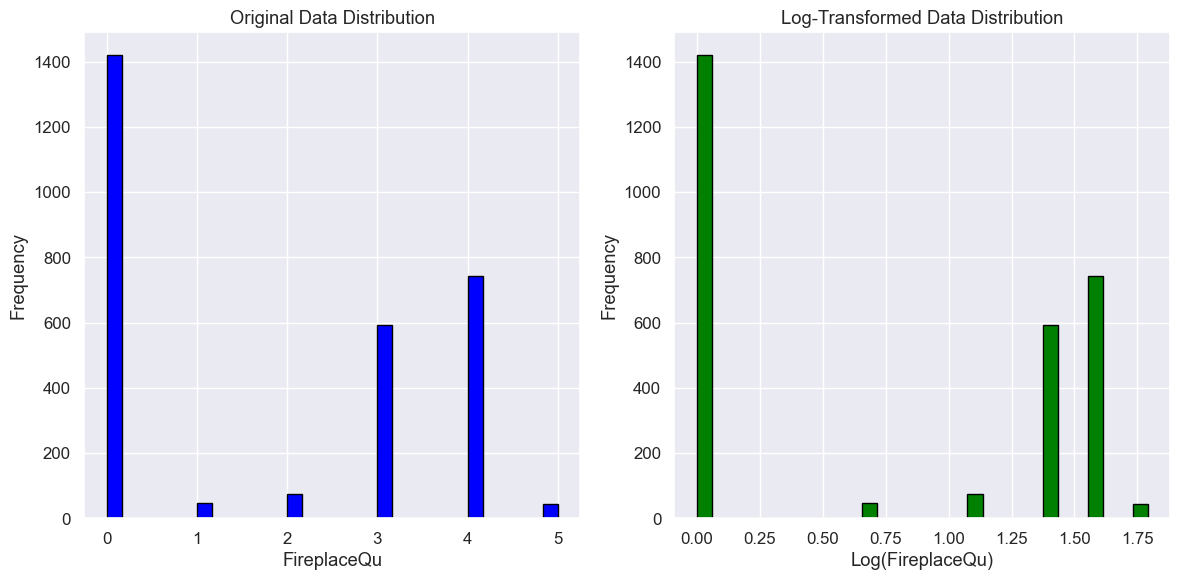

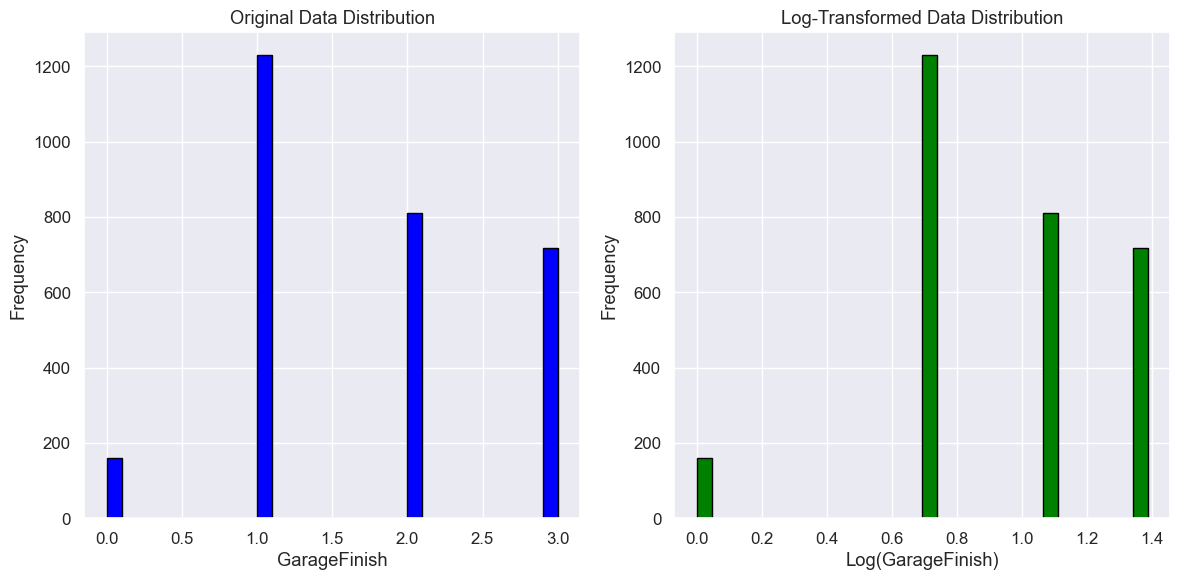

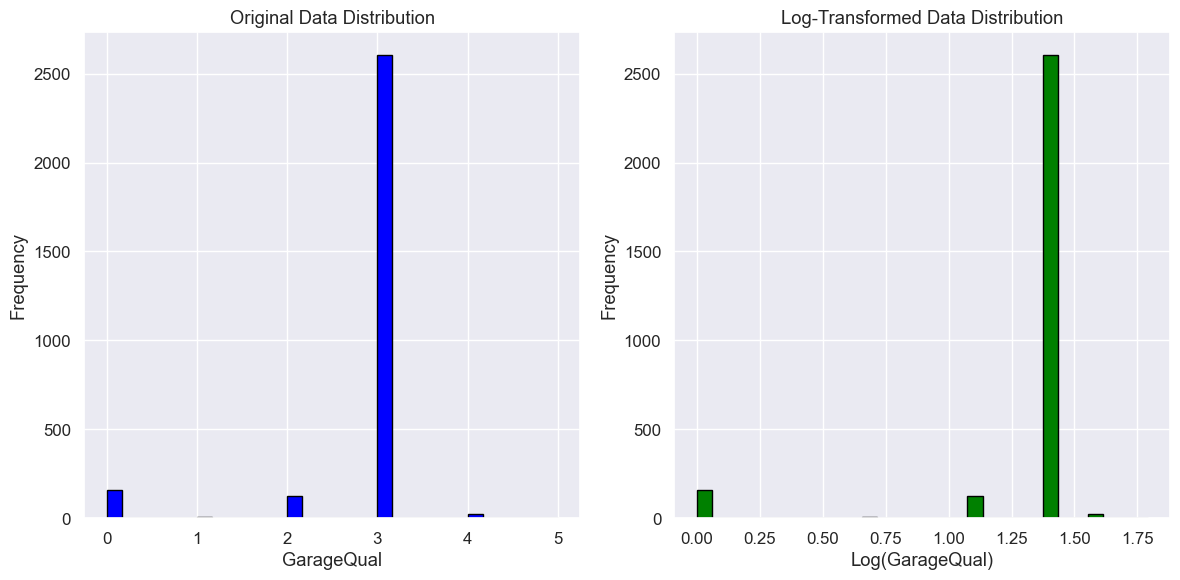

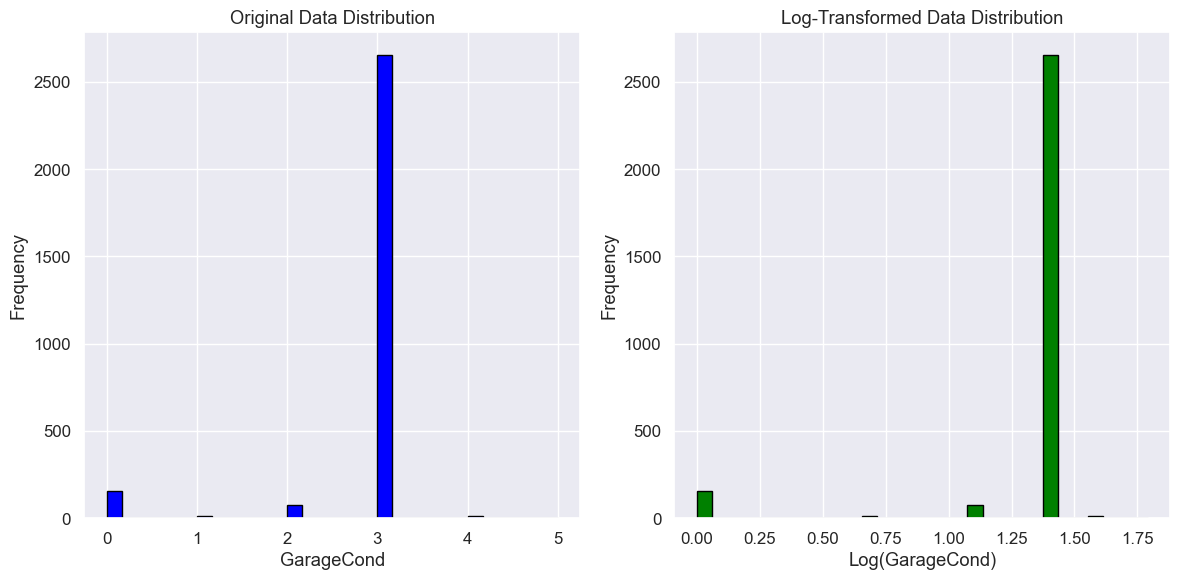

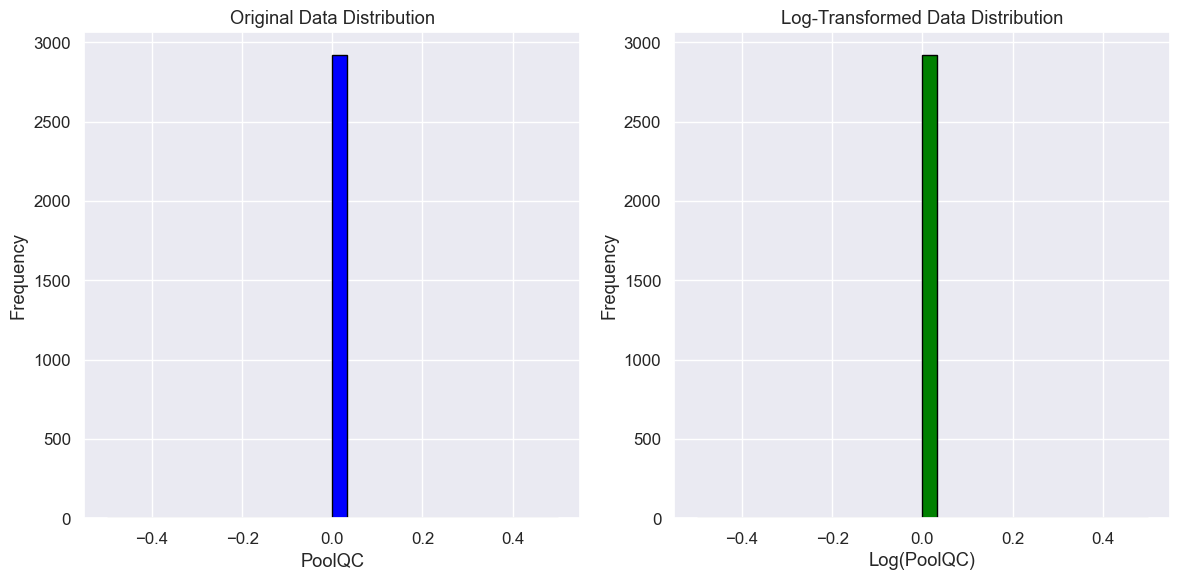

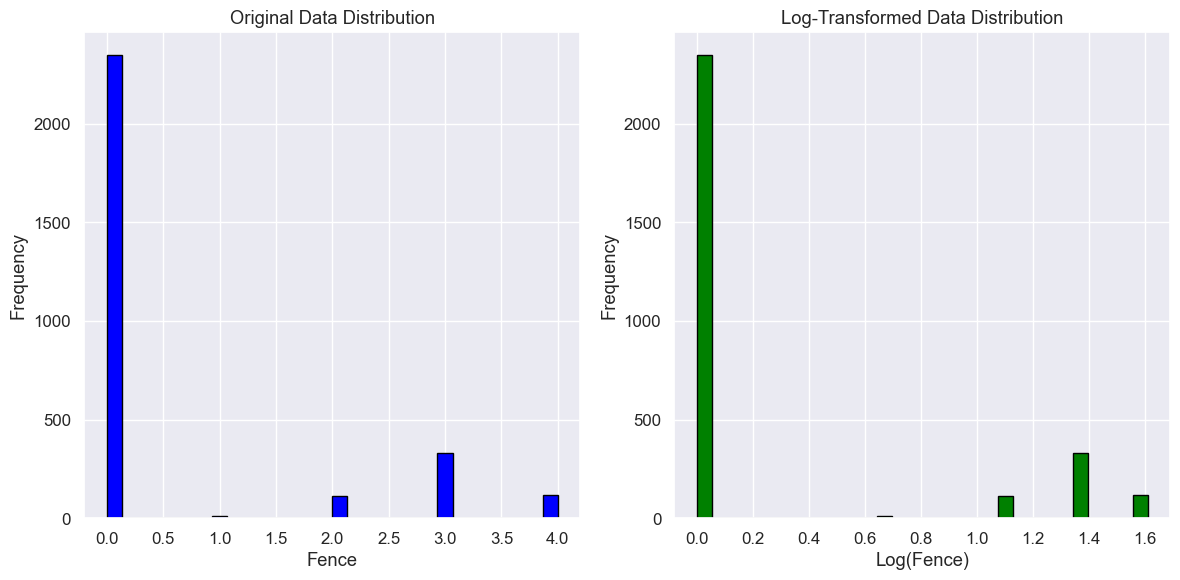

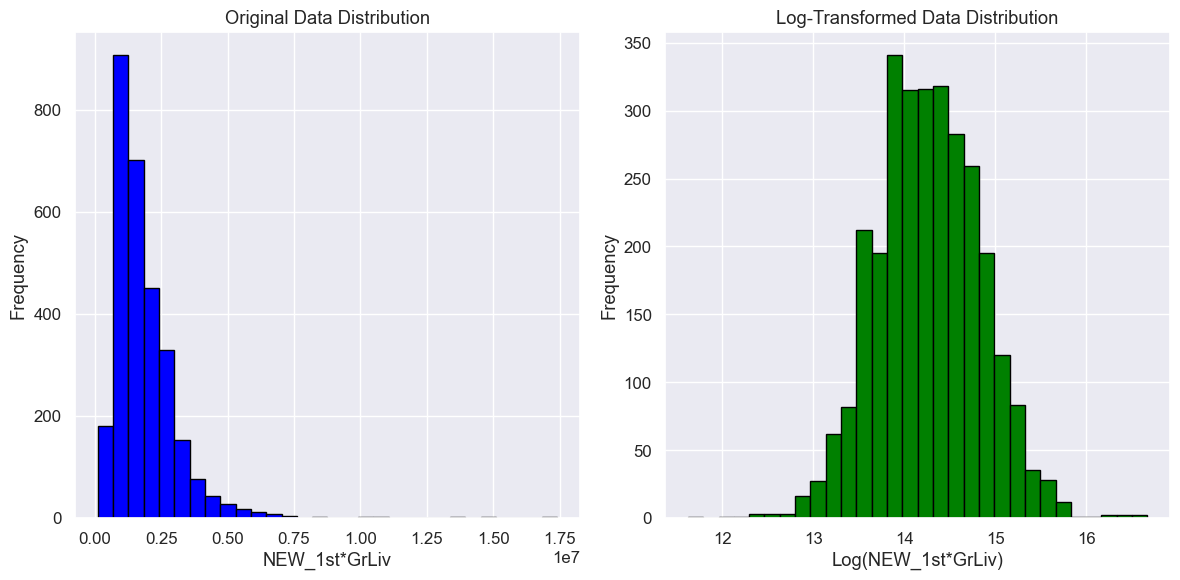

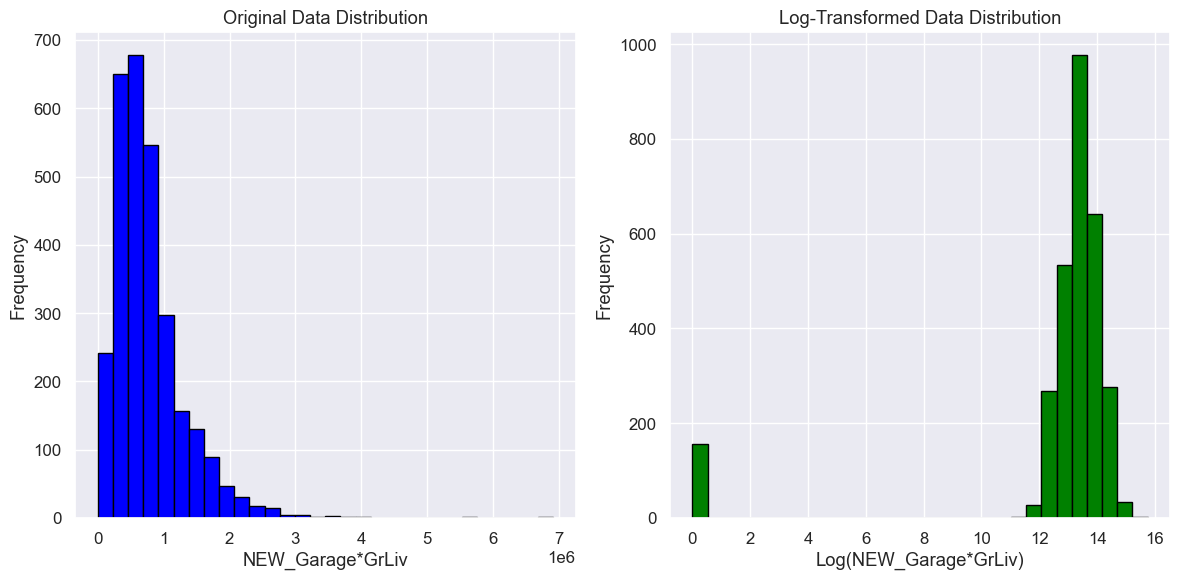

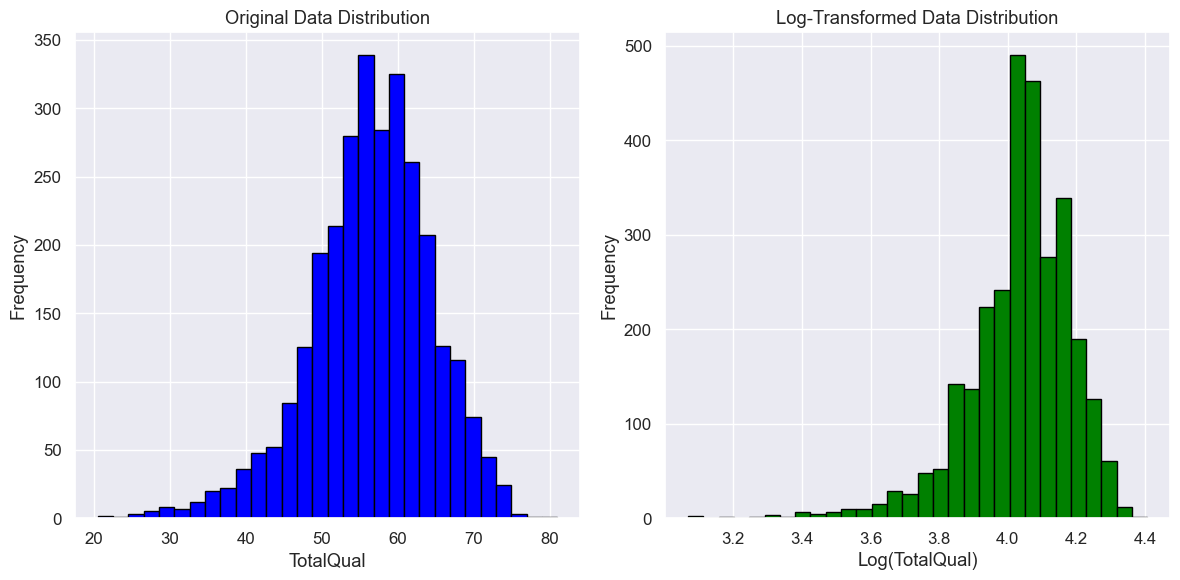

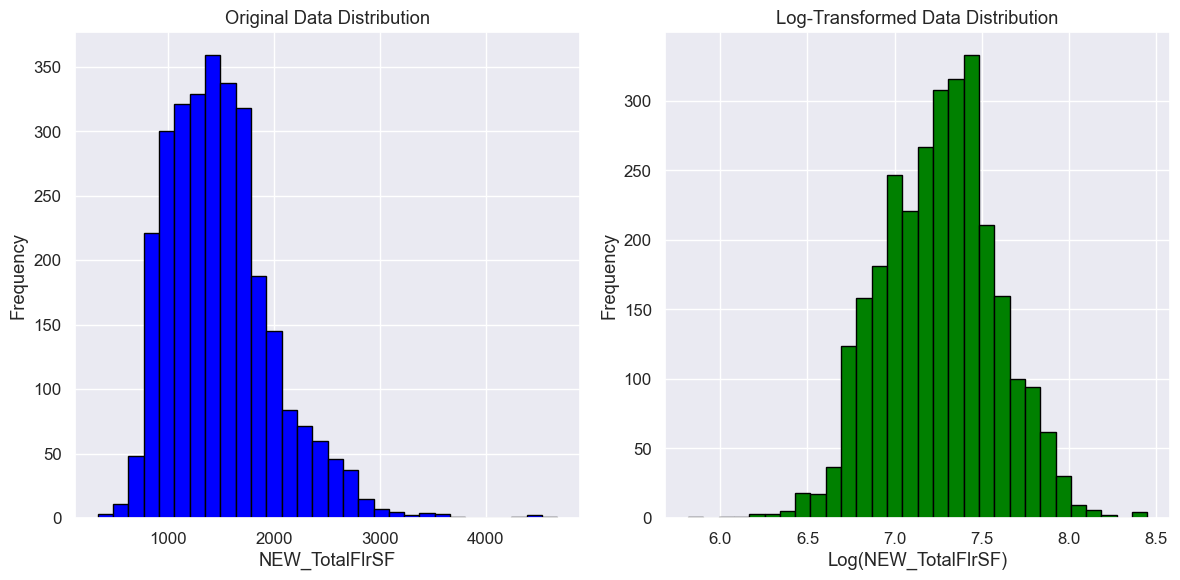

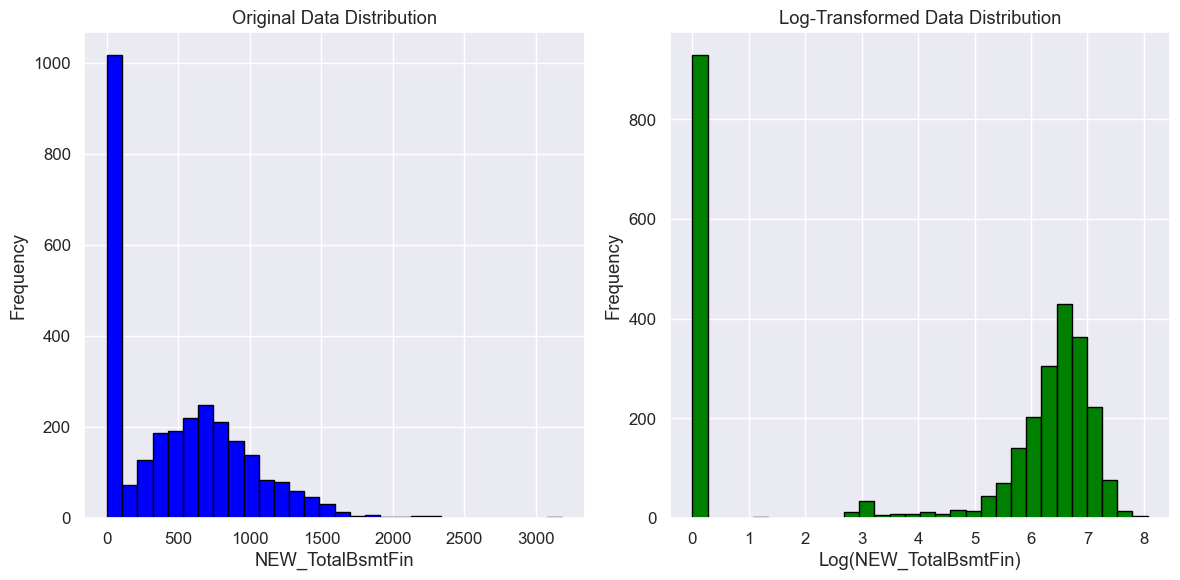

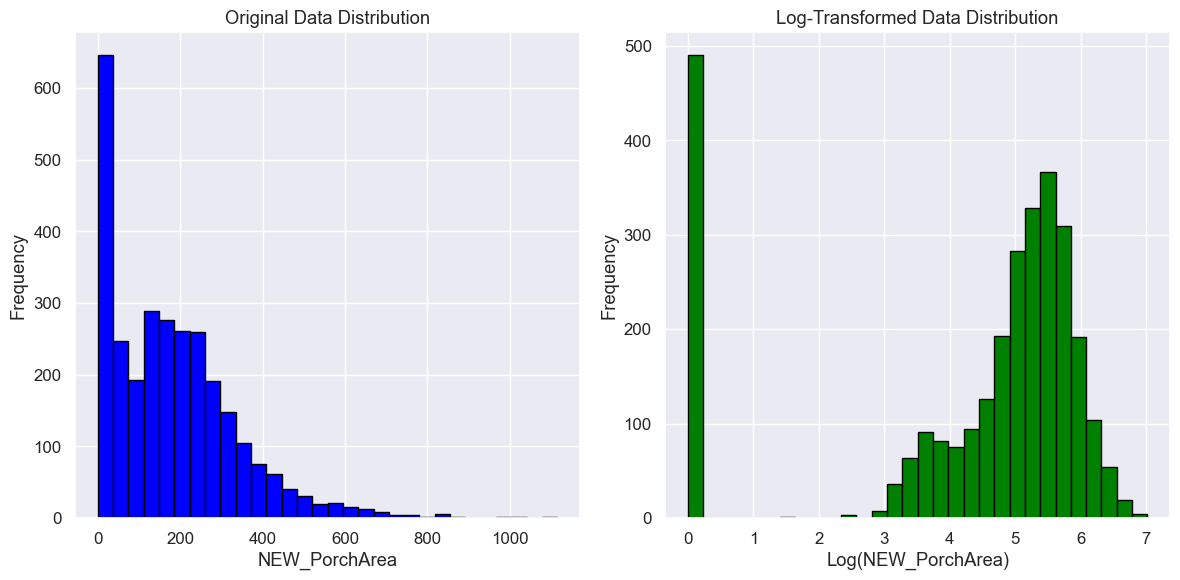

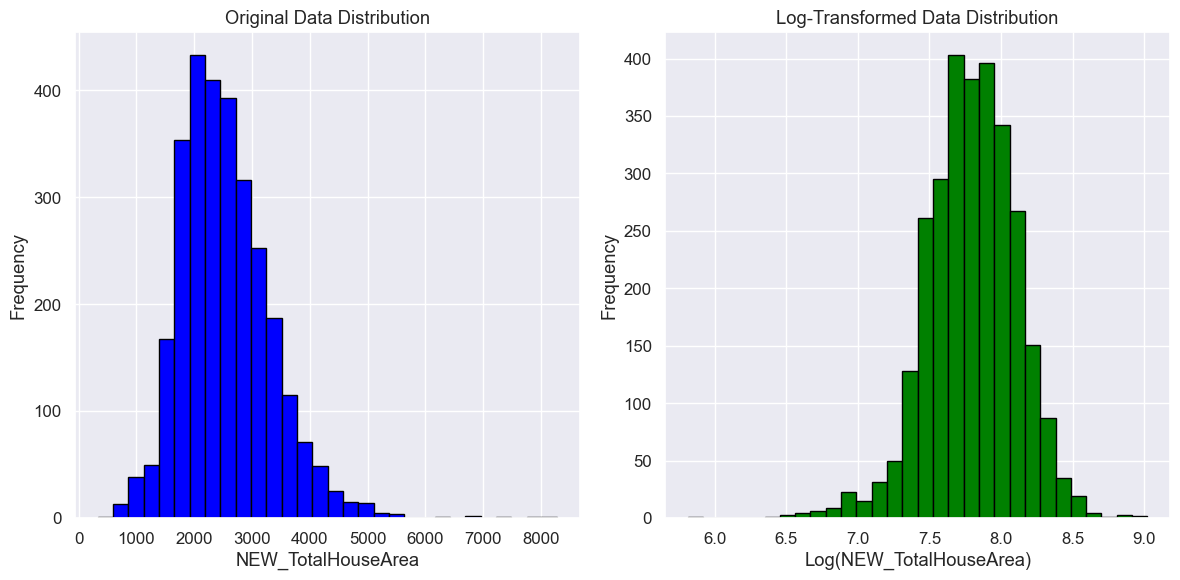

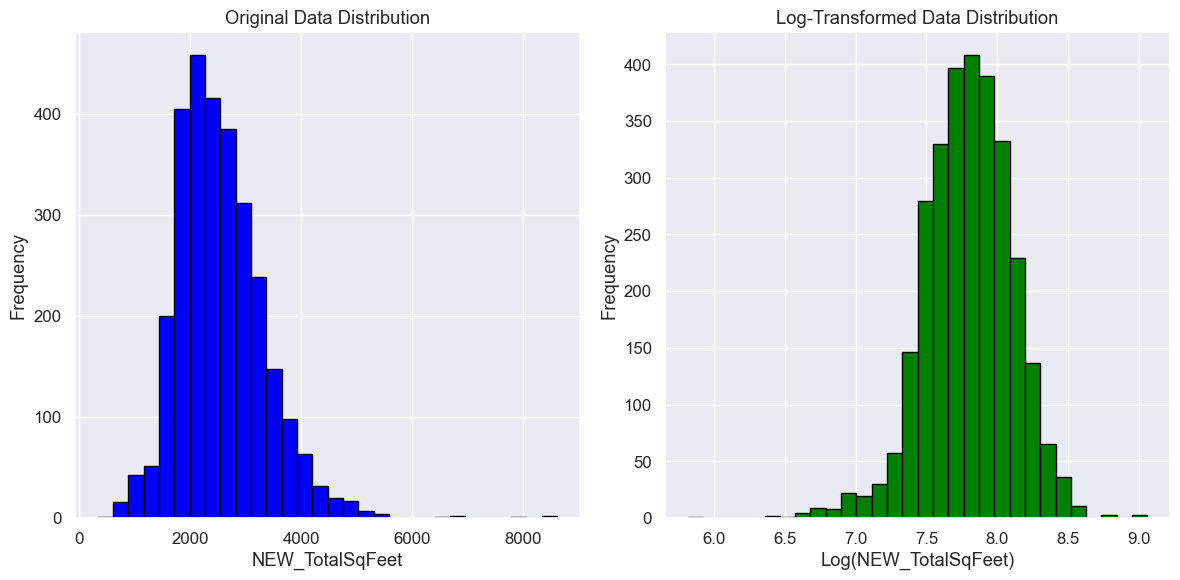

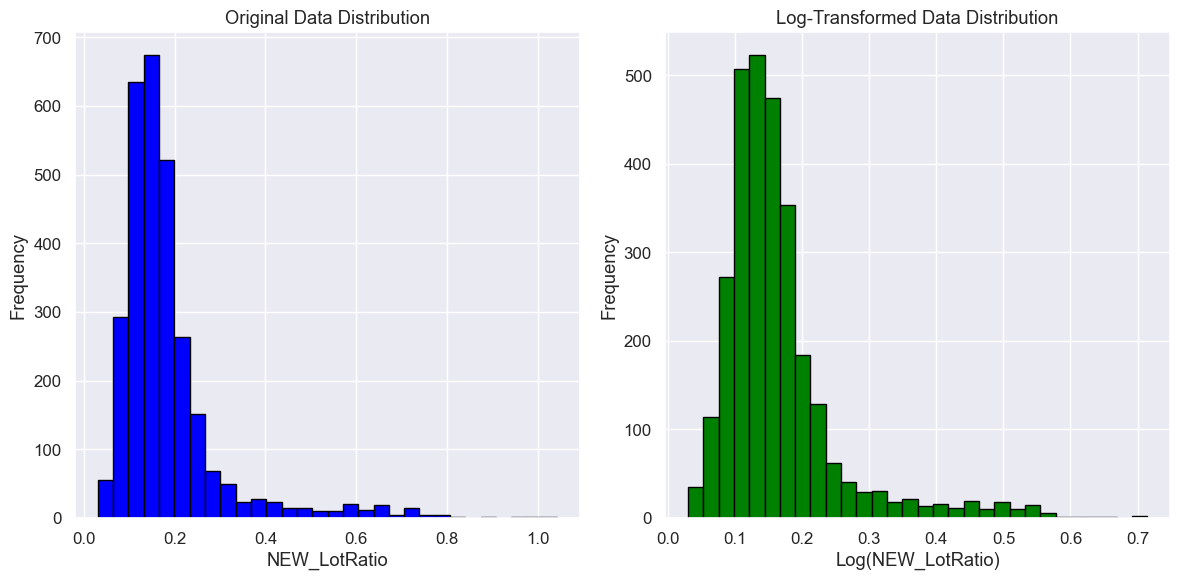

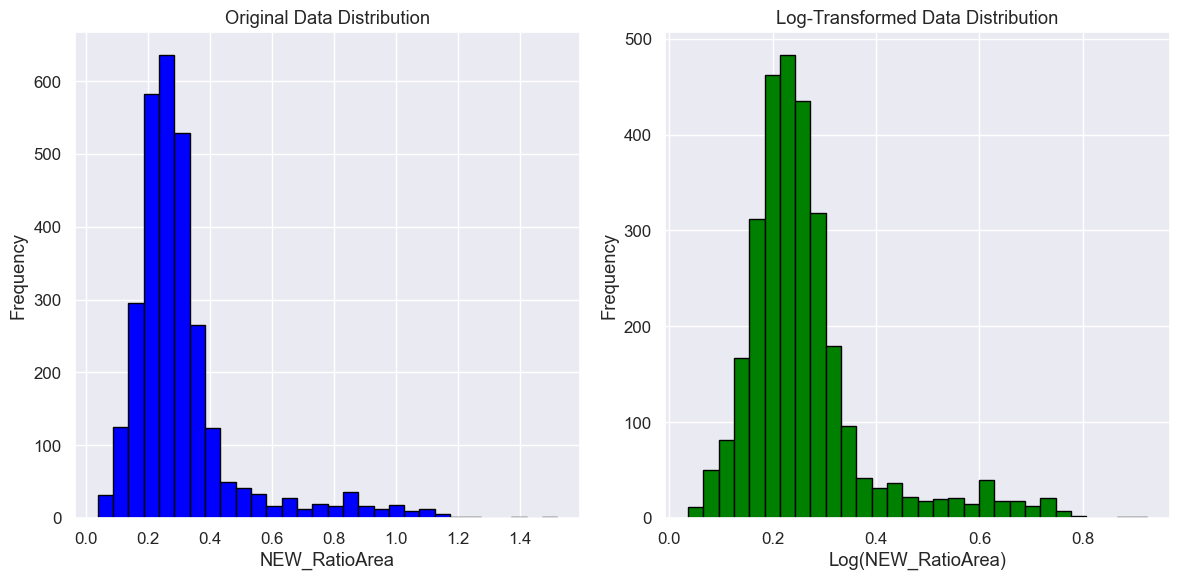

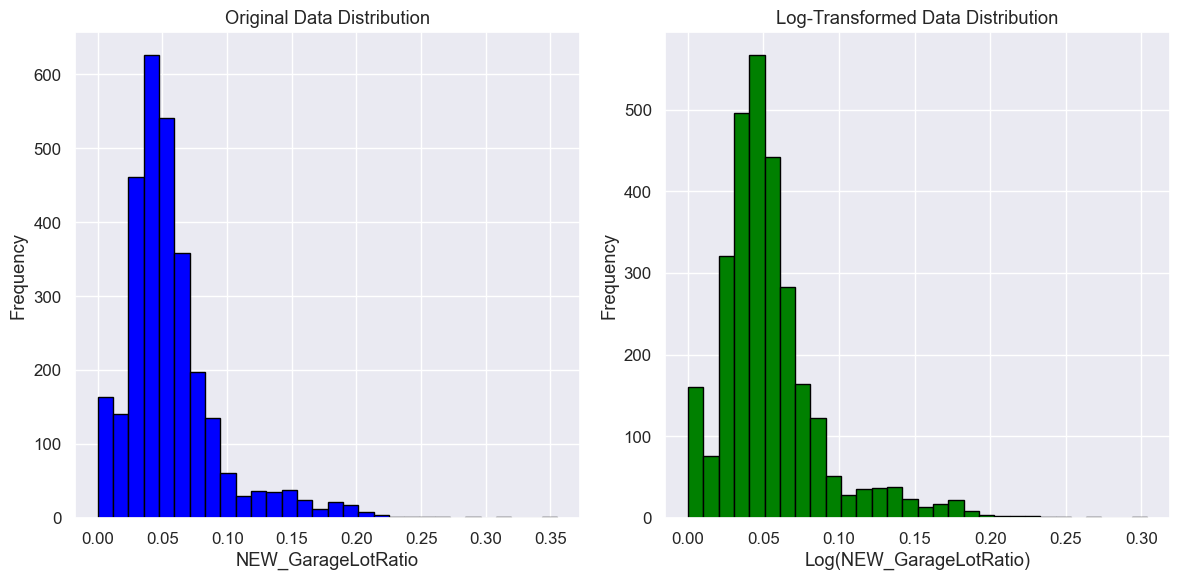

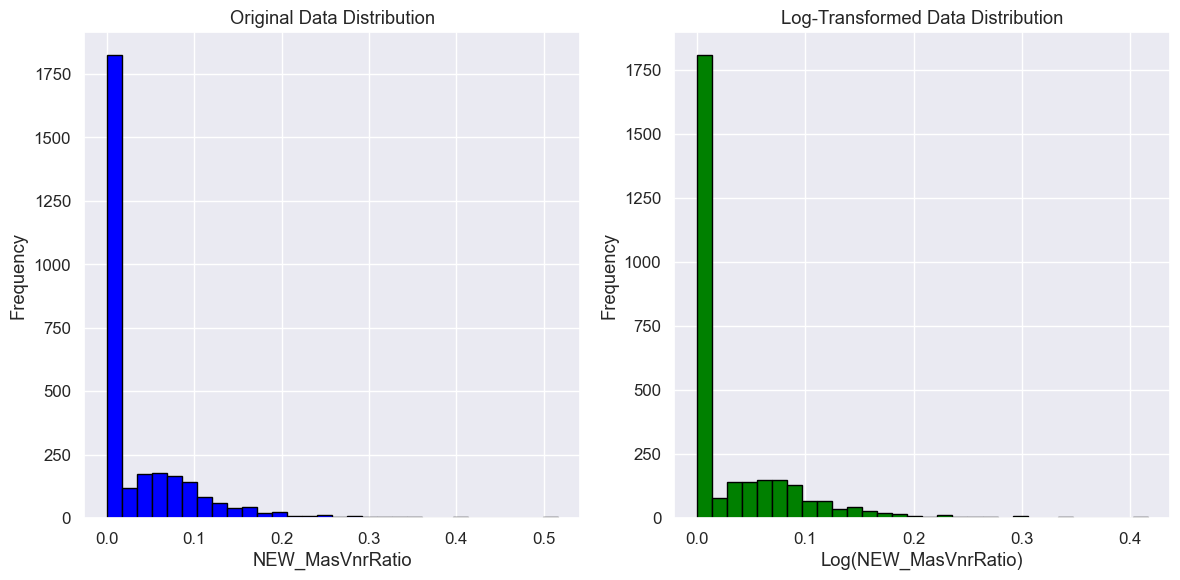

c:\Users\BORA\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


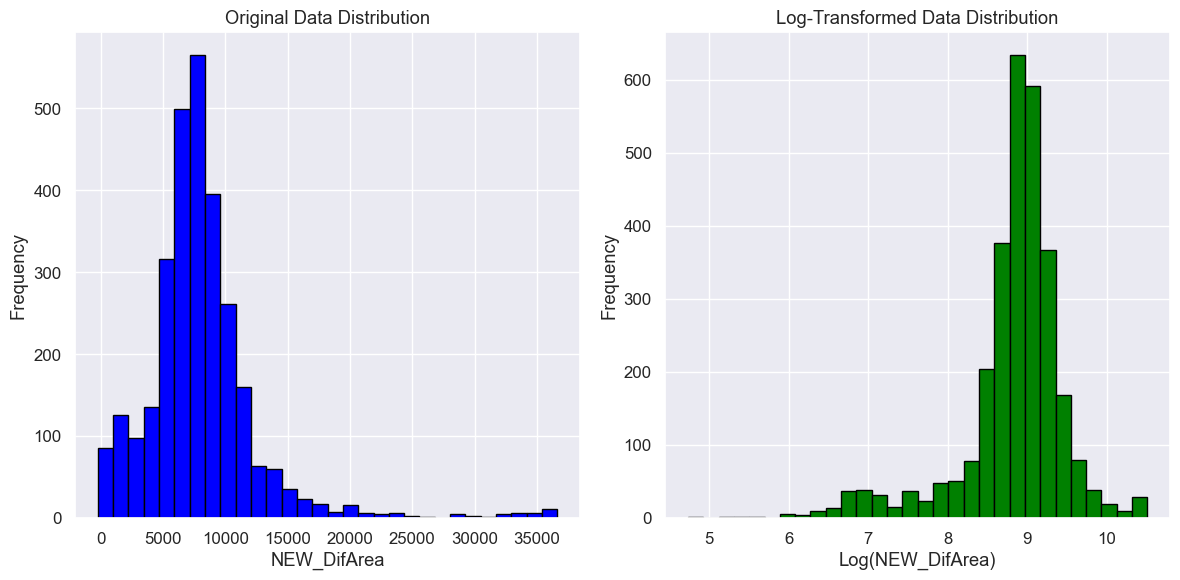

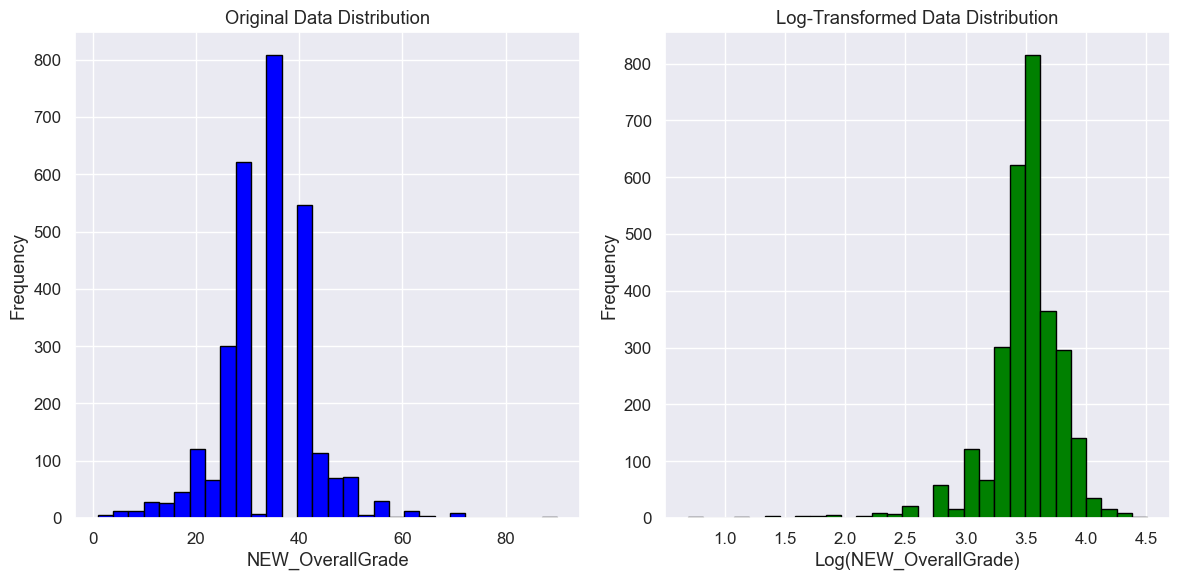

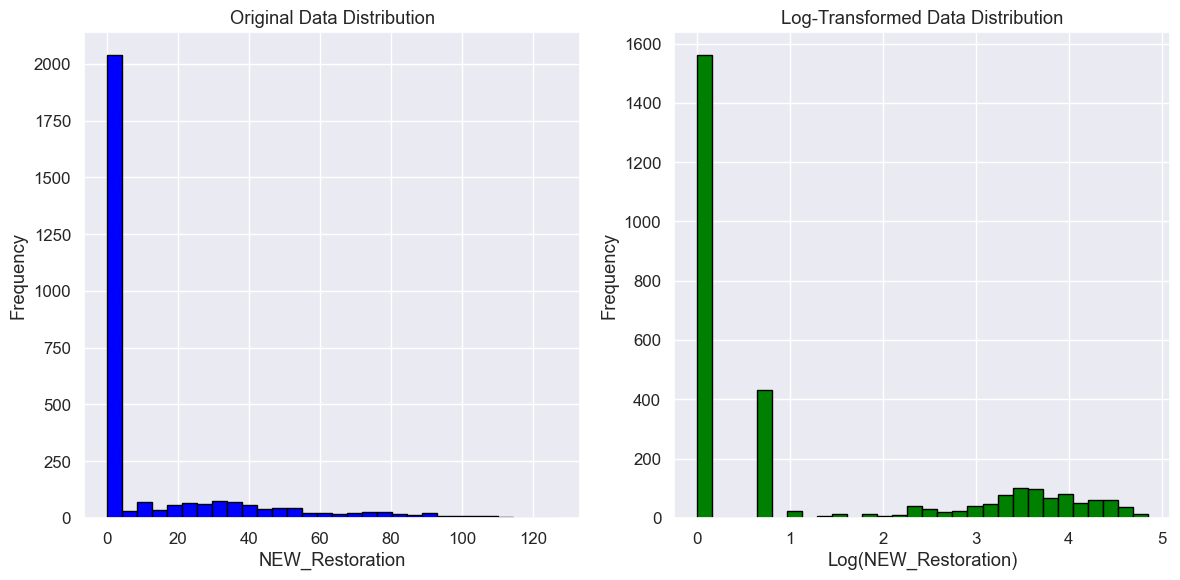

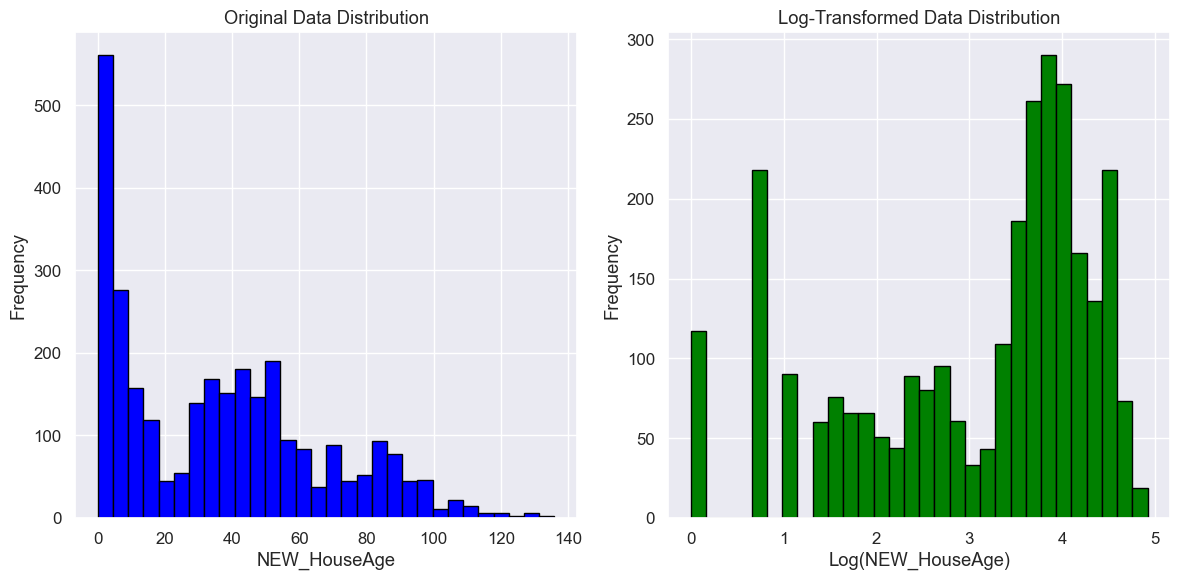

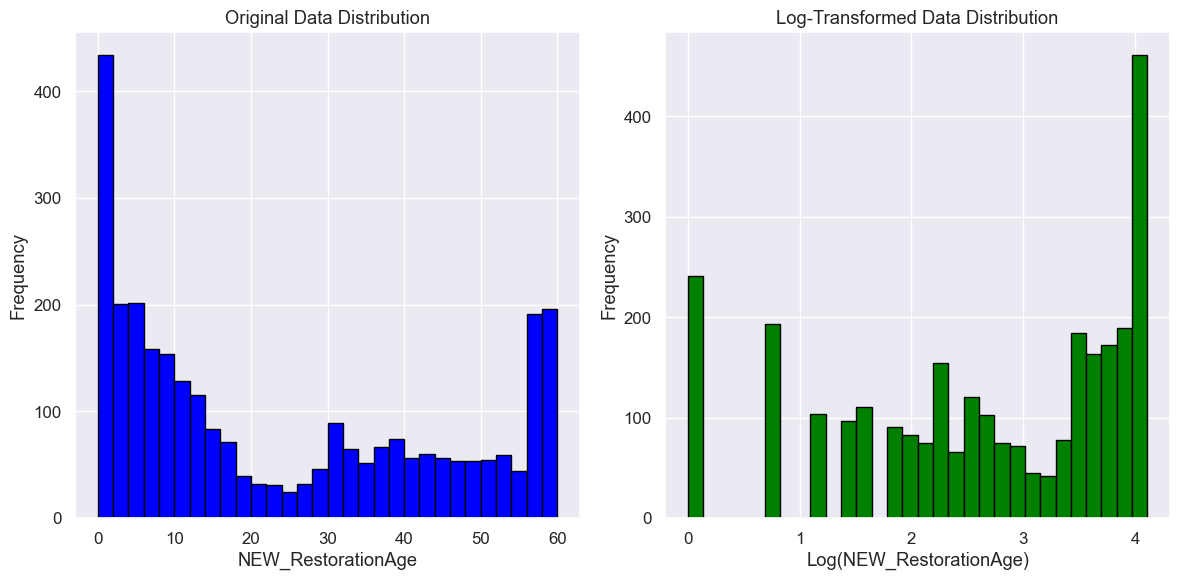

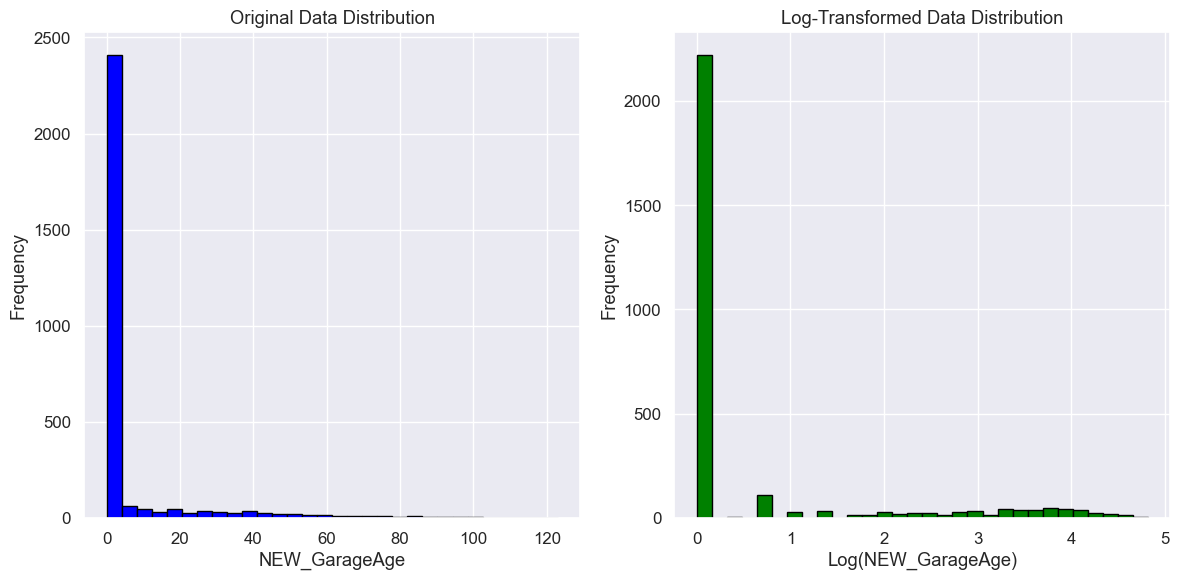

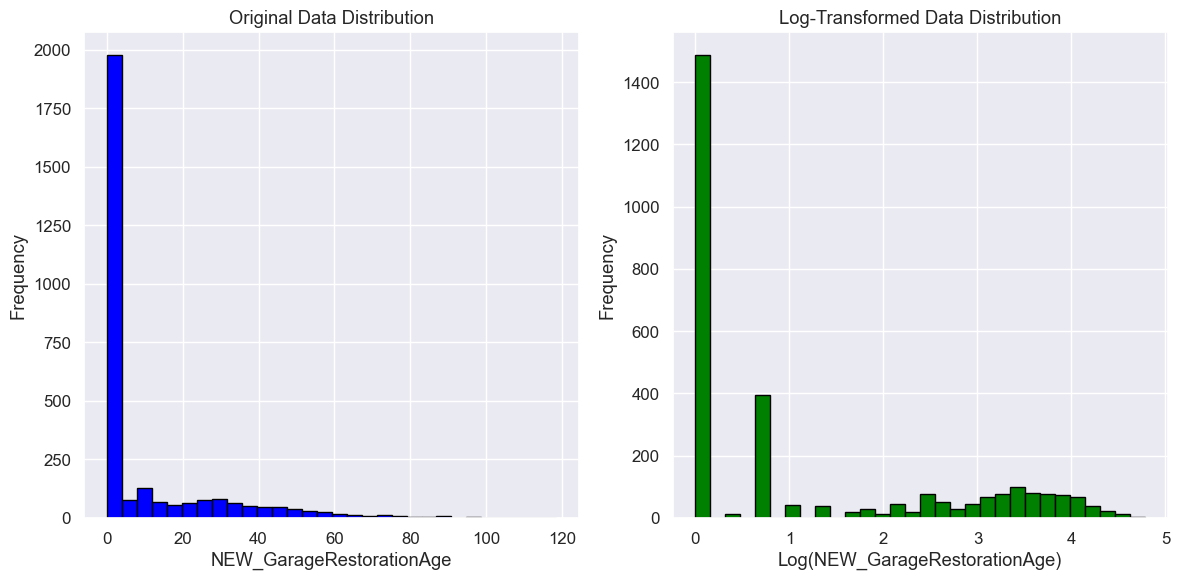

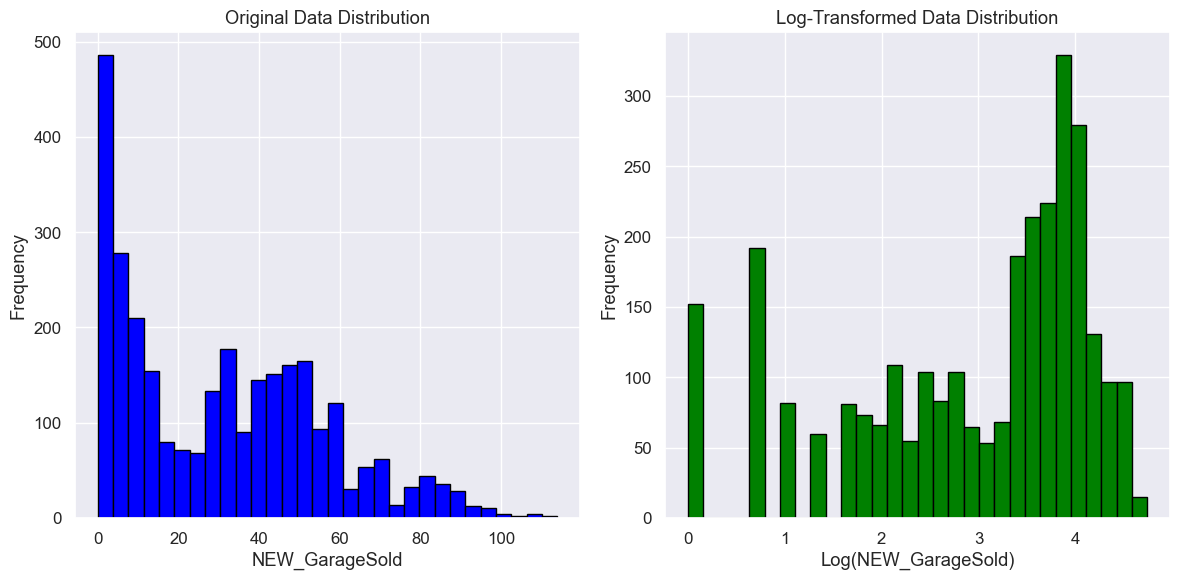

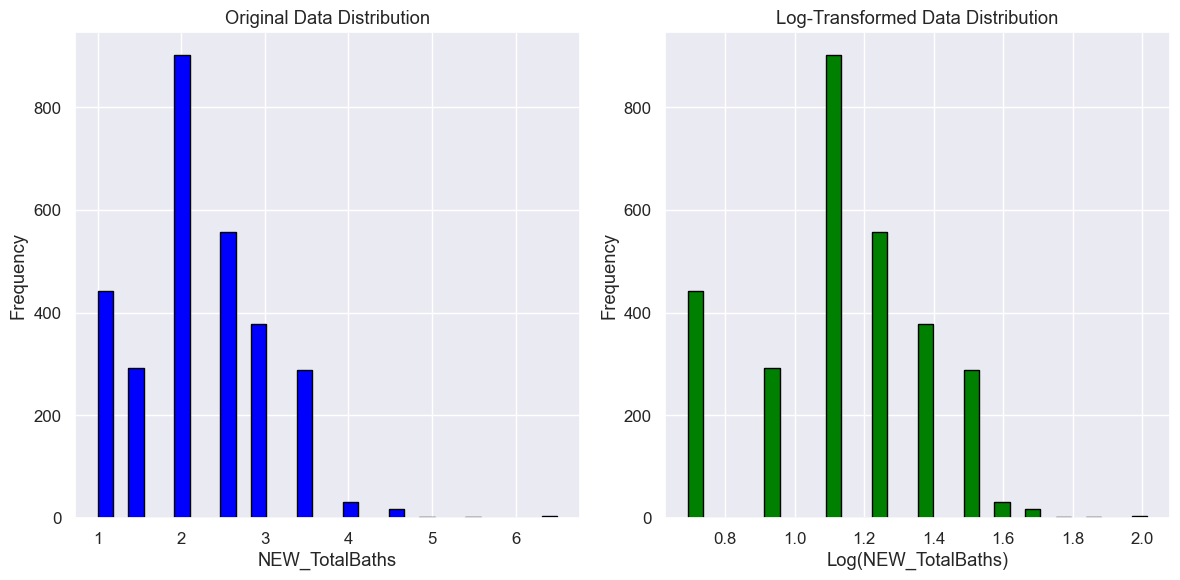

In [156]:
for col in num_cols:
    if col != 'MoSoldsin' and col != 'MoSoldcos':
        log_plots(df_copy, col)

Since our data is skewed we apply boxcox normalization and transform the skwed data

In [157]:
skewed = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
    'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
    'ScreenPorch', 'PoolArea', 'LowQualFinSF', 'MiscVal', 'TotRmsAbvGrd', 
    'NEW_1st*GrLiv', 'NEW_Garage*GrLiv', 'TotalQual', 'NEW_TotalFlrSF', 
    'NEW_TotalBsmtFin', 'NEW_PorchArea', 'NEW_TotalHouseArea', 'NEW_TotalSqFeet', 
    'NEW_LotRatio', 'NEW_RatioArea'
]

In [158]:
'''
skew_features = np.abs(df_copy[skewed].apply(lambda x: skew(x)).sort_values(
    ascending=False))

# Filtering skewed features.

high_skew = skew_features[skew_features > 0.3]

# Taking indexes of high skew.

skew_index = high_skew.index

# Applying boxcox transformation to fix skewness.

for i in skew_index:
    df_copy[i] = boxcox1p(df_copy[i], boxcox_normmax(df_copy[i] + 1)) #Normalizing Skewed Data
'''

'\nskew_features = np.abs(df_copy[skewed].apply(lambda x: skew(x)).sort_values(\n    ascending=False))\n\n# Filtering skewed features.\n\nhigh_skew = skew_features[skew_features > 0.3]\n\n# Taking indexes of high skew.\n\nskew_index = high_skew.index\n\n# Applying boxcox transformation to fix skewness.\n\nfor i in skew_index:\n    df_copy[i] = boxcox1p(df_copy[i], boxcox_normmax(df_copy[i] + 1)) #Normalizing Skewed Data\n'

In [159]:
for col in skewed:
    '''
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(df_copy[col], bins=30, edgecolor='black', color='blue')
    plt.title('Original Data Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    '''
    # Step 3: Apply Log Transformation
    df_copy[col] = np.log1p(df_copy[col])
    '''
    # Step 4: Visualize Transformed Data Distribution
    plt.subplot(1, 2, 2)
    plt.hist(df_copy[col], bins=30, edgecolor='black', color='green')
    plt.title('Log-Transformed Data Distribution')
    plt.xlabel('Log('+ col +')')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    '''

In [160]:
'''
for col in skewed:
    plt.figure(figsize=(12, 6))

    # Original Data Distribution
    plt.subplot(1, 2, 1)
    plt.hist(df_copy[col], bins=30, edgecolor='black', color='blue')
    plt.title('Original Data Distribution')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Step 3: Apply Box-Cox Transformation using boxcox1p
    # Calculate the optimal lambda for the Box-Cox transformation
    optimal_lambda = boxcox_normmax(df_copy[col] + 1)
    df_copy[col + '_BoxCox'] = boxcox1p(df_copy[col], optimal_lambda)

    # Step 4: Visualize Transformed Data Distribution
    plt.subplot(1, 2, 2)
    plt.hist(df_copy[col + '_BoxCox'], bins=30, edgecolor='black', color='green')
    plt.title('Box-Cox Transformed Data Distribution')
    plt.xlabel('BoxCox1p(' + col + ')')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()
'''

"\nfor col in skewed:\n    plt.figure(figsize=(12, 6))\n\n    # Original Data Distribution\n    plt.subplot(1, 2, 1)\n    plt.hist(df_copy[col], bins=30, edgecolor='black', color='blue')\n    plt.title('Original Data Distribution')\n    plt.xlabel(col)\n    plt.ylabel('Frequency')\n\n    # Step 3: Apply Box-Cox Transformation using boxcox1p\n    # Calculate the optimal lambda for the Box-Cox transformation\n    optimal_lambda = boxcox_normmax(df_copy[col] + 1)\n    df_copy[col + '_BoxCox'] = boxcox1p(df_copy[col], optimal_lambda)\n\n    # Step 4: Visualize Transformed Data Distribution\n    plt.subplot(1, 2, 2)\n    plt.hist(df_copy[col + '_BoxCox'], bins=30, edgecolor='black', color='green')\n    plt.title('Box-Cox Transformed Data Distribution')\n    plt.xlabel('BoxCox1p(' + col + ')')\n    plt.ylabel('Frequency')\n\n    plt.tight_layout()\n    plt.show()\n"

In [161]:
num_cols_without_target = [col for col in num_cols if col not in 'SalePrice']

### Feature Scaling
We use Robust Scaling because Robust Scaler algorithms scale features that are robust to outliers and mostly work as min-max scaler

In [165]:
scaler = RobustScaler()

df_copy[num_cols_without_target] = pd.DataFrame(scaler.fit_transform(df_copy[num_cols_without_target]))

#df_copy[num_cols] = pd.DataFrame(scaler.inverse_transform(df_copy[num_cols]))

## Encoding

In [167]:
df_copy = one_hot_encoder(df_copy, cat_cols)

In [168]:
df_copy = one_hot_encoder(df_copy, cat_but_car)

In [ ]:
#num_cols_without_new_features = num_cols.copy()
#num_cols.extend(new_features)

In [ ]:
#correlation_matrix(df_copy, num_cols)
#drop_list = high_correlated_cols(df_copy[num_cols_without_new_features])

In [ ]:
#drop_list

In [ ]:
# drop_list'teki değişkenlerin düşürülmesi
#df_copy.drop(drop_list, axis=1, inplace=True)

In [ ]:
#num_cols = [col for col in num_cols if col not in drop_list]
#cat_cols = [col for col in cat_cols if col not in drop_list]

In [ ]:
'''
X_scaled = StandardScaler().fit_transform(df_copy[num_cols])
df_copy[num_cols] = pd.DataFrame(X_scaled, columns=df_copy[num_cols].columns)
'''

## Final

In [169]:
check_df(df_copy)

##################### Shape #####################
(2919, 203)
##################### Types #####################
LotFrontage                 float64
LotArea                     float64
OverallQual                 float64
OverallCond                 float64
YearBuilt                   float64
YearRemodAdd                float64
MasVnrArea                  float64
ExterQual                   float64
ExterCond                   float64
BsmtQual                    float64
BsmtCond                    float64
BsmtExposure                float64
BsmtFinType1                float64
BsmtFinSF1                  float64
BsmtFinType2                float64
BsmtFinSF2                  float64
BsmtUnfSF                   float64
TotalBsmtSF                 float64
HeatingQC                   float64
1stFlrSF                    float64
2ndFlrSF                    float64
LowQualFinSF                float64
GrLivArea                   float64
BsmtFullBath                float64
BsmtHalfBath            

In [170]:
split_index = 1460

# İlk parça: 0'dan split_index'e kadar
preprocessed_train = df_copy.iloc[:split_index]

# İkinci parça: split_index'ten sona kadar
preprocessed_test = df_copy.iloc[split_index:]

In [ ]:
#preprocessed_train = df_copy.loc[df_train.index] #Training Data-set
#preprocessed_test = df_copy.loc[df_test.index] #Testing Data-set

In [ ]:
check_df(preprocessed_train)

In [172]:
y_log = np.log(preprocessed_train['SalePrice'])
y_log

0      12.248
1      12.109
2      12.317
3      11.849
4      12.429
5      11.871
6      12.635
7      12.206
8      11.775
9      11.678
10     11.771
11     12.751
12     11.878
13     12.541
14     11.964
15     11.791
16     11.912
17     11.408
18     11.977
19     11.842
20     12.693
21     11.845
22     12.346
23     11.775
24     11.945
25     12.454
26     11.812
27     12.631
28     12.243
29     11.135
30     10.597
31     11.914
32     12.100
33     12.017
34     12.534
35     12.641
36     11.884
37     11.938
38     11.599
39     11.314
40     11.983
41     12.044
42     11.878
43     11.777
44     11.857
45     12.676
46     12.387
47     12.428
48     11.635
49     11.752
50     12.084
51     11.648
52     11.608
53     12.861
54     11.775
55     12.103
56     12.058
57     12.188
58     12.992
59     11.735
60     11.970
61     11.523
62     12.218
63     11.849
64     12.299
65     12.667
66     12.101
67     12.328
68     11.290
69     12.324
70     12.405
71    

[-1.0234913  -1.61618833 -0.98904331 -0.99908766 -0.96301959]
[-5.92566957 -5.44188706 -4.98657292 -4.98619431 -4.98616147]


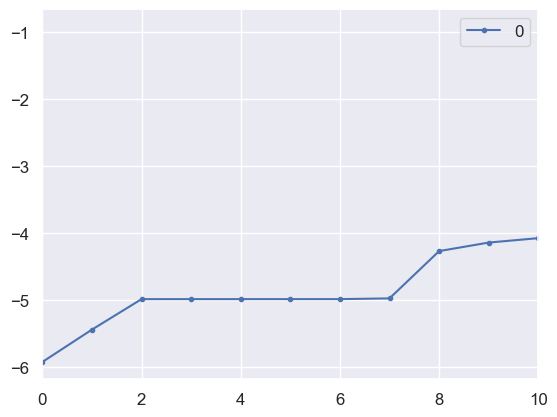

In [173]:
#LOCAL OUTLIER FACTOR
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(preprocessed_train)

df_scores = clf.negative_outlier_factor_
print(df_scores[0:5])
# df_scores = -df_scores
print(np.sort(df_scores)[0:5])

scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 10], style='.-')
plt.show()

In [174]:
th = np.sort(df_scores)[2]

print(preprocessed_train[df_scores < th])

print(preprocessed_train[df_scores < th].shape)


print(preprocessed_train.describe([0.01, 0.05, 0.75, 0.90, 0.99]).T)

print(preprocessed_train[df_scores < th].index)

     LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ExterCond  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  \
601       -1.167   -0.120        0.000        1.000     -0.783        -1.189       0.000      0.000      1.000    -1.000     0.000         0.000        -0.600      -0.906         0.000       0.000      0.379       -0.489     -1.000    -0.726     0.969         0.000     -0.138         0.000         0.000    -1.000     1.000         0.000         0.000        1.000         0.000       0.000       0.000        0.500        0.024        -1.000      -1.000       0.232       0.000       0.000   
690       

In [175]:
preprocessed_train[df_scores < th].drop(axis=0, labels=preprocessed_train[df_scores < th].index)

Empty DataFrame
Columns: [LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, HeatingQC, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscVal, SalePrice, NEW_1st*GrLiv, NEW_Garage*GrLiv, TotalQual, NEW_TotalFlrSF, NEW_TotalBsmtFin, NEW_PorchArea, NEW_TotalHouseArea, NEW_TotalSqFeet, NEW_LotRatio, NEW_RatioArea, NEW_GarageLotRatio, NEW_MasVnrRatio, NEW_DifArea, NEW_OverallGrade, NEW_Restoration, NEW_HouseAge, NEW_RestorationAge, NEW_GarageAge, NEW_GarageRestorationAge, NEW_GarageSold, NEW_TotalBaths, MoSoldsin, MoSoldcos, MSZoning_RL, MSZoning_RM, MSZoning_Rare, Street_Rare, Alley_None, Alley_Pave, LotShape_IR2, LotShape_Rare, LotShape_Reg, LandContour_HLS, LandContour_Low, LandContour_Lvl, Utilities_Rare, LotConfig_CulDSac, LotConfig_FR2, LotConfig_Inside, LotConfig_Rare, LandSlope_Mod, LandSlope_Rare, Condition1_Feedr, Condition1_Norm, Condition1_PosN, Condition1_RRAn, Condition1_Rare, Condition2_Rare, BldgType_2fmCon, BldgType_Duplex, ...]
Index: []

In [176]:
y = preprocessed_train["SalePrice"]
X = preprocessed_train.drop(["SalePrice"], axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
rf_model = RandomForestRegressor(random_state=46).fit(X, y)

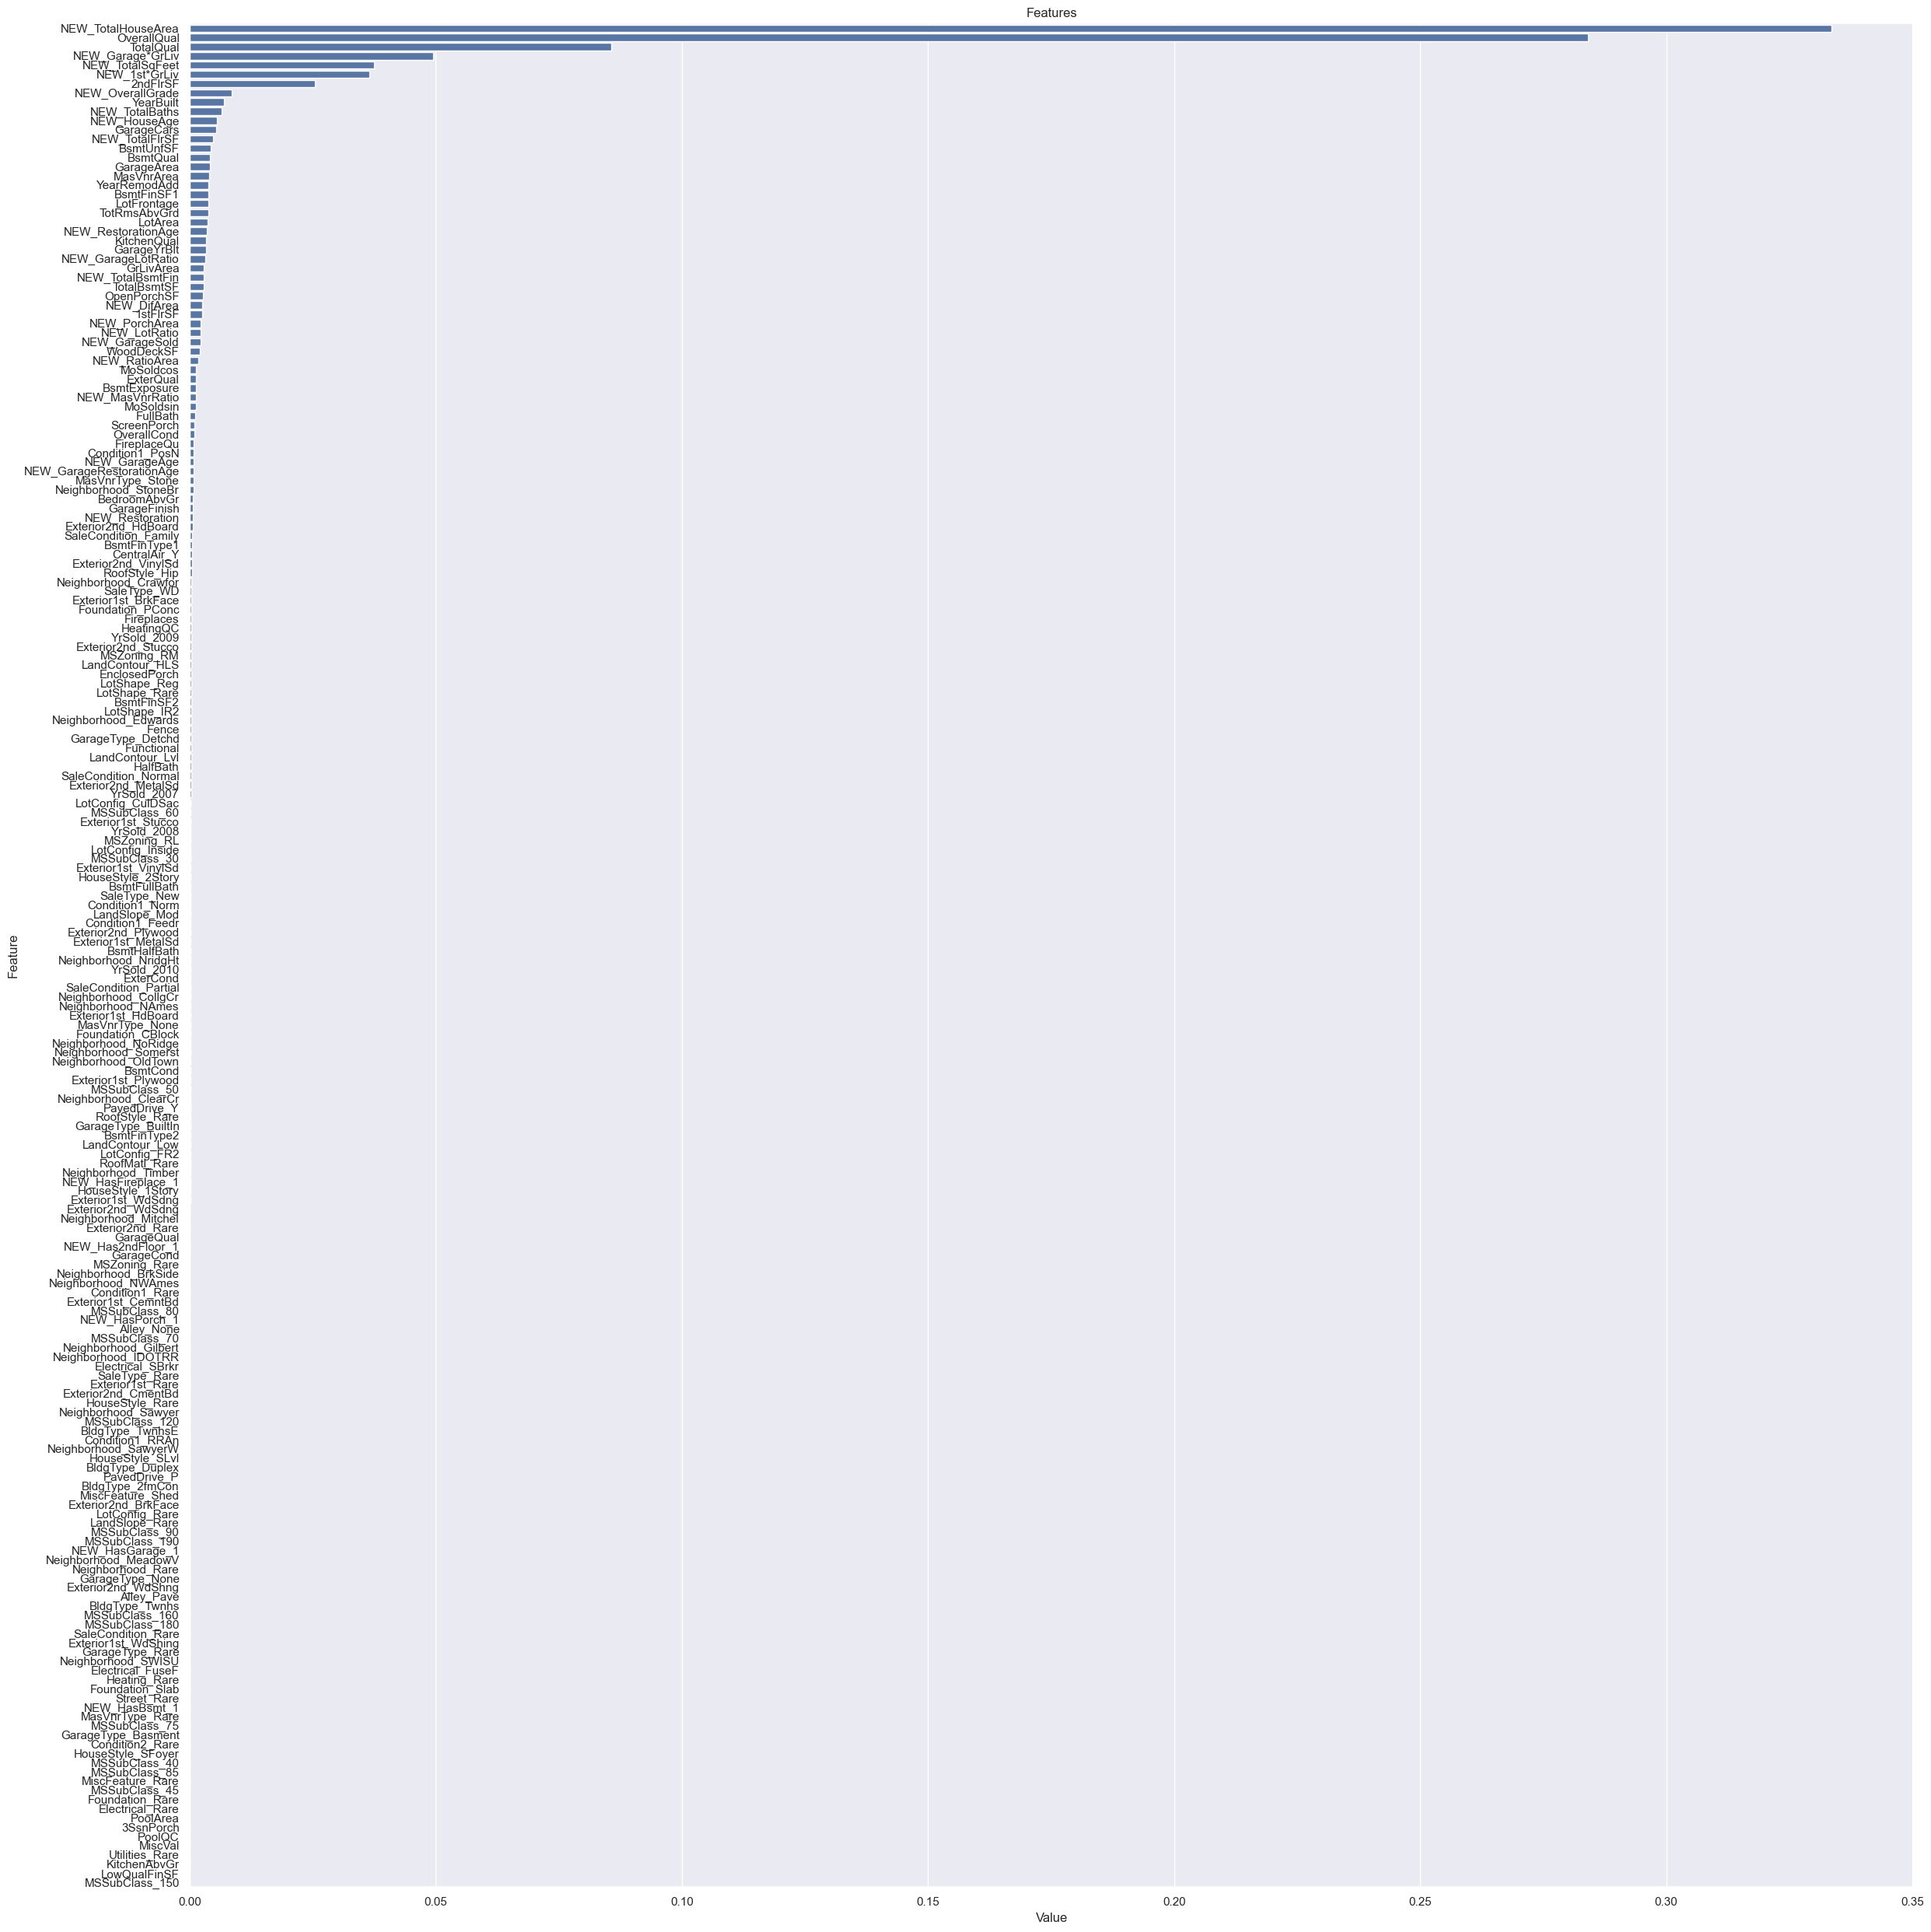

In [177]:
######################################################
# Feature Importance
######################################################

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(25, 25))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(rf_model, X)

## TO CSV

In [178]:
preprocessed_train.to_csv('train_preprocessed.csv', index = False)
preprocessed_test.to_csv('test_preprocessed.csv', index = False)

In [184]:
if preprocessed_train.columns.__len__ == preprocessed_test.columns.__len__:
    print('Problem')
else:
    print('No problem')

Problem


In [187]:
preprocessed_test = preprocessed_test.drop(["SalePrice"], axis=1)